赛题网址
http://www.pkbigdata.com/common/cmpt/%E7%94%A8%E6%88%B7%E8%B4%B7%E6%AC%BE%E9%A3%8E%E9%99%A9%E9%A2%84%E6%B5%8B_%E8%B5%9B%E4%BD%93%E4%B8%8E%E6%95%B0%E6%8D%AE.html

<font face="微软雅黑" size=5> Contents： </font>  
1. 数据介绍  
2. 导入数据  
&ensp;&ensp;&ensp;&ensp;2.1 导入user_info  
&ensp;&ensp;&ensp;&ensp;2.2 导入bank_detail  
&ensp;&ensp;&ensp;&ensp;2.3 导入browse_history  
&ensp;&ensp;&ensp;&ensp;2.4 导入bill_detail  
&ensp;&ensp;&ensp;&ensp;2.5 导入loan_time  
&ensp;&ensp;&ensp;&ensp;2.6 导入overdue  
3. 描述性统计  
&ensp;&ensp;&ensp;&ensp;3.1 缺失值统计  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;3.1.1 user_info, loan_time, overdue  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;3.1.2 bank_detail, browse_history, bill_detail  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;3.1.3从userID角度看缺失  
&ensp;&ensp;&ensp;&ensp;3.2 描述性统计  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;3.2.1 user_info  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;3.2.2 loan_time  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;3.2.3 bank_detail  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;3.2.4 browse_history  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;3.2.5 bill_detail  
4. 特征工程  
&ensp;&ensp;&ensp;&ensp;4.1 bank_detail整合  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;4.1.1 groupby and feature creation  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;4.1.2 描述性统计  
&ensp;&ensp;&ensp;&ensp;4.2 browse_history整合  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;4.2.1 groupby and feature creation  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;4.2.2 描述性统计  
&ensp;&ensp;&ensp;&ensp;4.3 bill_detail整合  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;4.3.1 groupby and feature creation  
5. 汇总表与缺失值填充  
&ensp;&ensp;&ensp;&ensp;5.1 预处理  
&ensp;&ensp;&ensp;&ensp;5.2 bank_detail分箱处理  
&ensp;&ensp;&ensp;&ensp;5.3 user_info  
&ensp;&ensp;&ensp;&ensp;5.4 browse_history_stats 和 bill_detail_stats  
&ensp;&ensp;&ensp;&ensp;5.5 整合总表  


# 1. 数据介绍
   
&ensp;&ensp;赛题提供数据分为训练集train、未知样本集test（待预测）。其中，train和test里各有6张同名表，同名表拥有相同的字段：  
1.用户的基本属性user_info.txt。  
2.银行流水记录bank_detail.txt。  
3.用户浏览行为browse_history.txt。  
4.信用卡账单记录bill_detail.txt。  
5.放款时间信息loan_time.txt。  
6.顾客是否发生逾期行为的记录overdue.txt。  
（注意，前5张表，训练集表有后缀train，未知样本集有后缀test。注意，第6张表，train里叫overdue.txt，含两字段，其中有 “样本标签” 字段表示是否违约，而test里对应的表叫usersID_test.txt，没有“样本标签”字段）

# 2. 导入数据
  
&ensp;&ensp;总体思路：  
1.先把train和test的同名表导入，上下链接为一张长表。共得6张长表。   
2.有些表的userID不unique，说明每个userID对应多条记录，这种情况，需要后期进行groupby处理，使得一个userID对应一条记录。  
3.因为6张长表都有userID字段作为标识，故以此字段作为链接，把6张长表concatenate成一张总表。  
4.因 “顾客是否发生逾期行为的记录overdue” 表里，原本的训练集train样本有 “是否违约” 的字段，而原本的未知样本集test样本没有此字段/此字段值为nan，所以可以此为依据，将总表再次划分为 训练集表 和 未知数据集表。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import scipy
import MDLP_discretization as MDLP   # MDLP_discretization_(myself_improve--my characters+regulation)-Copy1
import Custom_Functions as CF    # 此文档记录了所有的自定义函数。
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import time

C:\Users\shuangjun\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import importlib # 用于 reload 模块。

importlib.reload(CF)

<module 'Custom_Functions' from 'C:\\Users\\shuangjun\\Machine Learning Practice\\RiskPre2\\Custom_Functions.py'>

## 2.1 导入 user_info

In [3]:
# 读入user_into的train和test两表  

user_info_train = pd.read_csv(r"F:\RiskPre2\train\user_info_train.txt", header=None, names=["userID","gender","career","education","marriage","residence"], index_col=0)
user_info_test  = pd.read_csv(r"F:\RiskPre2\test\user_info_test.txt", header=None, names=["userID","gender","career","education","marriage","residence"], index_col=0)

# 打开两个txt文件时，发现user_info_train的userID不是从1开始的，而是杂乱无序的。user_info_test的也这样。  
# 这里，pd.read_csv时设置index_col=0，也就是让userID列作为行索引，主要是为了便于之后concat，而不是检查userID的unique。  
# 是否设置index_col=0，都可以检查userID的unique。  

In [4]:
# 检查两表的userID各自是否都是唯一无重复的，确实是。 

print("The userID in user_info_train is unique ?", user_info_train.index.is_unique)
print("The userID in user_info_test is unique ?", user_info_test.index.is_unique)

# 用.index取得一个dataframe的行索引，用.is_unique判断它里的值是否都是唯一的。  
# 结果可见，训练集和未知样本集的user_info表里的userID都是unique的。  

The userID in user_info_train is unique ? True
The userID in user_info_test is unique ? True


In [5]:
# 检查两表的userID是否有交集，除非赛题出错，一般不会有交集的。结果确实无交集。

userIDintersection_user_info = np.intersect1d(user_info_train.index,user_info_test.index)
print("The intersection of userID in user_info_train and user_info_test is   ",userIDintersection_user_info )

# 用np.intersect1d检查两个array-like object之间有无重复元素，并返回重复元素构成的array。

The intersection of userID in user_info_train and user_info_test is    []


In [6]:
# 因为两表的userID无交集，所以可以放心concat。

user_info = pd.concat([user_info_train, user_info_test]).sort_index().reset_index("userID")

# 两表上下concat的时候，可以依赖两表的userID行索引进行concat。
# sort_index()使得索引userID进行排序。
# reset_index()把排好序的行索引又变回列，同时给长表添加0,1,2,3，，的行索引。
# 这样，训练集和测试集结合成的长表就按照userID递增的顺序排序了。

In [7]:
# 数据展示

user_info_train.head(3)

,gender,career,education,marriage,residence
userID,,,,,
3150,1,2,4,1,4
6965,1,2,4,3,2
1265,1,3,4,3,1


In [8]:
print("shape : ", user_info.shape)
user_info.head(3)

shape :  (69495, 6)


,userID,gender,career,education,marriage,residence
0,1,1,2,3,1,3
1,2,1,2,3,2,1
2,3,1,4,4,1,4


In [9]:
# CF.Calnan是自定义函数，用来检查缺失值。

CF.Calnan(user_info) # 说明 user_info 无缺失

,column_name,nancount,nanpercent
0,userID,0,0.0
1,gender,0,0.0
2,career,0,0.0
3,education,0,0.0
4,marriage,0,0.0
5,residence,0,0.0


In [10]:
user_info.dtypes

userID       int64
gender       int64
career       int64
education    int64
marriage     int64
residence    int64
dtype: object

##  2.2 导入 bank_detail

In [11]:
# 读入bank_detail的train和test两表

bank_detail_train = pd.read_csv(r"F:\RiskPre2\train\bank_detail_train.txt", header=None, names=["userID","bank_time","transaction_type","transaction_amount","salary_income"], index_col=0)
bank_detail_test  = pd.read_csv(r"F:\RiskPre2\test\bank_detail_test.txt", header=None, names=["userID","bank_time","transaction_type","transaction_amount","salary_income"], index_col=0)


C:\Users\shuangjun\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [12]:
# 检查两表的userID各自是否都是唯一无重复的，结果显示都有重复。
# 这说明后序需要groupby进行处理。

print("The userID in bank_detail_train is unique ?", bank_detail_train.index.is_unique)
print("The userID in bank_detail_test is unique ?", bank_detail_test.index.is_unique)

The userID in bank_detail_train is unique ? False
The userID in bank_detail_test is unique ? False


In [13]:
# 检查两表的userID是否有交集，除非赛题出错，一般不会有交集的。结果确实无交集。

userIDintersection_bank_detail = np.intersect1d(bank_detail_train.index,bank_detail_test.index)
print("The intersection of userID in bank_detail_train and bank_detail_test is   ",userIDintersection_bank_detail )

The intersection of userID in bank_detail_train and bank_detail_test is    []


In [14]:
# 因为两表的userID无交集，所以可以放心concat。

bank_detail = pd.concat([bank_detail_train, bank_detail_test]).sort_index().reset_index("userID")

In [15]:
# 数据展示

bank_detail_train.head(3)

,bank_time,transaction_type,transaction_amount,salary_income
userID,,,,
6965,5894316387,0,13.756664,0
6965,5894321388,1,13.756664,0
6965,5897553564,0,14.449810,0


In [16]:
bank_detail.head(3)

,userID,bank_time,transaction_type,transaction_amount,salary_income
0,1,5912436687,1,2.344542,0
1,1,5895415887,1,15.855337,0
2,1,5895415887,0,15.855337,0


In [17]:
bank_detail.dtypes

userID                  int64
bank_time               int64
transaction_type        int64
transaction_amount    float64
salary_income           int64
dtype: object

## 2.3 导入 browse_history

In [18]:
# 读入browse_history的train和test两表

browse_history_train = pd.read_csv(r"F:\RiskPre2\train\browse_history_train.txt", header=None, names=["userID","browse_time","browse_behavior","browse_num"], index_col=0)
browse_history_test  = pd.read_csv(r"F:\RiskPre2\test\browse_history_test.txt", header=None, names=["userID","browse_time","browse_behavior","browse_num"], index_col=0)


C:\Users\shuangjun\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [19]:
# 检查两表的userID各自是否都是唯一无重复的，结果显示都有重复。
# 这说明后序需要groupby进行处理。

print("The userID in browse_history_train is unique ?", browse_history_train.index.is_unique)
print("The userID in browse_history_test is unique ?", browse_history_test.index.is_unique)

The userID in browse_history_train is unique ? False
The userID in browse_history_test is unique ? False


In [20]:
# 检查两表的userID是否有交集，除非赛题出错，一般不会有交集的。结果确实无交集。

userIDintersection_browse_history = np.intersect1d(browse_history_train.index,browse_history_test.index)
print("The intersection of userID in browse_history_train and browse_history_test is   ",userIDintersection_browse_history)

The intersection of userID in browse_history_train and browse_history_test is    []


In [21]:
# 因为两表的userID无交集，所以可以放心concat。

browse_history = pd.concat([browse_history_train,browse_history_test]).sort_index().reset_index("userID")

In [22]:
# 数据展示

browse_history_train.head(3)

,browse_time,browse_behavior,browse_num
userID,,,
34801,5926003545,173,1
34801,5926003545,164,4
34801,5926003545,38,7


In [23]:
browse_history.head(3)

,userID,browse_time,browse_behavior,browse_num
0,2,5893398099,143,3
1,2,5912610799,189,1
2,2,5912610799,44,5


In [24]:
browse_history.dtypes

userID             int64
browse_time        int64
browse_behavior    int64
browse_num         int64
dtype: object

## 2.4 导入 bill_detail

In [25]:
# 读入bill_detail的train和test两表

bill_detail_train = pd.read_csv(r"F:\RiskPre2\train\bill_detail_train.txt", header=None, names=["userID","bill_time","bankID","last_bill_amount","last_repay_amount","credit_limit","current_bill_balance","current_bill_minrepay","consume_num","current_bill_amount","adjust_amount","cyclic_interest","available_balance","borrow_cash","repay_status"], index_col=0)
bill_detail_test  = pd.read_csv(r"F:\RiskPre2\test\bill_detail_test.txt", header=None, names=["userID","bill_time","bankID","last_bill_amount","last_repay_amount","credit_limit","current_bill_balance","current_bill_minrepay","consume_num","current_bill_amount","adjust_amount","cyclic_interest","available_balance","borrow_cash","repay_status"], index_col=0)


C:\Users\shuangjun\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [26]:
# 检查两表的userID各自是否都是唯一无重复的，结果显示都有重复。
# 这说明后序需要groupby进行处理。

print("The userID in bill_detail_train is unique ?", bill_detail_train.index.is_unique)
print("The userID in bill_detail_test is unique ?", bill_detail_test.index.is_unique)

The userID in bill_detail_train is unique ? False
The userID in bill_detail_test is unique ? False


In [27]:
# 检查两表的userID是否有交集，除非赛题出错，一般不会有交集的。结果确实无交集。

userIDintersection_bill_detail = np.intersect1d(bill_detail_train.index,bill_detail_test.index)
print("The intersection of userID in bill_detail_train and bill_detail_test is   ",userIDintersection_bill_detail)

The intersection of userID in bill_detail_train and bill_detail_test is    []


In [28]:
# 因为两表的userID无交集，所以可以放心concat。

bill_detail = pd.concat([bill_detail_train,bill_detail_test]).sort_index().reset_index("userID")

In [29]:
# 数据展示

bill_detail_train.head(3)

,bill_time,bankID,last_bill_amount,last_repay_amount,credit_limit,current_bill_balance,current_bill_minrepay,consume_num,current_bill_amount,adjust_amount,cyclic_interest,available_balance,borrow_cash,repay_status
userID,,,,,,,,,,,,,,
3150,5906744363,6,18.626118,18.661937,20.664418,18.905766,17.847133,1,0.0,0.0,0.0,0.0,19.971271,0
3150,5906744401,6,18.905766,18.909954,20.664418,19.113305,17.911506,1,0.0,0.0,0.0,0.0,19.971271,0
3150,5906744427,6,19.113305,19.150290,20.664418,19.300194,17.977610,1,0.0,0.0,0.0,0.0,19.971271,0


In [30]:
bill_detail.head(3)

,userID,bill_time,bankID,last_bill_amount,last_repay_amount,credit_limit,current_bill_balance,current_bill_minrepay,consume_num,current_bill_amount,adjust_amount,cyclic_interest,available_balance,borrow_cash,repay_status
0,2,5925655887,4,18.647124,18.988680,19.971271,19.115077,16.815370,0,19.342198,0.0,0.0,0.0,0.0,0
1,2,5904923847,4,17.389606,17.389606,19.460445,16.656269,15.366101,1,16.656269,0.0,0.0,0.0,0.0,0
2,2,5907300387,4,16.656269,17.402921,19.460445,19.393161,17.092432,4,19.462586,0.0,0.0,0.0,0.0,0


In [31]:
bill_detail.dtypes

userID                     int64
bill_time                  int64
bankID                     int64
last_bill_amount         float64
last_repay_amount        float64
credit_limit             float64
current_bill_balance     float64
current_bill_minrepay    float64
consume_num                int64
current_bill_amount      float64
adjust_amount            float64
cyclic_interest          float64
available_balance        float64
borrow_cash              float64
repay_status               int64
dtype: object

## 2.5 导入loan_time

In [32]:
# 读入loan_time的train和test两表

loan_time_train = pd.read_csv(r"F:\RiskPre2\train\loan_time_train.txt", header=None, names=["userID","loan_time"], index_col=0)
loan_time_test  = pd.read_csv(r"F:\RiskPre2\test\loan_time_test.txt", header=None, names=["userID","loan_time"], index_col=0)


In [33]:
# 检查两表的userID各自是否都是唯一无重复的，确实是。

print("The userID in loan_time_train is unique ?", loan_time_train.index.is_unique)
print("The userID in loan_time_test is unique ?", loan_time_test.index.is_unique)

The userID in loan_time_train is unique ? True
The userID in loan_time_test is unique ? True


In [34]:
# 检查两表的userID是否有交集，除非赛题出错，一般不会有交集的。结果确实无交集。

userIDintersection_loan_time = np.intersect1d(loan_time_train.index,loan_time_test.index)
print("The intersection of userID in loan_time_train and loan_time_test is   ",userIDintersection_loan_time)

The intersection of userID in loan_time_train and loan_time_test is    []


In [35]:
# 因为两表的userID无交集，所以可以放心concat。

loan_time = pd.concat([loan_time_train,loan_time_test]).sort_index().reset_index("userID")

In [36]:
# 数据展示

loan_time_train.head(3)

,loan_time
userID,
1,5914855887
2,5914855887
3,5914855887


In [37]:
print("shape: ",loan_time.shape)
loan_time.head(3)

shape:  (69495, 2)


,userID,loan_time
0,1,5914855887
1,2,5914855887
2,3,5914855887


In [38]:
CF.Calnan(loan_time) # 说明 loan_time无缺失。

,column_name,nancount,nanpercent
0,userID,0,0.0
1,loan_time,0,0.0


In [39]:
loan_time.dtypes

userID       int64
loan_time    int64
dtype: object

In [40]:
loan_time['loan_time'].value_counts().shape

(213,)

## 2.6 导入 overdue

In [41]:
# 读入overdue的train和test两表
# 注意，未知数据集的usersID_test表只有 userID 这一列，而此处的pd.read_csv里设置names=["userID","target"]，
# 事实上是为dataframe新建了一列target，此列用nan填充。

overdue_train = pd.read_csv(r"F:\RiskPre2\train\overdue_train.txt", header=None, names=["userID","target"], index_col=0)
overdue_test  = pd.read_csv(r"F:\RiskPre2\test\usersID_test.txt", header=None, names=["userID","target"], index_col=0)


In [42]:
# 检查两表的userID各自是否都是唯一无重复的，确实是。

print("The userID in overdue_train is unique ?", overdue_train.index.is_unique)
print("The userID in overdue_test is unique ?", overdue_test.index.is_unique)

The userID in overdue_train is unique ? True
The userID in overdue_test is unique ? True


In [43]:
# 检查两表的userID是否有交集，除非赛题出错，一般不会有交集的。结果确实无交集。

userIDintersection_overdue = np.intersect1d(overdue_train.index,overdue_test.index)
print("The intersection of userID in overdue_train and overdue_test is   ",userIDintersection_overdue)

The intersection of userID in overdue_train and overdue_test is    []


In [44]:
# 因为两表的userID无交集，所以可以放心concat。

overdue = pd.concat([overdue_train,overdue_test]).sort_index().reset_index("userID")

In [45]:
# 数据展示

overdue_train.head(3)

,target
userID,
1,0
2,0
3,0


In [46]:
overdue_test.head(3)

,target
userID,
55597,NaN
55598,NaN
55599,NaN


In [47]:
print("shape:", overdue.shape)
overdue.head(3)

shape: (69495, 2)


,userID,target
0,1,0.0
1,2,0.0
2,3,0.0


In [48]:
CF.Calnan(overdue)  # 有 13899 的未知样本集。

,column_name,nancount,nanpercent
0,userID,0,0.0
1,target,13899,0.2


In [49]:
print("shape:", overdue_train.shape)
print("shape:", overdue_test.shape)

shape: (55596, 1)
shape: (13899, 1)


In [50]:
overdue.dtypes

userID      int64
target    float64
dtype: object

# 3. 描述性统计

&ensp;&ensp;在所有的数据清洗步骤（识别极端值、填补缺失值、删除极端样本等）之前进行描述性统计，且只对训练集进行。

## 3.1 缺失值统计

1. 得到的6张长表里，有没有缺失值？没有。我们的原始数据是.txt形式，即使有空值，在.txt里也会是''空，或' '空格 这种，通过read_csv读入后还是空或空格，而如果这一列其它都是数值，却有几个是空或空格，则此列的dtype应是object。但6张长表里，每一张的每个特征的dtype都是int64或float64，没有object，说明这6张长表里没有缺失值。（第6张长表里的target列有np.nan，它不是空格或空，所以此列的dtype是float64，而不是object。）

2. 一共有6张长表，当依照userID将之组合起来的时候，会有缺失值么？换句话说，统计每一张的userID数量，看是否每一张都有所有用户的记录条目。

### 3.1.1 user_info, loan_time, overdue

&ensp;&ensp;user_info, loan_time, overdue 三张长表的userID列都是唯一的，且排过序的。(包括训练集和未知样本集全体)。统计每张表包含的userID数目，及范围。  

In [51]:
print("The number of users in user_info is %d; The min userID is %d; The max userID is %d ;" % (user_info["userID"].size, user_info["userID"][0], user_info["userID"][user_info["userID"].size-1]))
print("The number of users in loan_time is %d; The min userID is %d; The max userID is %d ;" % (loan_time["userID"].size, loan_time["userID"][0], loan_time["userID"][loan_time["userID"].size-1]))
print("The number of users in overdue is %d; The min userID is %d; The max userID is %d ;" % (overdue["userID"].size, overdue["userID"][0], overdue["userID"][overdue["userID"].size-1]))

# sn.size 返回 sn 这个 series 所含的元素数，即此表到底有多少个用户的记录。也可以 len(sn).
# sn[0] 是这个 series 的首元素。
# sn[sn.size-1] 是这个 series 的尾元素。反应了这个表所包含的用户ID的范围。

The number of users in user_info is 69495; The min userID is 1; The max userID is 69495 ;
The number of users in loan_time is 69495; The min userID is 1; The max userID is 69495 ;
The number of users in overdue is 69495; The min userID is 1; The max userID is 69495 ;


结论：  
&ensp;&ensp;可见，训练集和未知数据集所含用户总数为 69495个。userID从1到69495。user_info, loan_time, overdue 三张长表包含了所有69495个用户。

### 3.1.2 bank_detail, browse_history, bill_detail

&ensp;&ensp;bank_detail, browse_history, bill_detail 三张长表的userID列有重复，也排过序，所以需要先对userID列unique，再统计每张表包含的userID数目，及范围。  

In [52]:
tmp1 = bank_detail["userID"].unique()
print("The number of users in bank_detail is %d; The min userID is %d; The max userID is %d ;" % (tmp1.size, tmp1[0], tmp1[tmp1.size-1]))
tmp2 = browse_history["userID"].unique()
print("The number of users in browse_history is %d; The min userID is %d; The max userID is %d ;" % (tmp2.size, tmp2[0], tmp2[tmp2.size-1]))
tmp3 = bill_detail["userID"].unique()
print("The number of users in bill_detail is %d; The min userID is %d; The max userID is %d ;" % (tmp3.size, tmp3[0], tmp3[tmp3.size-1]))

# 这里用 tmpi 作为临时变量，记录 series，即每个表的 userID列。

The number of users in bank_detail is 10003; The min userID is 1; The max userID is 69094 ;
The number of users in browse_history is 59327; The min userID is 2; The max userID is 69494 ;
The number of users in bill_detail is 66817; The min userID is 2; The max userID is 69495 ;


In [53]:
print("%.2f%% users has bank_detail information;" % (tmp1.size/69495*100))
print("%.2f%% users has browse_history information;" % (tmp2.size/69495*100))
print("%.2f%% users has bill_detail information;" % (tmp3.size/69495*100))

# 注意，想要格式化输出的同时输出百分号 %，可以用 %% .

14.39% users has bank_detail information;
85.37% users has browse_history information;
96.15% users has bill_detail information;


结论：  
&ensp;&ensp;可见，这三张长表所包含的用户数都少于 69495 这个总数。  
1. 只有 14.39% 的用户有 bank_detail 信息，实在是太少了。可以选择：A.不使用bank_detail表。B.把缺失bank_detail信息的用户在此表的变量里的值记为某个值，且作为一个类别，就叫 缺失类别，参与统计。出于想要尽可能利用现有数据的目的，后期选择了B法。  
2. 有85.37% 的用户有 browse_history 信息，有96.15%的用户有bill_detail信息，都比较多，可以用算法填充缺失值的方法填补完整。

### 3.1.3 从userID角度看缺失

&ensp;&ensp;每个用户都拥有user_info, loan_time, overdue信息， 有多少用户拥有bank_detail, browse_history, bill_detail 信息？ 

In [54]:
print("There's %d users in train;" % user_info_train.index.size)
tmp4 = set(user_info_train.index)-set(bank_detail_train.index)-set(browse_history_train.index)-set(bill_detail_train.index)
print("There's %d users in train have no bank_detail&browse_history&bill_detail information;The ratio is %.2f%%;" % (len(tmp4),len(tmp4)/user_info_train.index.size*100))
trainuser_without_bankbrowsebill = tmp4
# set(ar1)-set(ar2) 得到的是两个集合的差集，即存在于数组ar1但不存在于ar2的元素构成的集合。

There's 55596 users in train;
There's 37 users in train have no bank_detail&browse_history&bill_detail information;The ratio is 0.07%;


In [55]:
print("There's %d users in test;" % user_info_test.index.size)
tmp5 = set(user_info_test.index)-set(bank_detail_test.index)-set(browse_history_test.index)-set(bill_detail_test.index)
print("There's %d users in test have no bank_detail&browse_history&bill_detail information;The ratio is %.2f%%;" % (len(tmp5),len(tmp5)/user_info_test.index.size*100))

There's 13899 users in test;
There's 2 users in test have no bank_detail&browse_history&bill_detail information;The ratio is 0.01%;


结论：  
&ensp;&ensp;可见，约0.07%的训练集用户，约0.01%的未知样本集用户，同时缺乏bank_detail, browse_history, bill_detail 信息。对于这样的训练集用户来说，缺少太多信息，即使以后都用各种值填补起来，也不见得好，可以考虑删掉这37条训练集数据。当然，未知样本集的这2位用户肯定是不能删的。

## 3.2 描述性统计 

1. 仅用 训练集 进行描述统计。  
2. user_info_train, loan_time_train, overdue_train 三张表，其userID是唯一无重复的。user_info_train和loan_time_train分别都与overdue_train左右concat。  
3. 对于以上三张表的每一张，进行单变量描述统计、极端值识别、做分布图。
4. 对表里的每个变量进行“要素分析”，即违约分布统计（观察此变量每个值的违约正常用户比值）。

###  3.2.1 user_info

user_info_train的5个字段都是 无序类别变量（名义变量），适合用条形图进行展示。  
1. 先使用sn.value_counts()判断每个字段里的值分布。
2. 用条形图展示值分布。
3. 名义变量，异常值的判定方法：若某个类别所含样品频数特别少，则可以认为是异常值，舍弃。若有多个类别的样本频数都较少，可以考虑合并类别。  
4. 用target标签对每个字段进行分组：违约与正常。用叠加条形图的方式进行“要素分析”。并且计算一个字段的每个类别中，违约人数与正常人数的比值（odds in category），并画出折线图（蓝色折线）。另外，用总数据集中违约人数与正常人数的比值（odds）作图，即每张图里的红色横线。对一个字段观察，通过比较同一字段不同类别的odds值大小，并与总训练集的odds比较（红色横线），看这个类别的偏向。比如高过红线，说明这个类别里的违约正常比 比 总训练集的违约正常比要高，说明如果某个样本在此字段是落入这个类别，则倾向于预测为违约人。低于红线，说明这个类别里的违约正常比 比 总训练集的违约正常比要低，说明如果某个样本在此字段是落入这个类别，则倾向于预测为正常。
5. 比较某字段在类别合并前后的信息熵、基尼值、信息值IV，若合并后信息熵值减小/基尼值减小/信息值IV增大，则确认合并类别有助于提高此字段的分类能力，可以考虑合并类别。

In [56]:
# 将user_info_train与overdue_train按 userID 左右concat，结果用user_info_train_Y表示。（带Y表示带违约标记列）

user_info_train_Y = user_info_train.join(overdue_train).sort_index()
user_info_train_Y.head(4)

,gender,career,education,marriage,residence,target
userID,,,,,,
1,1,2,3,1,3,0
2,1,2,3,2,1,0
3,1,4,4,1,4,0
4,1,4,4,3,2,1


每个字段的值分布统计。

In [57]:
user_info_train_Y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55596 entries, 1 to 55596
Data columns (total 6 columns):
gender       55596 non-null int64
career       55596 non-null int64
education    55596 non-null int64
marriage     55596 non-null int64
residence    55596 non-null int64
target       55596 non-null int64
dtypes: int64(6)
memory usage: 3.0 MB


In [58]:
user_info_train_Y["gender"].value_counts()

1    44254
2     9673
0     1669
Name: gender, dtype: int64

In [59]:
user_info_train_Y["career"].value_counts()

2    41150
4     8087
3     5898
0      368
1       93
Name: career, dtype: int64

In [60]:
user_info_train_Y["education"].value_counts()

3    23530
4    22988
2     8483
0      369
1      226
Name: education, dtype: int64

In [61]:
user_info_train_Y["marriage"].value_counts()

1    25098
3    22554
2     6038
4     1471
0      370
5       65
Name: marriage, dtype: int64

In [62]:
user_info_train_Y["residence"].value_counts()

1    17105
2    15557
4    14349
3     8216
0      369
Name: residence, dtype: int64

In [63]:
# 用target标签对每个字段进行分组。

user_info_train_Y["target"].unique() # 可见，target只有0,1两值。1违约，0正常。

array([0, 1], dtype=int64)

In [64]:
user_info_train_Y_0 = user_info_train_Y.loc[user_info_train_Y["target"]==0,:] # 从训练集的 user_info_train_Y表中提取出 target 为正常的部分。
user_info_train_Y_1 = user_info_train_Y.loc[user_info_train_Y["target"]==1,:] # 从训练集的 user_info_train_Y表中提取出 target 为违约的部分。

In [65]:
# 可以对一个字段gender用value_counts试一试。其它字段雷同。

user_info_train_Y_0["gender"].value_counts()

1    38616
2     8782
0     1015
Name: gender, dtype: int64

In [66]:
user_info_train_Y_1["gender"].value_counts()

1    5638
2     891
0     654
Name: gender, dtype: int64

&ensp;&ensp;条形图展示，左为 训练集样本在每个字段的各个值上的分布（深蓝色柱状图），右为 训练集样本每个字段的各个值上的正常和违约的分布（蓝色是正常，橙色是违约）。计算一个字段的每个类别中，违约人数与正常人数的比值（odds in category），并画出折线图（蓝色折线）。另外，用总数据集中违约人数与正常人数的比值（odds）作图，即每张图里的红色横线。对一个字段观察，通过比较同一字段不同类别的odds值大小，并与总训练集的odds比较（红色横线），看这个类别的偏向。比如高过红线，说明这个类别里的违约正常比 比 总训练集的违约正常比要高，说明如果某个样本在此字段是落入这个类别，则倾向于预测为违约人。低于红线，说明这个类别里的违约正常比 比 总训练集的违约正常比要低，说明如果某个样本在此字段是落入这个类别，则倾向于预测为正常。  
&ensp;&ensp;左右图对应。

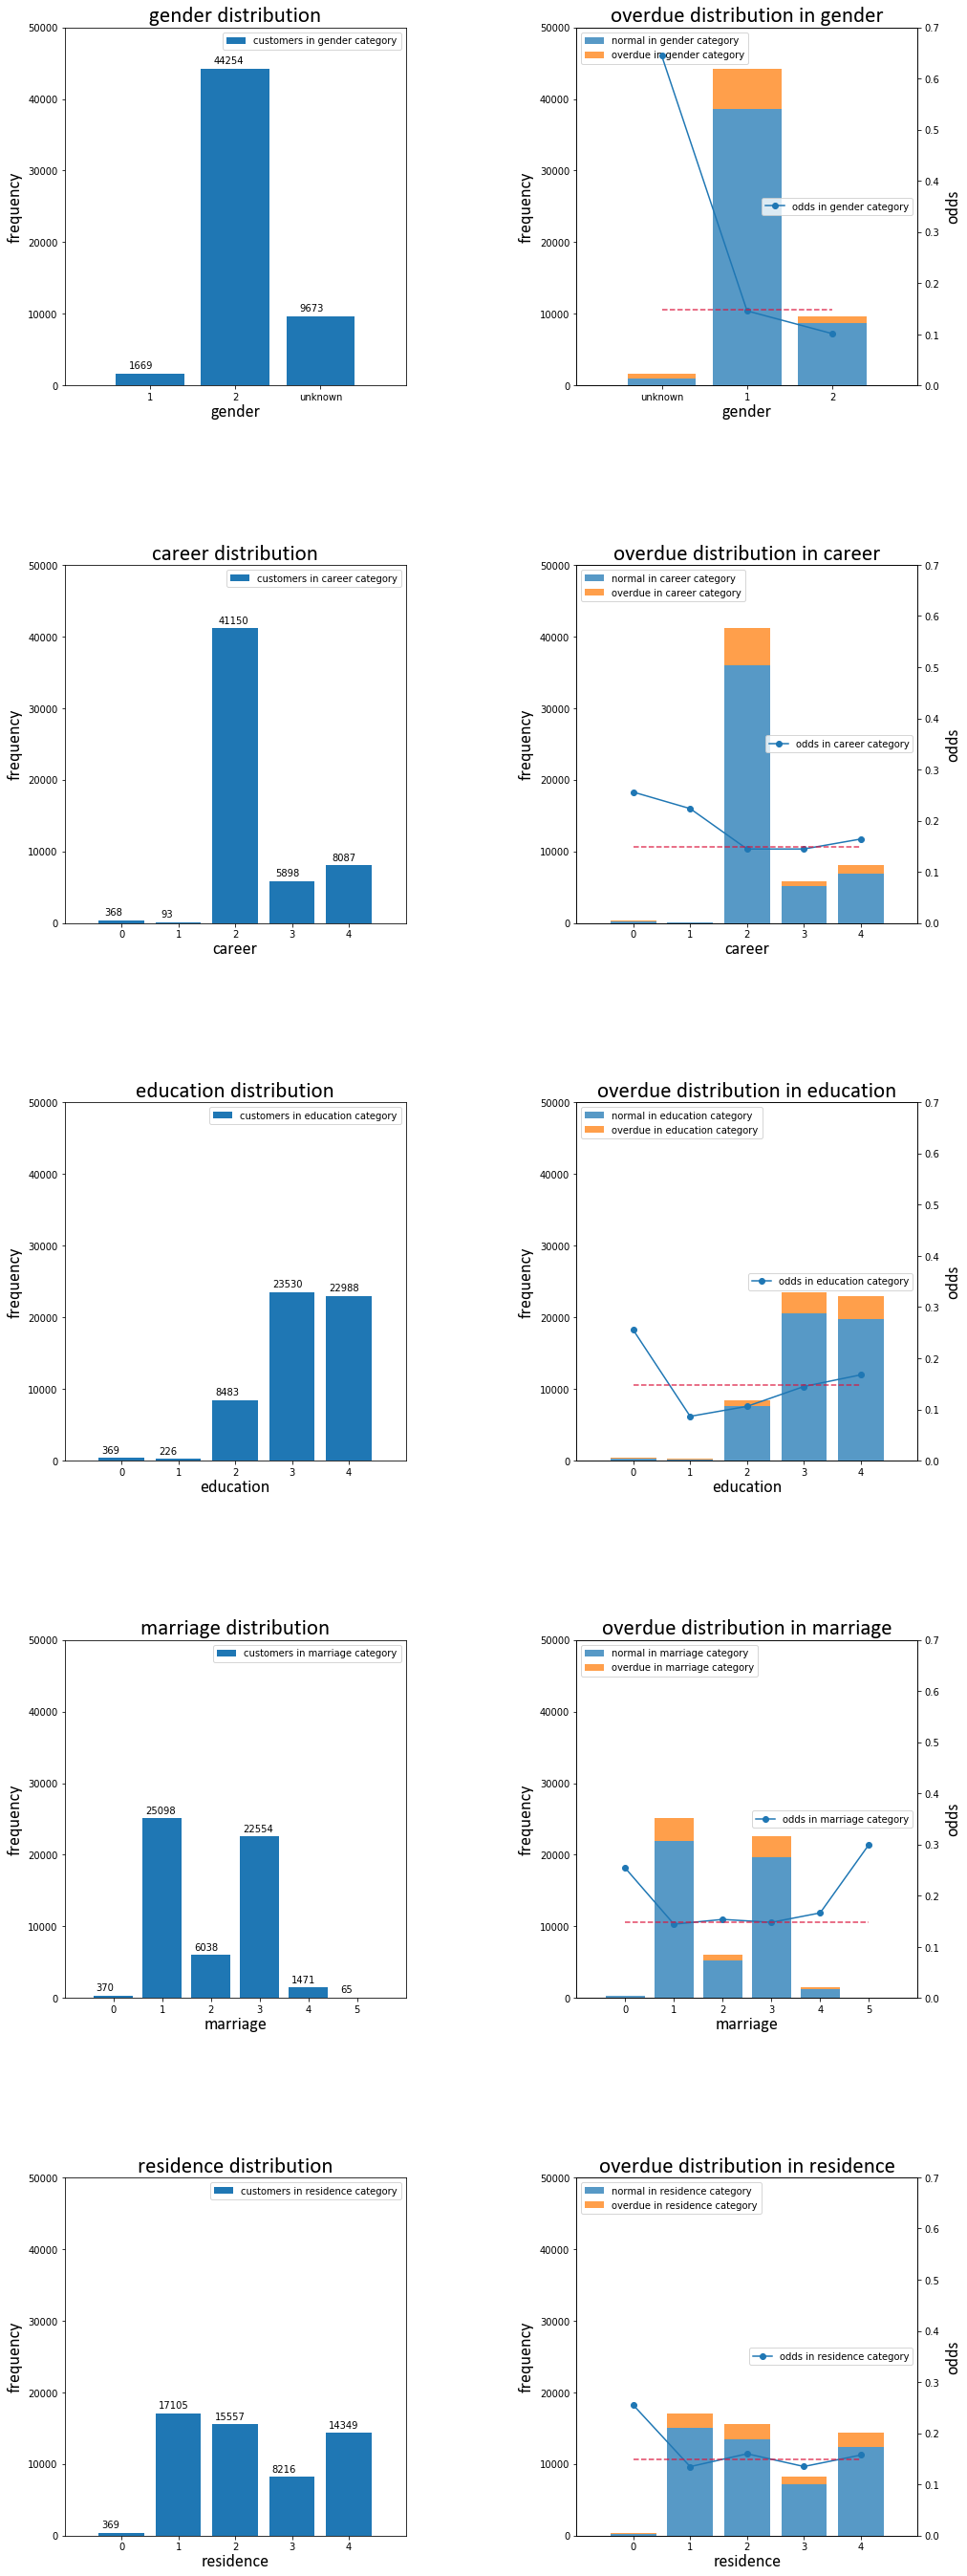

In [67]:
fig1 = plt.figure(figsize = (16,100)) # 左宽右高

font1 = {'family': 'Calibri','weight': 'normal','size': 18} # 轴标签字体
font2 = {'family': 'Calibri','weight': 'normal','size': 23} # 图标题字体
odds = user_info_train_Y_1.shape[0]/user_info_train_Y_0.shape[0]  # 此为总数据集中违约人数与正常人数的比值，记为odds。


ax1 = fig1.add_subplot(10,2,1)
X_gender = user_info_train_Y["gender"].value_counts().sort_index().index
Y_gender = user_info_train_Y["gender"].value_counts().sort_index()
ax1.bar(X_gender,Y_gender, tick_label=[1,2,"unknown"], width=0.8,label="customers in gender category" )  
# 注意，要在此处用tick_label设置 柱子的刻度标签，否则，图会自动按照 set_xlim的设置的-1,0,1,2,3来显示x轴的刻度标签，但显然我只想要unknown,1,2这三个标签。
# 另外，tick_label里的顺序是和 X_gender 的顺序对应的，一定不要搞错。另外，alpha设置颜色透明度。
ax1.set_title('gender distribution',fontdict=font2 ) # 设置 图标题
ax1.set_xlabel('gender',fontdict=font1,labelpad= 2)  # xlabel是横坐标的文字标签，即"gender"，fontdict设置其字体字号，labelpad设置此文字里x轴的距离。
ax1.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax1.set_ylim(bottom=0 ,top =50000)  # 设置纵坐标取值范围
ax1.set_xlim(left=-1, right=3)  # 设置横坐标取值范围
ax1.legend()
for x,y in zip(X_gender,Y_gender):
    ax1.annotate(s=str(y), xy=(x,y), xytext=(x-0.25, y+700))  # 使用annotate 添加文字标注，即每个柱子上的频数标注。



ax4 = fig1.add_subplot(10,2,2)
# X_gender 不变，即横坐标不变。
Y_gender_0 = user_info_train_Y_0["gender"].value_counts().sort_index()
Y_gender_1 = user_info_train_Y_1["gender"].value_counts().sort_index()
ax4.bar(X_gender,Y_gender_0, alpha=0.75, tick_label=["unknown",1,2], width=0.8, label = "normal in gender category" )
ax4.bar(X_gender,Y_gender_1, alpha=0.75, tick_label=["unknown",1,2], width=0.8, bottom=Y_gender_0, label = "overdue in gender category" )  # 通过 bottom=Y_gender_0 设置柱叠加 
ax4.set_title('overdue distribution in gender',fontdict=font2 ) 
ax4.set_xlabel('gender',fontdict=font1,labelpad= 2)  
ax4.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax4.set_ylim(bottom=0 ,top =50000 ) 
ax4.set_xlim(left=-1, right=3) 
ax4.legend(loc=2)
# for x,y in zip(X_gender,Y_gender_0):
#     ax4.annotate(s=str(y), xy=(x,y), xytext=(x-0.25, y+700)) 
# for x,y in zip(X_gender,Y_gender_1+Y_gender_0):
#     ax4.annotate(s=str(y), xy=(x,y), xytext=(x-0.25, y+700))     
# 还是不加 柱的频数标注了。    
Y_gender_odds = [a/b for (a,b) in zip(Y_gender_1,Y_gender_0)]  # 得到每个 gender 类别里，违约人数与正常人数的比值。
ax4_t = ax4.twinx()                                            # 做双 Y 轴图
ax4_t.plot(X_gender,Y_gender_odds, label="odds in gender category" , marker="o")
ax4_t.set_ylim(bottom=0 ,top =0.7) 
ax4_t.set_ylabel("odds",fontdict=font1,labelpad= 6)
ax4_t.legend(loc=7)
ax4_t.plot(X_gender,[odds]*(X_gender.size),color="crimson",alpha=0.8, linestyle="--")  # [odds]*(X_gender.size)是为了创建和X_gender一样元素数的列表，且列表里的每个值都是 odds。用于画平行线。
  
       
    
ax2 = fig1.add_subplot(10,2,3)
X_career = user_info_train_Y["career"].value_counts().sort_index().index
Y_career = user_info_train_Y["career"].value_counts().sort_index()
ax2.bar(X_career,Y_career, tick_label=X_career, width=0.8,label="customers in career category" ) # 这里也可以将tick_label 直接设置成X_career。
ax2.set_title('career distribution',fontdict=font2)
ax2.set_xlabel('career',fontdict=font1,labelpad= 2)
ax2.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax2.set_ylim(bottom=0 ,top =50000 )
ax2.set_xlim(left=-1, right=5)
ax2.legend()
for x,y in zip(X_career,Y_career):
    ax2.annotate(s=str(y), xy=(x,y), xytext=(x-0.3, y+700))


ax5 = fig1.add_subplot(10,2,4)
# X_career 不变，即横坐标不变。
Y_career_0 = user_info_train_Y_0["career"].value_counts().sort_index()
Y_career_1 = user_info_train_Y_1["career"].value_counts().sort_index()
ax5.bar(X_career,Y_career_0, alpha=0.75, tick_label=X_career, width=0.8,label = "normal in career category" )
ax5.bar(X_career,Y_career_1, alpha=0.75, tick_label=X_career, width=0.8, bottom=Y_career_0 ,label = "overdue in career category" )  # 通过 bottom=Y_gender_0 设置柱叠加 
ax5.set_title('overdue distribution in career',fontdict=font2 ) 
ax5.set_xlabel('career',fontdict=font1,labelpad= 2)  
ax5.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax5.set_ylim(bottom=0 ,top =50000 ) 
ax5.set_xlim(left=-1, right=5)  
ax5.legend(loc=2)
Y_career_odds = [a/b for (a,b) in zip(Y_career_1,Y_career_0)]  
ax5_t = ax5.twinx()                                            
ax5_t.plot(X_career,Y_career_odds, label="odds in career category", marker="o")
ax5_t.set_ylim(bottom=0 ,top =0.7) 
ax5_t.set_ylabel("odds",fontdict=font1,labelpad= 6)
ax5_t.legend(loc=7)
ax5_t.plot(X_career,[odds]*(X_career.size),color="crimson",alpha=0.8, linestyle="--")

    
ax3 = fig1.add_subplot(10,2,5)
X_education = user_info_train_Y["education"].value_counts().sort_index().index
Y_education = user_info_train_Y["education"].value_counts().sort_index()
ax3.bar(X_education,Y_education,tick_label=X_education, width=0.8 ,label="customers in education category")
ax3.set_title('education distribution',fontdict=font2)
ax3.set_xlabel('education',fontdict=font1,labelpad= 2)
ax3.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax3.set_ylim(bottom=0 ,top =50000)
ax3.set_xlim(left=-1, right=5)
ax3.legend()
for x,y in zip(X_education,Y_education):
    ax3.annotate(s=str(y), xy=(x,y), xytext=(x-0.35, y+700))


ax6 = fig1.add_subplot(10,2,6)
# X_education 不变，即横坐标不变。
Y_education_0 = user_info_train_Y_0["education"].value_counts().sort_index()
Y_education_1 = user_info_train_Y_1["education"].value_counts().sort_index()
ax6.bar(X_education,Y_education_0, alpha=0.75, tick_label=X_education, width=0.8,label = "normal in education category"  )
ax6.bar(X_education,Y_education_1, alpha=0.75, tick_label=X_education, width=0.8, bottom=Y_education_0,label = "overdue in education category"  )  # 通过 bottom=Y_gender_0 设置柱叠加 
ax6.set_title('overdue distribution in education',fontdict=font2 ) 
ax6.set_xlabel('education',fontdict=font1,labelpad= 2)  
ax6.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax6.set_ylim(bottom=0 ,top =50000) 
ax6.set_xlim(left=-1, right=5)  
ax6.legend(loc=2)
Y_education_odds = [a/b for (a,b) in zip(Y_education_1,Y_education_0)]  
ax6_t = ax6.twinx()                                            
ax6_t.plot(X_education,Y_education_odds, label="odds in education category", marker="o")
ax6_t.set_ylim(bottom=0 ,top =0.7) 
ax6_t.set_ylabel("odds",fontdict=font1,labelpad= 6)
ax6_t.legend(loc=7)
ax6_t.plot(X_education,[odds]*(X_education.size),color="crimson",alpha=0.8, linestyle="--")


ax7 = fig1.add_subplot(10,2,7)
X_marriage = user_info_train_Y["marriage"].value_counts().sort_index().index
Y_marriage = user_info_train_Y["marriage"].value_counts().sort_index()
ax7.bar(X_marriage,Y_marriage, tick_label=X_marriage, width=0.8,label="customers in marriage category")
ax7.set_title('marriage distribution',fontdict=font2)
ax7.set_xlabel('marriage',fontdict=font1,labelpad= 2)
ax7.set_ylabel("frequency",fontdict=font1,labelpad= 6)
ax7.set_ylim(bottom=0 ,top =50000 )
ax7.set_xlim(left=-1, right=6)
ax7.legend()
for x,y in zip(X_marriage,Y_marriage):
    ax7.annotate(s=str(y), xy=(x,y), xytext=(x-0.35, y+700))    
    

ax10 = fig1.add_subplot(10,2,8)
# X_marriage 不变，即横坐标不变。
Y_marriage_0 = user_info_train_Y_0["marriage"].value_counts().sort_index()
Y_marriage_1 = user_info_train_Y_1["marriage"].value_counts().sort_index()
ax10.bar(X_marriage,Y_marriage_0, alpha=0.75, tick_label=X_marriage, width=0.8 ,label = "normal in marriage category" )
ax10.bar(X_marriage,Y_marriage_1, alpha=0.75, tick_label=X_marriage, width=0.8, bottom=Y_marriage_0,label = "overdue in marriage category"  )  # 通过 bottom=Y_gender_0 设置柱叠加 
ax10.set_title('overdue distribution in marriage',fontdict=font2 ) 
ax10.set_xlabel('marriage',fontdict=font1,labelpad= 2)  
ax10.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax10.set_ylim(bottom=0 ,top =50000) 
ax10.set_xlim(left=-1, right=6) 
ax10.legend(loc=2)
Y_marriage_odds = [a/b for (a,b) in zip(Y_marriage_1,Y_marriage_0)]  
ax10_t = ax10.twinx()                                            
ax10_t.plot(X_marriage,Y_marriage_odds, label="odds in marriage category", marker="o")
ax10_t.set_ylim(bottom=0 ,top =0.7) 
ax10_t.set_ylabel("odds",fontdict=font1,labelpad= 6)
ax10_t.legend(loc=7)
ax10_t.plot(X_marriage,[odds]*(X_marriage.size),color="crimson",alpha=0.8, linestyle="--")
    
    
ax8 = fig1.add_subplot(10,2,9)
X_residence = user_info_train_Y["residence"].value_counts().sort_index().index
Y_residence = user_info_train_Y["residence"].value_counts().sort_index()
ax8.bar(X_residence,Y_residence,tick_label=X_residence, width=0.8,label="customers in residence category")
ax8.set_title('residence distribution',fontdict=font2)
ax8.set_xlabel('residence',fontdict=font1,labelpad= 2)
ax8.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax8.set_ylim(bottom=0 ,top =50000 )
ax8.set_xlim(left=-1, right=5)
ax8.legend()
for x,y in zip(X_residence,Y_residence):
    ax8.annotate(s=str(y), xy=(x,y), xytext=(x-0.35, y+700))
    
    
    
ax11 = fig1.add_subplot(10,2,10)
# X_residence 不变，即横坐标不变。
Y_residence_0 = user_info_train_Y_0["residence"].value_counts().sort_index()
Y_residence_1 = user_info_train_Y_1["residence"].value_counts().sort_index()
ax11.bar(X_residence,Y_residence_0,alpha=0.75, tick_label=X_residence, width=0.8,label = "normal in residence category"  )
ax11.bar(X_residence,Y_residence_1, alpha=0.75, tick_label=X_residence, width=0.8, bottom=Y_residence_0 ,label = "overdue in residence category" )  # 通过 bottom=Y_gender_0 设置柱叠加 
ax11.set_title('overdue distribution in residence',fontdict=font2 ) 
ax11.set_xlabel('residence',fontdict=font1,labelpad= 2)  
ax11.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax11.set_ylim(bottom=0 ,top =50000) 
ax11.set_xlim(left=-1, right=5)    
ax11.legend(loc=2)
Y_residence_odds = [a/b for (a,b) in zip(Y_residence_1,Y_residence_0)]  
ax11_t = ax11.twinx()                                            
ax11_t.plot(X_residence,Y_residence_odds, label="odds in residence category", marker="o")
ax11_t.set_ylim(bottom=0 ,top =0.7) 
ax11_t.set_ylabel("odds",fontdict=font1,labelpad= 6)
ax11_t.legend(loc=7)   
ax11_t.plot(X_residence,[odds]*(X_residence.size),color="crimson",alpha=0.8, linestyle="--")
    
    
    
plt.subplots_adjust(wspace = 0.5, hspace =0.5)  # 调整每个子图之间的距离    
plt.show()

结论：  
&ensp;&ensp;由以上图表可知，训练集中，user_info 的各个字段上，样本在每个字段里的不同值上的分布是不平衡的。建议进行类别合并。  
1. career字段的 0,1 类别合并为一类。education字段的 0,1 类别合并为一类。marriage字段的 0，5 类别合并为一类。
2. 但是，是否进行合并，要看合并后的预测力指标。（此处采用信息熵、基尼值、信息值IV作为评价指标。此处用信息熵、基尼值评价是合适的，因为这些字段都是名义变量，而信息熵、基尼值的计算本身对变量类别都是一视同仁的，没有数量或顺序的考虑）（但信息熵和基尼值都提示，合并类别并不好，猜测：可能基尼值和信息熵 都比较倾向于偏好 类别数较多的属性，所以不管怎样合并类别，只要是合并，都不如不合并的好。而IV值提示，不合并更好。）决定：保持原状，不进行合并。
3. “要素分析”显示，含有用户数较少的类别，相对来说有较高的违约率。这可能也是下边三个预测力指标都提示不合并低频数类别的原因之一。因为低频数类别的odds值往往高出总训练集odds值很多，显示了很强的分类能力。

<font face="微软雅黑" size=4> 附：信息熵： </font> 
  
&ensp;&ensp;假设现在有一个数据集D，目标变量只有两个值：0和1. 现在有一个字段，此字段是一个名义类别变量，共3个类别：“房东”，“租客”，“其它”。则可以用通过此变量计算信息熵Ent(D)，来衡量此变量的分类能力。
&ensp;&ensp;按照此变量的3个类别，把数据集D分成了三部分：D1，D2，D3。对于D1房东组来说，这个数据集里有的变量的目标值是0，有的是1。目标值为0的样本量占D1总样本量的比例为p1,目标值为1的比例为p2，则，通过下边的公式，可以计算出数据集D1的熵。|y|是目标变量的值的种类总数，此处为2. 熵值越小，表示变量的分类能力越强。
$$Ent(Di) = -\sum_{k=1}^{|y|}(p_klogp_k)$$  
&ensp;&ensp;对D1，D2，D3都计算熵，得到Ent1,Ent2,Ent3. 将它们按照以下公式相加，得到用此变量对数据集D进行分类时的信息熵值Ent(D)，其中，r是此字段的类别总数，此处为3. |Di|是数据集Di所含的样本数，|D|是数据集D所含的样本数。
$$Ent(D) = \sum_{i=1}^{r}\frac{|Di|}{|D|}Ent(Di)$$  
  
&ensp;&ensp;熵值Ent(D)越小，表示变量的分类能力越强，即预测能力越强。  
&ensp;&ensp;函数CalEnt()是我根据信息熵的计算公式，自定义的函数，可以计算用某个变量对数据集进行分类时的信息熵。另外，其实scipy有计算熵的函数：https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html

In [68]:
# 函数CalEnt()是我根据信息熵的计算公式，自定义的函数，可以计算用某个变量对数据集进行分类时的信息熵。
# 需要准备一个 dataframe，即形参 df，此 df含有两列，其中，varname是待计算的字段的名字，tarname是目标变量的名字。
# 此函数返回一个值，即 用此变量 对数据集进行分类时的信息熵值，值越小，表示此变量的分类能力越强，此变量的每个类别里的目标值越纯。

def CalEnt(df,varname,tarname):  
    
    # 首先，对字段 按照 类别进行分组
    
    Ent = 0                            # Ent 是总熵。
    for i in df[varname].value_counts().index:  # 每个i是对字段的每个类别进行循环，计算这个类别的熵 Enti
        dfi = df.loc[df[varname] == i,:] # 提取出一个类别的 dataframe
        cat_percent = dfi[tarname].value_counts()/dfi.shape[0]  # 此得到的是各个 pk
        
        Enti = 0                     # 这个类别的数据集的熵是Enti
        for k in range(len(cat_percent)):   # 对这个类别里的 每个目标变量的可能值 进行循环。在这里就是 违约和不违约两种
            if cat_percent.iloc[k]==0:      # 有可能有此类别中某个目标属性的占比为0，则默认此时熵为0，否则Log没意义。
                Entik = 0
            else :
                Entik = cat_percent.iloc[k]*np.log2(cat_percent.iloc[k])  # 一定要用cat_percent.iloc[k]而非cat_percent[k]
            Enti = Enti - Entik                                           # 如果cat_percent只有一行记录，则用cat_percent[k]报错
         
        Ent = Ent + dfi.shape[0]/df.shape[0]*Enti   # 将每个类别的熵 Enti 相加，得到总熵。
         
    return Ent
  

<font face="微软雅黑" size=4> 附：基尼值： </font> 
  
&ensp;&ensp;背景和 信息熵 的介绍一致。
$$Gini(Di) = \sum_{k=1}^{|y|}p_k(1-p_k)$$  

$$Gini(D) = \sum_{i=1}^{r}\frac{|Di|}{|D|}Gini(Di)$$  
  
&ensp;&ensp;基尼值越小，说明数据集的纯度越高，即变量的预测力越强。  
&ensp;&ensp;函数CalGini()是我根据基尼值的计算公式，自定义的函数，可以计算用某个变量对数据集进行分类时的基尼值。

In [69]:
# 函数CalGini()是我根据基尼值的计算公式，自定义的函数，可以计算用某个变量对数据集进行分类时的基尼值。
# 需要准备一个 dataframe，即形参 df，此 df含有两列，其中，varname是待计算的字段的名字，tarname是目标变量的名字。
# 此函数返回一个值，即 用此变量 对数据集进行分类时的基尼值，值越小，表示此变量的分类能力越强，此变量的每个类别里的目标值越纯。

def CalGini(df,varname,tarname):  
    
    # 首先，对字段 按照 类别进行分组
    
    G = 0                            # G 是总基尼值。
    for i in df[varname].value_counts().index:  # 每个i是对字段的每个类别进行循环，计算这个类别的基尼值 Gi
        dfi = df.loc[df[varname] == i,:] # 提取出一个类别的 dataframe
        cat_percent = dfi[tarname].value_counts()/dfi.shape[0]
        
        Gi = 0                     # 这个类别的数据集的基尼值是 Gi
        for k in range(len(cat_percent)):   # 对这个类别里的 每个目标变量的可能值 进行循环。在这里就是 违约和不违约两种
            Gik = cat_percent[k]*(1-cat_percent[k])
            Gi = Gi + Gik
         
        G = G + dfi.shape[0]/df.shape[0]*Gi   # 将每个类别的基尼值 Gi 相加，得到总基尼值。
    
    return G
  

对career字段，合并0和1类别为0类别。

In [70]:
user_info_train_Y_copy = user_info_train_Y.copy()
user_info_train_Y_copy["career_combine"] = user_info_train_Y_copy["career"]
user_info_train_Y_copy.loc[user_info_train_Y_copy["career"]==1,"career_combine"]=0
user_info_train_Y_copy["career_combine"].value_counts()

# 此处先把 user_info_train训练集表复制一份，后缀为_copy。然后，给这个复制表新建一列 career_combine，此列的值与 career列相同。
# 然后，选取 career 列里类别值为 1 的条目，将它们的 career_combine 值改为 0，这样，career_combine列的 值为0 的条目就代表了之前career
# 为1和为0的两个类别。通过 .value_counts() 验证确实如此。

2    41150
4     8087
3     5898
0      461
Name: career_combine, dtype: int64

In [71]:
print("The original Ent of career is : %.7f " % CalEnt(user_info_train_Y,"career","target"))
print("The after_combine Ent of career is : %.7f " % CalEnt(user_info_train_Y_copy,"career_combine","target"))

The original Ent of career is : 0.5548367 
The after_combine Ent of career is : 0.5548394 


可见，信息熵提示，对career变量，还是不合并类别更好。

In [72]:
print("The original Gini of career is : %.7f " % CalGini(user_info_train_Y,"career","target"))
print("The after_combine Gini of career is : %.7f " % CalGini(user_info_train_Y_copy,"career_combine","target"))

The original Gini of career is : 0.2248776 
The after_combine Gini of career is : 0.2248787 


结论：  
&ensp;&ensp;可见，基尼值提示，对career变量，还是不合并类别更好。  
&ensp;&ensp;猜测：原因1：可能基尼值和信息熵 都比较倾向于偏好 类别数较多的属性，所以不管怎样合并类别，只要是合并，都不如不合并的好。 原因2：“要素分析”显示，含有用户数较少的类别，相对来说有较高的违约率。这可能也是下边三个预测力指标都提示不合并低频数类别的原因之一。因为低频数类别的odds值往往高出总训练集odds值很多，显示了很强的分类能力，合并类别后，可能会使这种分类能力减弱。

<font face="微软雅黑" size=4> 附：WOE 和 IV： </font> 
  
&ensp;&ensp;变量X有三个类别，类别值分别为x1,x2,x3。目标变量Y有两个类别，分别是0和1（y2和y1）。用变量X划分数据集，数据集变成了三个组，每个组都有Y=0的样品，也都有Y=1的样本。用列联表展示如下。  

|   |y1=1 |y2=0 |Total |
|---|---|---|---|
|x1 |n11|n12|n1T|
|x2 |n21|n22|n2T|
|x3 |n31|n32|n3T|
|Total|nT1 |nT2 |nTT |  


&ensp;&ensp;变量X的每个类别都有一个WOEi值，由各个类别的WOEi值，可以计算出此变量的信息值IV值，公式如下。   

$$WOEi = \ln\frac{ni1/nT1}{ni2/nT2}$$ 


$$Gini(D) = \sum_{i=1}^{r}[(\frac{ni1}{nT1} - \frac{ni2}{nT2})WOEi]$$   
  


&ensp;&ensp;信息值IV越大，说明变量X对目标变量的Y的预测力越强。

&ensp;&ensp;我自定义了函数 WOE_IV 计算单个名义变量的 IV值 和 其各个类别的 WOEi 值。


In [73]:
# 自定义函数 WOE_IV 计算单个名义变量的 信息值IV 和 其各个类别的 WOEi 值。
# 返回一个元组，第一个元素是一个dict,即各个类别的 WOEi值，dict的 key是类别名，value是此类别的 WOEi 值。第二个元素是 IV 值。
# 输入的数据是：df 是一个 dataframe，含有两列，varname是待计算的变量的名字，tarname是目标变量的名字。
# 注意，此函数只适用于，tarname目标变量为0,1二值变量，而且类别 1 是“违约”。（硬编码到函数里了）
# 注意，此函数没有考虑分数为0的情况，但这种情况可能导致 log 计算不出来。需要后续修改。

def WOE_IV(df, varname, tarname):
    WOE_dict = {}   # 用来装每个类别的 WOEi 值。
    IV =0           # 用来计算此变量的 IV 值。
    
    df_Y = dict(df[tarname].value_counts())  # 得到总数据集中，目标值为0和为1的样本量，即 nT1,nT2.
    for i in df[varname].value_counts().index :  # 对变量的每个类别进行遍历，对类别 i求其 WOEi 值，并以键值对形式写入 WOE_dict 字典。
        dfi = df.loc[df[varname] == i, :]    # dfi 是提取出的变量第 i 类别的 dataframe.
        dfi_Y = dict(dfi[tarname].value_counts())  # dfi_Y 是变量的第 i 类别里，违约和不违约的样本量，以字典形式呈现，即 ni1, ni2
        WOEi = np.log((dfi_Y[1]/df_Y[1])/(dfi_Y[0]/df_Y[0]))  # WOEi = np.log((ni1/nT1)/(ni2/nT2))
        WOE_dict[i]=WOEi  # 给 WOE 字典增添键值对。
        
        IVi = (dfi_Y[1]/df_Y[1]-dfi_Y[0]/df_Y[0])*WOEi  # 计算第i个类别的 IV 值分量。
        IV += IVi   # IV值
    return (WOE_dict,IV)

In [74]:
print("The original IV of career is : %.7f " % WOE_IV(user_info_train_Y,"career","target")[1])
print("The after_combine IV of career is : %.7f " % WOE_IV(user_info_train_Y_copy,"career_combine","target")[1])

The original IV of career is : 0.0047898 
The after_combine IV of career is : 0.0047607 


IV值提示，不要对变量进行合并，因为合并后IV值变小了。

对education 和 marriage 用 信息熵、基尼值、信息值IV 进行检测。

In [75]:
user_info_train_Y_copy["education_combine"] = user_info_train_Y_copy["education"]
user_info_train_Y_copy.loc[user_info_train_Y_copy["education"]==1,"education_combine"]=0

print("education")
print("---------------")
print("The original Ent of education is : %.7f " % CalEnt(user_info_train_Y,"education","target"))
print("The after_combine Ent of education is : %.7f " % CalEnt(user_info_train_Y_copy,"education_combine","target"))
print("---------------")
print("The original Gini of education is : %.7f " % CalGini(user_info_train_Y,"education","target"))
print("The after_combine Gini of education is : %.7f " % CalGini(user_info_train_Y_copy,"education_combine","target"))
print("---------------")
print("The original IV of education is : %.7f " % WOE_IV(user_info_train_Y,"education","target")[1])
print("The after_combine IV of education is : %.7f " % WOE_IV(user_info_train_Y_copy,"education_combine","target")[1])


user_info_train_Y_copy["marriage_combine"] = user_info_train_Y_copy["marriage"]
user_info_train_Y_copy.loc[user_info_train_Y_copy["marriage"]==5,"marriage_combine"]=0

print("")
print("marriage")
print("---------------")
print("The original Ent of marriage is : %.7f " % CalEnt(user_info_train_Y,"marriage","target"))
print("The after_combine Ent of marriage is : %.7f " % CalEnt(user_info_train_Y_copy,"marriage_combine","target"))
print("---------------")
print("The original Gini of marriage is : %.7f " % CalGini(user_info_train_Y,"marriage","target"))
print("The after_combine Gini of marriage is : %.7f " % CalGini(user_info_train_Y_copy,"marriage_combine","target"))
print("---------------")
print("The original IV of marriage is : %.7f " % WOE_IV(user_info_train_Y,"marriage","target")[1])
print("The after_combine IV of marriage is : %.7f " % WOE_IV(user_info_train_Y_copy,"marriage_combine","target")[1])



education
---------------
The original Ent of education is : 0.5532328 
The after_combine Ent of education is : 0.5534616 
---------------
The original Gini of education is : 0.2244058 
The after_combine Gini of education is : 0.2244828 
---------------
The original IV of education is : 0.0252242 
The after_combine IV of education is : 0.0224639 

marriage
---------------
The original Ent of marriage is : 0.5549063 
The after_combine Ent of marriage is : 0.5549097 
---------------
The original Gini of marriage is : 0.2248974 
The after_combine Gini of marriage is : 0.2248989 
---------------
The original IV of marriage is : 0.0039087 
The after_combine IV of marriage is : 0.0038732 


对 gender, residence 计算IV

In [76]:
print("The original IV of gender is : %.7f " % WOE_IV(user_info_train_Y,"gender","target")[1])
print("The original IV of residence is : %.7f " % WOE_IV(user_info_train_Y,"residence","target")[1])

The original IV of gender is : 0.1249209 
The original IV of residence is : 0.0088644 


以上结果说明，career, education, marriage 不适合用以上方法各自合并类别。  
  
另外，参考《信用风险评分卡研究》有关 信息值IV 值的预测力说明，参下表：  

|IV值范围|预测力|
|---|---|
|小于0.02 |无预测力|
|0.02到0.10 |弱|
|0.10到0.30|中等|
|大于0.30|强|

而    
The original IV of gender is : 0.1249209      说明 gender 有中等预测力。  
The original IV of career is : 0.0047898      说明 career 无预测力。  
The original IV of education is : 0.0252242   说明 education 预测力弱。  
The original IV of marriage is : 0.0039087    说明 marriage 无预测力。  
The original IV of residence is : 0.0088644   说明 residence 无预测力。

<font face="微软雅黑" size=5> 结论： </font>  

&ensp;&ensp;由以上图表可知，训练集中，user_info 的各个字段上，样本在每个字段里的不同值上的分布是不平衡的。但熵、基尼值、信息值IV都提示无需进行类别合并。且 user_info 表的各个字段，除gender外，其它字段的预测力都不强（IV值提示）。

### 3.2.2 loan_time  

loan_time_train的1个字段是 数值型连续变量，适合用直方图进行展示。  
1. 用直方图和箱图展示值分布。观察是否有极端值、分布是否有偏。
2. 用target标签对每个字段进行分组：违约与正常。用叠加直方图以及画odds线的方式进行“要素分析”。
3. 使用Kolmogorov-Smirnov 检验（正态性检验）检验 连续型数值字段 是否服从正态分布，结合直方图和箱线图分析。

In [77]:
# 将user_info_train与overdue_train按 userID 左右concat，结果用user_info_train_Y表示。（带Y表示带违约标记列）

loan_time_train_Y = loan_time_train.join(overdue_train).sort_index()
loan_time_train_Y.head(4)

,loan_time,target
userID,,
1,5914855887,0
2,5914855887,0
3,5914855887,0
4,5914855887,1


In [78]:
loan_time_train_Y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55596 entries, 1 to 55596
Data columns (total 2 columns):
loan_time    55596 non-null int64
target       55596 non-null int64
dtypes: int64(2)
memory usage: 1.3 MB


In [79]:
# 用target标签对字段loan_time分组。

loan_time_train_Y_0 = loan_time_train_Y.loc[loan_time_train_Y["target"]==0,:] # 从训练集的 loan_time_train_Y表中提取出 target 为正常的部分。
loan_time_train_Y_1 = loan_time_train_Y.loc[loan_time_train_Y["target"]==1,:] # 从训练集的 loan_time_train_Y表中提取出 target 为违约的部分。

C:\Users\shuangjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars


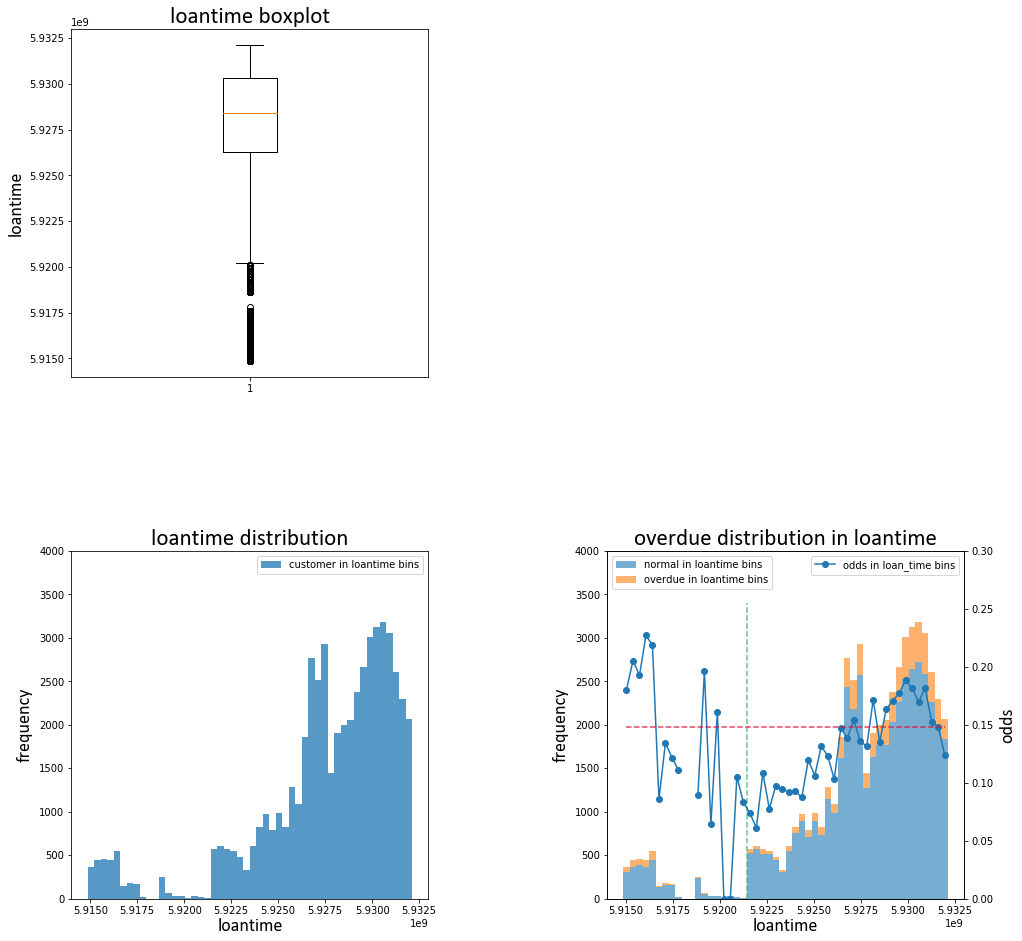

In [80]:
fig2 = plt.figure(figsize = (16,16))

ax1 = fig2.add_subplot(221)
X_loantime = loan_time_train_Y["loan_time"]
ax1.boxplot(X_loantime)  # 做箱线图

ax1.set_title('loantime boxplot',fontdict=font2 ) 
ax1.set_ylabel('loantime',fontdict=font1,labelpad= 6)


ax2 = fig2.add_subplot(223)
n2, bins2, patches2 = ax2.hist(X_loantime, bins=50, alpha=0.75,label="customer in loantime bins")

ax2.set_title('loantime distribution',fontdict=font2 ) 
ax2.set_xlabel('loantime',fontdict=font1,labelpad= 2)  
ax2.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax2.set_ylim(bottom=0 ,top =4000 ) 
#ax2.set_xlim(left=-1, right=5)   
ax2.legend()
 
    
ax3 = fig2.add_subplot(224)
X_loantime_0 = loan_time_train_Y_0["loan_time"]
X_loantime_1 = loan_time_train_Y_1["loan_time"]
n31, bins31, patches31 = ax3.hist(X_loantime_0, bins=50, alpha=0.6,label="normal in loantime bins")
n32, bins32, patches32 = ax3.hist(X_loantime_1, bins=bins31, alpha=0.6, bottom=n31,label="overdue in loantime bins")
# 注意 bottom=n31，这是为了做叠加直方图而设置的。调用 ax.hist 创建直方图，会返回 3个返回值，第一个返回值 n 就是一个向量，记录了这个直方图
# 的每个柱子的高度，即对应的纵坐标（其实就是每个区间所含的样本频数）。而想做叠加的直方图，可以再使用一条 ax.hist语句，将 bottom设置为
# 上一个图返回的 n，那第二个直方图的每个柱子的基底高度，就是这个 n 。而 bins31返回的是 50个区间的端点，是一个 list，共含 51 个值。
# 叠加直方图也可以通过 把数据变成多维，然后用 stacked 参数设定。

ax3.set_title('overdue distribution in loantime',fontdict=font2 ) 
ax3.set_xlabel('loantime',fontdict=font1,labelpad= 2)  
ax3.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax3.set_ylim(bottom=0 ,top =4000)
ax3.legend(loc=2)
ax3.plot([5921422287.0]*35,[i for i in range(0,3500,100)],color="mediumseagreen",alpha=0.8, linestyle="--")
# 这条画的是绿线，表示 loan_time大部分分布与绿线右侧。这条线主要是和 以后的各个表的时间字段进行比较的。bins2[19]的值为 5921422287.0，即横坐标值。

bin_mid=[]
for i in range(len(bins32)-1):             # 调用 hist 作图返回的 bin32 是50个区间的共51个端点，通过这些端点可求出每个区间的中间点，存在bin_mid里。
    bin_mid.append((bins32[i]+bins32[i+1])/2)  # 此for循环将50个区间的每个区间的中点计算出来，存储到列表 bin_mid 中。
odds_in_bins=[]
for i in range(len(n31)):            # 调用 hist 作图返回的 n31 是每个区间里的样本频数，共50个数值。所以，n31是每个区间里正常的频数，
    odds_in_bins.append(n32[i]/n31[i])  # n32是每个区间里违约的频数，相除得到此区间里的 odds值。存储在 odds_in_bins 里。
ax3_t = ax3.twinx()
ax3_t.plot(bin_mid, odds_in_bins, label="odds in loan_time bins",marker="o")
ax3_t.plot(bin_mid, [odds]*(len(bin_mid)),color="crimson",alpha=0.8, linestyle="--")
# odds = user_info_train_Y_1.shape[0]/user_info_train_Y_0.shape[0]  此为总数据集中违约人数与正常人数的比值，记为odds。在 user_info作图时已求。
ax3_t.set_ylabel('odds',fontdict=font1,labelpad= 6)
ax3_t.set_ylim(bottom=0 ,top =0.3)
ax3_t.legend(loc=1)



plt.subplots_adjust(wspace = 0.5, hspace =0.5)  # 调整每个子图之间的距离    
plt.show()

结论：  
&ensp;&ensp;由箱线图和直方图可知，总训练集样本在loan_time字段上分布十分有偏，loantime值较大时分布得更多。左侧为直方图，反映每个分箱内的总客户频数。右侧叠加直方图里，蓝色块为loan_time的每个分箱（默认分为50箱）里的正常客户的频数，橙色为相应分箱里违约客户的频数。而蓝色折线，每个节点表示这个分箱里的odds值，即此分箱里，违约客户数与正常客户数的比值。而红色横线，则是总训练集的odds，即总训练集中，违约用户数与正常用户数的比值。通过比较不同分箱的odds值大小，并与总训练集的odds比较（红色横线），看这个分箱的偏向。比如高过红线，说明这个分箱里的违约正常比 比 总训练集的违约正常比要高，说明如果某个样本在loan_time字段是落入这个分箱，则倾向于预测为违约人。低于红线，说明这个分箱里的违约正常比 比 总训练集的违约正常比要低，说明如果某个样本在loan_time字段是落入这个分箱，则倾向于预测为正常。可见，频数较少的loan_time段（即低loan_time时），odds值波动幅度非常大。高loan_time段时较为稳定。绿线是我自己补充的，表示大部分loantime都位于绿线右侧。另外，左右两图对应。

&ensp;&ensp;是否需要把loan_time较小的那些人删掉？尤其是低于59200的。从n2可以看出这些bins中这些人的频数。其实箱线图提示，低于59200的是异常点。但那加起来有2000条数据。

&ensp;&ensp;使用scipy的Kolmogorov-Smirnov 检验（正态性检验）判断训练集的loan_time字段是否符合正态分布。

In [81]:
n2

array([ 360.,  446.,  458.,  443.,  546.,  152.,  177.,  175.,   20.,
          0.,    0.,  256.,   61.,   33.,   36.,   14.,   27.,   21.,
         13.,  567.,  607.,  572.,  555.,  484.,  336.,  605.,  823.,
        970.,  796.,  989.,  825., 1286., 1092., 1856., 2767., 2517.,
       2926., 1446., 1904., 2003., 2057., 2380., 2662., 3006., 3120.,
       3181., 3060., 2606., 2297., 2063.])

In [82]:
bins2[19]

5921422287.0

In [83]:
loan_time_train_Y["loan_time"].describe()

count    5.559600e+04
mean     5.927564e+09
std      3.754645e+06
min      5.914856e+09
25%      5.926261e+09
50%      5.928421e+09
75%      5.930321e+09
max      5.932136e+09
Name: loan_time, dtype: float64

In [84]:
loan_time_train_Y["loan_time"].std()

3754644.501419612

In [85]:
scipy.stats.kstest(loan_time_train_Y["loan_time"],"norm",(loan_time_train_Y["loan_time"].mean(),loan_time_train_Y["loan_time"].std()))

# kstest(x,"norm",(均值，标准差)) 检验 数组 x 是否服从某均值，某标准差的正态分布。返回一个元组，第一个值是统计量值，第二个即p。
# p>0.05，即可认为符合正态性。 可见，不符合正态性。


KstestResult(statistic=0.1263615807917916, pvalue=0.0)

<font face="微软雅黑" size=5> 结论： </font>

&ensp;&ensp;结合 Kolmogorov-Smirnov 检验 和 箱线图、直方图、叠加直方图、odds折线，可见 训练集的 loan_time 字段（连续型数值型字段）的分布是有偏的，不符合正态性。且低loan_time时，odds波动非常大。 没有看到明显的异常点。

### 3.2.3 bank_detail

思路：  
&ensp;&ensp;因为只有14.39% 的用户有 bank_detail 信息，而且拥有这些信息的用户，每个用户拥有不等的多条记录。所以不好进行描述统计。这里我们只对bank_time，transaction_amount这两个连续变量进行描述统计，重点是看是否有异常值（箱图、直方图）。然后对transaction_type和salary_income这两个类别变量看一下有没有异常标记。

In [86]:
# 将 bank_detail_train与overdue_train按 userID 左右链接再排序，结果用 bank_detail_train_Y表示。（带Y表示带违约标记列）


bank_detail_train_Y = bank_detail_train.join(overdue_train).sort_index()
bank_detail_train_Y.head(6)

# 注意，bank_detail_train 的索引 userID 有重复，所以合并时要用 .join函数 或 pd.merge 。
# 也可以用： pd.merge(bank_detail_train.reset_index(),overdue_train.reset_index(),how="left",on="userID")

,bank_time,transaction_type,transaction_amount,salary_income,target
userID,,,,,
1,5885047887,0,15.963615,0,0
1,5885047887,1,15.963615,0,0
1,5885307087,0,14.855275,0,0
1,5885307087,1,14.855275,0,0
1,5887035087,0,15.539122,0,0
1,5887035087,1,14.162128,0,0


In [87]:
bank_detail_train_Y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6070197 entries, 1 to 55587
Data columns (total 5 columns):
bank_time             int64
transaction_type      int64
transaction_amount    float64
salary_income         int64
target                int64
dtypes: float64(1), int64(4)
memory usage: 277.9 MB


In [88]:
bank_detail["transaction_type"].value_counts()  # 此字段没有异常标记。

1    4621043
0    1825563
Name: transaction_type, dtype: int64

In [89]:
bank_detail["salary_income"].value_counts()  # 此字段没有异常标记。

0    6407901
1      38705
Name: salary_income, dtype: int64

In [90]:
# 之前“3.1.2”分析过，只有 14.39% 的用户有 bank_detail 信息。
# bank_detail_train_Y 的索引是有重复的，对其按照 userID 进行 groupby并取 size，看到有 bank_detail 信息的用户，少则有几十条，多则上千条。

tmp6 =  bank_detail_train_Y.reset_index().groupby(by="userID",as_index=False)
tmp6.size()

userID
1          86
3         679
4         291
9          24
10        324
14       1250
16        110
21        827
22         28
23        549
25        620
26         47
29        926
31       1865
32        346
33        735
35         78
36       1487
37        627
38        394
41        330
44         85
46        392
47       1223
48       2100
49        651
50        860
52         98
53       1246
55        343
         ... 
55376     257
55384     192
55390     368
55409     928
55413    1676
55423     385
55429     501
55435     141
55440     351
55450     525
55464    1019
55471     370
55478     187
55482     275
55488     825
55496     468
55498    2410
55504      64
55505     483
55518     752
55522     355
55527      65
55539     153
55544     991
55545     104
55547     183
55571      12
55583     460
55586     305
55587     519
Length: 9294, dtype: int64

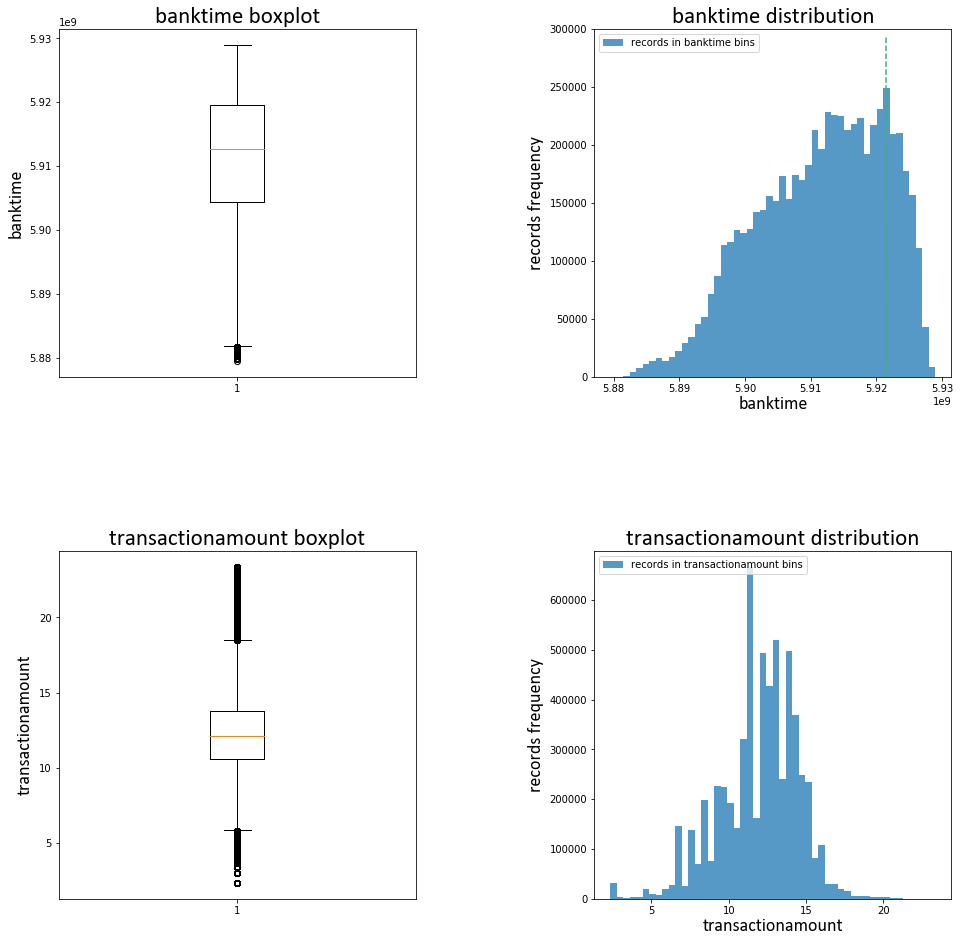

In [91]:
# 注意，bank_time 里，时间未知用 0 表示，所以作图时，把 0 去掉了。

fig3 = plt.figure(figsize = (16,16))

ax1 = fig3.add_subplot(221)
X_banktime = bank_detail_train_Y.loc[bank_detail_train_Y["bank_time"]!=0,"bank_time"]  # 去掉表示时间未知的 0 。
ax1.boxplot(X_banktime)  # 做箱线图

ax1.set_title('banktime boxplot',fontdict=font2 ) 
ax1.set_ylabel('banktime',fontdict=font1,labelpad= 6)


ax2 = fig3.add_subplot(222)
n2, bins2, patches2 = ax2.hist(X_banktime, bins=50, alpha=0.75,label="records in banktime bins")  # 做直方图

ax2.set_title('banktime distribution',fontdict=font2 ) 
ax2.set_xlabel('banktime',fontdict=font1,labelpad= 2)  
ax2.set_ylabel('records frequency',fontdict=font1,labelpad= 6)
ax2.set_ylim(bottom=0 ,top =300000 ) 
#ax2.set_xlim(left=-1, right=5)   
ax2.legend(loc=2)
ax2.plot([5921422287.0]*60,[i for i in range(0,300000,5000)],color="mediumseagreen", linestyle="--")
# 这条画的是绿线，表示 loan_time表中 的loantime大部分位于绿线右侧。
# bank_detail表中，banktime大部分分布于绿线左侧，说明大部分banktime小于loantime。


ax3 = fig3.add_subplot(223)
X_transactionamount = bank_detail_train_Y["transaction_amount"]  
ax3.boxplot(X_transactionamount)  # 做箱线图

ax3.set_title('transactionamount boxplot',fontdict=font2 ) 
ax3.set_ylabel('transactionamount',fontdict=font1,labelpad= 6)


ax4 = fig3.add_subplot(224)
n2, bins2, patches2 = ax4.hist(X_transactionamount, bins=50, alpha=0.75,label="records in transactionamount bins")  # 做直方图

ax4.set_title('transactionamount distribution',fontdict=font2 ) 
ax4.set_xlabel('transactionamount',fontdict=font1,labelpad= 2)  
ax4.set_ylabel('records frequency',fontdict=font1,labelpad= 6)
#ax4.set_ylim(bottom=0 ,top =300000) 
#ax4.set_xlim(left=-1, right=5)   
ax4.legend(loc=2)



plt.subplots_adjust(wspace = 0.5, hspace =0.5)  # 调整每个子图之间的距离    
plt.show()

<font face="微软雅黑" size=5> 结论： </font>  
&ensp;&ensp;从箱线图和直方图可以看出。bank_time的分布是有偏的，绿线是loan_time表中的，表示训练集用户的loantime大部分分布于绿线右侧。但是，收集到的多数记录的bank_time却位于绿线左侧，说明收集到的 银行交易的时间戳（banktime）大部分要早于 放款时间（loantime）。  
&ensp;&ensp;transaction_amount的分布基本是无偏的，但值较少和较多的都有。没有明显的极端值。

### 3.2.4 browse_history

思路：  
&ensp;&ensp;因为有85.37% 的用户有 browse_history 信息，比较多，而且拥有这些信息的用户，每个用户拥有不等的多条记录。所以不好进行描述统计。这里我们只对browse_time，browse_behavior这两个连续变量进行描述统计，重点是看是否有异常值（箱图、直方图）。然后对browse_num这个类别变量看一下有没有异常类别标记。

In [92]:
# 将 browse_history_train与overdue_train按 userID 左右链接再排序，结果用 browse_history_train_Y表示。（带Y表示带违约标记列）


browse_history_train_Y = browse_history_train.join(overdue_train).sort_index()
browse_history_train_Y.head(6)

# 注意，browse_history_train 的索引 userID 有重复，所以合并时要用 .join函数 或 pd.merge 。
# 也可以用： pd.merge(browse_history_train.reset_index(),overdue_train.reset_index(),how="left",on="userID")

,browse_time,browse_behavior,browse_num,target
userID,,,,
2,5907360322,45,1,0
2,5907360322,118,1,0
2,5907360322,50,6,0
2,5907360322,190,10,0
2,5907360322,139,4,0
2,5907360322,173,1,0


In [93]:
browse_history_train_Y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22919547 entries, 2 to 55596
Data columns (total 4 columns):
browse_time        int64
browse_behavior    int64
browse_num         int64
target             int64
dtypes: int64(4)
memory usage: 874.3 MB


In [94]:
browse_history_train_Y["browse_num"].value_counts()  # 此字段没有异常类别标记

1     10770232
4      3445594
7      2384705
5      1980083
6      1774877
10     1586227
8       778282
3       184849
9        12546
11        1306
2          846
Name: browse_num, dtype: int64

In [95]:
# browse_history_train_Y 的索引是有重复的，对其按照 userID 进行 groupby并取 size，看到有 browse_history信息的用户，少则有几十条，多则上千条。

tmp13 = browse_history_train_Y.reset_index().groupby(by="userID",as_index=False)
tmp13 = tmp13.size()
print("max:%d, min:%d, median:%d, mean:%d" % (np.max(tmp13),np.min(tmp13),np.median(tmp13),np.mean(tmp13)))
tmp13


max:33972, min:1, median:294, mean:484


userID
2        1305
3         342
4         364
6          15
7        1008
8        1111
10        320
12        516
14        208
15        154
16        153
17       2478
18        100
19       2025
20        594
21        348
22        160
23        348
24        189
25        308
28       1440
29        275
30        378
31        606
32         96
33        182
34        350
35        154
36       1140
37        312
         ... 
55564    1210
55565     301
55566     180
55567     602
55569     871
55570     154
55571     402
55572     414
55573     230
55574     270
55576     630
55577     448
55578      80
55579     759
55580     531
55581     990
55582     432
55583     152
55584     728
55585     141
55586     770
55587     136
55588     568
55589     364
55590     168
55592     396
55593     179
55594     960
55595     630
55596     120
Length: 47330, dtype: int64

In [96]:
# 注意，这个 browse_behavior到底是个连续变量还是离散变量？对它value_counts，发现它只有214个值，看起来像离散变量。
# 但是这也类别也太多了，我还是倾向于它是连续变量，可能是每次 browse持续的秒数，如果是这样，那可以理解为连续变量。
# 每次 browse持续 0~214 秒。

browse_history_train_Y["browse_behavior"].value_counts().shape

(214,)

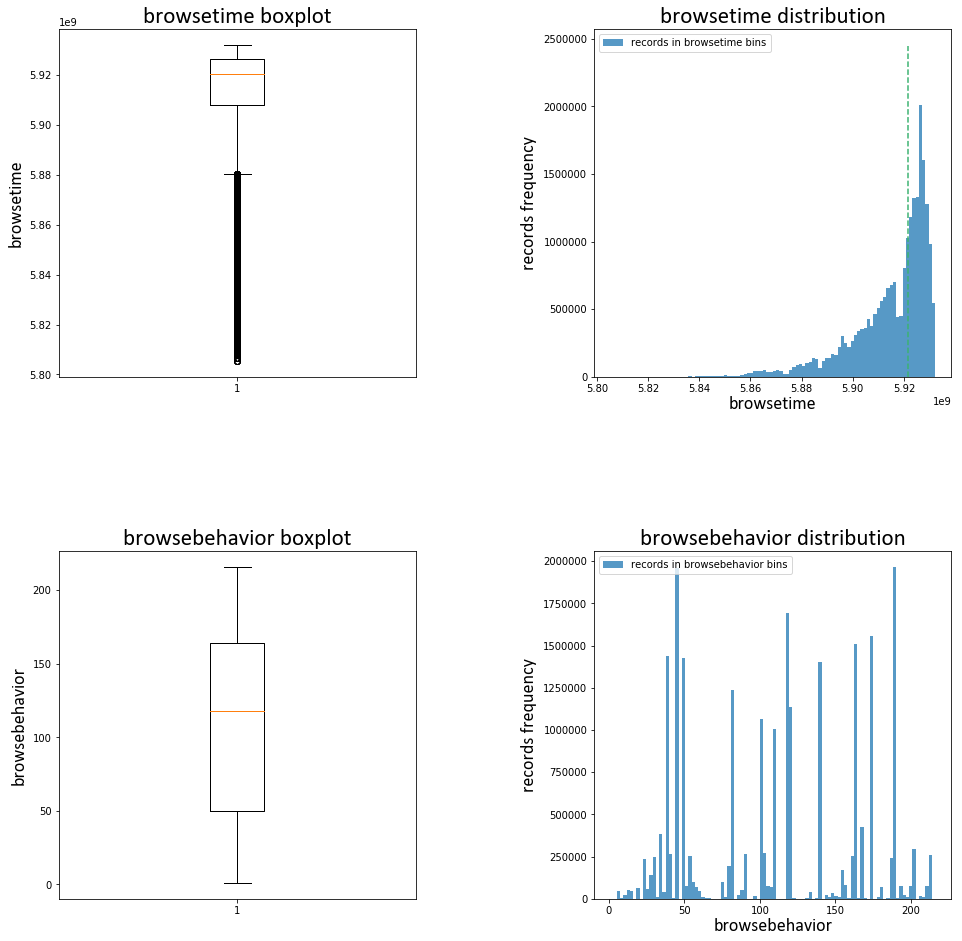

In [97]:
# 注意，browse_time 里，时间未知用 0 表示，所以作图时，把 0 去掉了。

fig6 = plt.figure(figsize = (16,16))

ax1 = fig6.add_subplot(221)
X_browsetime = browse_history_train_Y.loc[browse_history_train_Y["browse_time"]!=0,"browse_time"]  # 去掉表示时间未知的 0 。
ax1.boxplot(X_browsetime)  # 做箱线图

ax1.set_title('browsetime boxplot',fontdict=font2 ) 
ax1.set_ylabel('browsetime',fontdict=font1,labelpad= 6)


ax2 = fig6.add_subplot(222)
n2, bins2, patches2 = ax2.hist(X_browsetime, bins=100, alpha=0.75,label="records in browsetime bins")  # 做直方图

ax2.set_title('browsetime distribution',fontdict=font2 ) 
ax2.set_xlabel('browsetime',fontdict=font1,labelpad= 2)  
ax2.set_ylabel('records frequency',fontdict=font1,labelpad= 6)
#ax2.set_ylim(bottom=0  ,top =300000) 
#ax2.set_xlim(left=-1, right=5)   
ax2.legend(loc=2)
ax2.plot([5921422287.0]*50,[i for i in range(0,2500000,50000)],color="mediumseagreen", linestyle="--")
# 这条画的是绿线，表示 loan_time表中的loantime大部分位于绿线右侧。
# browse_history_train表中 browsetime小部分分布于绿线右侧，大部分位于绿线左侧。说明大部分browsetime小于loantime。


ax3 = fig6.add_subplot(223)
X_browsebehavior = browse_history_train_Y["browse_behavior"]  
ax3.boxplot(X_browsebehavior)  # 做箱线图

ax3.set_title('browsebehavior boxplot',fontdict=font2 ) 
ax3.set_ylabel('browsebehavior',fontdict=font1,labelpad= 6)


ax4 = fig6.add_subplot(224)
n2, bins2, patches2 = ax4.hist(X_browsebehavior, bins=100, alpha=0.75,label="records in browsebehavior bins")  # 做直方图

ax4.set_title('browsebehavior distribution',fontdict=font2 ) 
ax4.set_xlabel('browsebehavior',fontdict=font1,labelpad= 2)  
ax4.set_ylabel('records frequency',fontdict=font1,labelpad= 6)
#ax4.set_ylim(bottom=0 ,top =300000) 
#ax4.set_xlim(left=-1, right=5)   
ax4.legend(loc=2)



plt.subplots_adjust(wspace = 0.5, hspace =0.5)  # 调整每个子图之间的距离    
plt.show()

<font face="微软雅黑" size=5> 结论： </font>  
&ensp;&ensp;从箱线图和直方图可以看出。browse_time的分布是非常有偏的，绿线是loan_time表中的，表示训练集用户的loantime大部分分布于绿线右侧。但是，收集到的多数记录的browse_time却位于绿线左侧，说明收集到的 浏览行为的时间戳（browse_time）大部分要早于 放款时间（loantime）。  
&ensp;&ensp;browse_behavior的分布基本是无偏的，但值较少和较多的都有。没有明显的极端值。

###  3.2.5 bill_detail

&ensp;&ensp;有96.15%的用户有bill_detail信息，比较多。  
1. 对每个字段进行分析，包括取值范围、正值、0值、负值 各为多少。这里，我提取了有不该有的负值的记录条目，可在之后删除。
2. 拥有这些信息的用户，每个用户拥有不等的多条记录。所以不好进行描述统计。这里只对repay_status这个类别变量看一下有没有异常类别标记。

In [98]:
bill_detail.head()

,userID,bill_time,bankID,last_bill_amount,last_repay_amount,credit_limit,current_bill_balance,current_bill_minrepay,consume_num,current_bill_amount,adjust_amount,cyclic_interest,available_balance,borrow_cash,repay_status
0,2,5925655887,4,18.647124,18.988680,19.971271,19.115077,16.815370,0,19.342198,0.0,0.0,0.0,0.0,0
1,2,5904923847,4,17.389606,17.389606,19.460445,16.656269,15.366101,1,16.656269,0.0,0.0,0.0,0.0,0
2,2,5907300387,4,16.656269,17.402921,19.460445,19.393161,17.092432,4,19.462586,0.0,0.0,0.0,0.0,0
3,2,5908250547,16,21.580308,21.600903,0.000000,21.578907,18.590958,3,21.599530,0.0,0.0,0.0,0.0,0
4,2,5909977167,4,19.393161,19.446400,19.460445,19.307760,17.123958,5,19.365610,0.0,0.0,0.0,0.0,0


In [99]:
# 本表一共收录了（训练集+未知数据集用户）信用卡信息的 2753013 条记录。
bill_detail.shape

(2753013, 15)

In [100]:
# 检查各列有没有 缺失值，使用自定义 Calnan 函数。可见，bill_detail 表无缺失值。

CF.Calnan(bill_detail)

,column_name,nancount,nanpercent
0,userID,0,0.0
1,bill_time,0,0.0
2,bankID,0,0.0
3,last_bill_amount,0,0.0
4,last_repay_amount,0,0.0
5,credit_limit,0,0.0
6,current_bill_balance,0,0.0
7,current_bill_minrepay,0,0.0
8,consume_num,0,0.0
9,current_bill_amount,0,0.0


In [101]:
# 可见，bankID这个字段，共有 30 家银行，每家银行的 bill_detail条目数由 1 条 到 47万条不等。

tmp22 = bill_detail["bankID"].value_counts()
print("shape:  ", tmp22.shape)
tmp22

shape:   (30,)


7         474059
14        321501
4         265487
16        254817
6         252490
3         221589
10        219036
8         136216
2         135156
11        134957
13         96707
15         94323
9          90907
5          49263
1           3999
12          1813
510014       308
510016       130
510033       117
510057        51
510044        24
510025        19
510022        14
510050        10
510037         6
510026         5
510024         3
510017         3
510053         2
510027         1
Name: bankID, dtype: int64

In [102]:
# 定义了一个计算 值域和负值比例的函数 Calvalues。
# df 是待计算的 dataframe，本函数可以计算 df 的每一列的最大最小值、中位数均数、负值个数、负值占此列值总个数
# （也就是df的总条目数）的比例、零值个数、零值比例。
# 返回的是一个 dataframe，有九列，第一列是 df的每个列名，第二列 至 第九列 是df的每个列字段的统计量。



def Calvalues(df):
    num = df.shape[0]   # df 的总条目数
    outcome = []
    for i in df.columns:   # 对 df 的每列进行循环
        maxvalue = np.max(df[i])
        minvalue = np.min(df[i])
        medianvalue = np.median(df[i])
        meanvalue = np.mean(df[i])
        negativevaluecount = df.loc[df[i]<0,:].shape[0]   # : 处应是：不应是 df[i]，否则报错。可能和格式有关系。
        negativevaluepercent = negativevaluecount/num
        negativevaluepercent = "%.2f%%" % (negativevaluepercent * 100)
        zerocount = df.loc[df[i]==0,:].shape[0]
        zerocountpercent = zerocount/num
        zerocountpercent = "%.2f%%" % (zerocountpercent * 100)
        outcome.append([i,maxvalue,minvalue,medianvalue,meanvalue,negativevaluecount,negativevaluepercent,zerocount,zerocountpercent])
    return pd.DataFrame(outcome,columns=["column_name","max","min","median","mean","Negative_count","Negative_percent","Zero_count","Zero_percent"])


In [103]:
# 检查 bill_detail 表的值构成，用自定义Calvalues函数，主要关注负值所占的比例。

Calvalues(bill_detail)

,column_name,max,min,median,mean,Negative_count,Negative_percent,Zero_count,Zero_percent
0,userID,6.949500e+04,2.000000,3.178700e+04,3.260285e+04,0,0.00%,0,0.00%
1,bill_time,5.952662e+09,0.000000,5.908880e+09,4.899479e+09,0,0.00%,471009,17.11%
2,bankID,5.100570e+05,1.000000,7.000000e+00,1.370794e+02,0,0.00%,0,0.00%
3,last_bill_amount,2.526977e+01,-24.065627,1.958867e+01,1.425280e+01,65080,2.36%,671942,24.41%
4,last_repay_amount,2.833647e+01,-24.883935,1.842762e+01,1.375448e+01,9814,0.36%,754353,27.40%
5,credit_limit,2.636820e+01,-22.435719,2.015359e+01,1.664563e+01,121,0.00%,513333,18.65%
6,current_bill_balance,2.554132e+01,-23.617187,2.006901e+01,1.883153e+01,57990,2.11%,56601,2.06%
7,current_bill_minrepay,2.472062e+01,-22.928628,1.808562e+01,1.701665e+01,20807,0.76%,121093,4.40%
8,consume_num,1.210000e+02,0.000000,0.000000e+00,9.162129e-01,0,0.00%,1788086,64.95%
9,current_bill_amount,2.833647e+01,-22.431884,1.820049e+01,1.289103e+01,3193,0.12%,891382,32.38%


解释说明：  
1. 账单时间bill_time 字段，0值有 17.11%，说明 17.11% 的记录条目都属于“时间未知”，这个比例不算低。
2. 上期账单金额 last_bill_amount大部分是正值，但也有65080条，即2.36%是负值。负值无法理解。24.4%是0，正常，代表上期没有消费。我认为<0的是异常值。
3. 上期还款金额 last_repay_amount 大部分是正值，但也有0.36%的记录是负值。负值无法理解。27.4%是 0，正常，代表上期没有还款。我认为<0 的是异常值。
4. 信用卡额度 credit_limit 大部分是正值，但也有0.00439%是负值。负值无法理解。18.65%为0，正常，如中行准贷记卡，如果开卡时选择透支功能，则具备正值的信用卡额度。如果选择不透支，则额度为0。
5. 本期账单余额 current_bill_balance大部分是正值，但也有2.11%是负值，2.06%是0。可以理解。“本期账单余额”为正表示透支、为负表示溢缴，即卡上存有较多的钱，为零表示平衡。另外，看“可用余额”可知道是否爆卡。
6. 本期最低还款额 current_bill_minrepay大部分是正值，0.76%是负值。负值无法理解。4.40%是0，正常，代表本期无需还款。https://baike.1688.com/doc/view-d22567073.html。https://baike.1688.com/doc/view-d22567073.html，，可能还是在信用卡里存多了钱吧。
7. 消费笔数consume_num 无负值。但有64.95%为0值，说明没有发生消费。
8. 本期账单金额 current_bill_amount大部分是正值，有0.12%负值。负值无法理解。32.38%为0，正常，表示本期无消费。
9. 调整金额 adjust_amount，有0.85%负值。负值无法理解，有97.96%为0，正常。调整金额本身就是退款一类的，没有退款很正常。
10. 循环利息 cyclic_interest 无负值，87.22%为0，表示没有产生循环利息，即没有逾期状况。
11. 可用余额 available_balance 含0.05%负值，正常。96.13%为0值。正常。可用余额为正，表示卡上还有额度可以供你消费；可用余额为负，表示消费超额了，也就是爆卡，需要先还款；为0表示透支额度用完，不能再透支了。
12. 预借现金额度 borrow_cash 无负值，但48.57%都是0，0表示不允许提现。正数表示可以提现的金额。
13. 还款状态 repay_status。这本来就是个0/1类别变量。无负值，99.99%都是0。所以我猜测，0表示还款，1表示不正常，或者说违约。  
  
如何做：  
1. 很多字段的负值无法解释，是否需要删掉这些记录？计算得出，在不该有负值出现的字段出现了负值的条目数占总bill_detail条目数（训练集和未知样本集都有）的 4.3%，我认为可以考虑删掉这些数据。当然也可以不删除。这里我选择删除。

In [104]:
bill_detail.head()

,userID,bill_time,bankID,last_bill_amount,last_repay_amount,credit_limit,current_bill_balance,current_bill_minrepay,consume_num,current_bill_amount,adjust_amount,cyclic_interest,available_balance,borrow_cash,repay_status
0,2,5925655887,4,18.647124,18.988680,19.971271,19.115077,16.815370,0,19.342198,0.0,0.0,0.0,0.0,0
1,2,5904923847,4,17.389606,17.389606,19.460445,16.656269,15.366101,1,16.656269,0.0,0.0,0.0,0.0,0
2,2,5907300387,4,16.656269,17.402921,19.460445,19.393161,17.092432,4,19.462586,0.0,0.0,0.0,0.0,0
3,2,5908250547,16,21.580308,21.600903,0.000000,21.578907,18.590958,3,21.599530,0.0,0.0,0.0,0.0,0
4,2,5909977167,4,19.393161,19.446400,19.460445,19.307760,17.123958,5,19.365610,0.0,0.0,0.0,0.0,0


In [105]:
# 此处计算 bill_detail（包括了训练集和未知样本集）的 2753013 条信用卡记录条目中，在不该有负值出现的字段出现了负值的条目的数目 tmp30，
# 以及它占到总条目数 2753013 的比例。
# 不该有负值出现的字段：上期账单金额、上期还款金额、信用卡额度、本期最低还款额、本期账单金额、调整金额。
# （注意，本期账单余额 和 可用额度 两个字段可以取负值）
# 这个比例是 4.3%，我认为可以考虑删除。


tmp23 = bill_detail.loc[bill_detail["last_bill_amount"]<0,:].index
tmp24 = bill_detail.loc[bill_detail["last_repay_amount"]<0,:].index
tmp25 = bill_detail.loc[bill_detail["credit_limit"]<0,:].index
tmp26 = bill_detail.loc[bill_detail["current_bill_minrepay"]<0,:].index
tmp27 = bill_detail.loc[bill_detail["current_bill_amount"]<0,:].index
tmp28 = bill_detail.loc[bill_detail["adjust_amount"]<0,:].index
tmp29 = set(tmp23.tolist()+tmp24.tolist()+tmp25.tolist()+tmp26.tolist()+tmp27.tolist()+tmp28.tolist())
tmp30 =len(tmp29)
print("The percent of records containing nagative values is : ",tmp30/bill_detail.shape[0])

# 其实用 bill_detail.loc[bill_detail["last_bill_amount"]<0|bill_detail["last_repay_amount"]<0|bill_detail["credit_limit"]<0|bill_detail["current_bill_minrepay"]<0|bill_detail["current_bill_amount"]<0|bill_detail["adjust_amount"]<0,:]
# 也可以


The percent of records containing nagative values is :  0.043305280432747686


In [106]:
# 从 bill_detail 中原地删掉 有无法解释的负值 的记录。

bill_detail.drop(tmp29,axis=0,inplace = True)

In [107]:
# 现在 bill_detail表含的信用卡记录数是 2633793 个。

bill_detail.shape

(2633793, 15)

In [108]:
# 将 bill_detail_train与overdue_train按 userID 左右链接再排序，结果用 bill_detail_train_Y表示。（带Y表示带违约标记列）


bill_detail_train_Y = bill_detail_train.join(overdue_train).sort_index()
bill_detail_train_Y.head(6)


,bill_time,bankID,last_bill_amount,last_repay_amount,credit_limit,current_bill_balance,current_bill_minrepay,consume_num,current_bill_amount,adjust_amount,cyclic_interest,available_balance,borrow_cash,repay_status,target
userID,,,,,,,,,,,,,,,
2,0,4,17.389606,17.389606,19.460445,16.656269,15.366101,1,16.656269,0.0,0.0,0.0,0.0,0,0
2,5904923847,4,17.389606,17.389606,19.460445,16.656269,15.366101,1,16.656269,0.0,0.0,0.0,0.0,0,0
2,5907300387,4,16.656269,17.402921,19.460445,19.393161,17.092432,4,19.462586,0.0,0.0,0.0,0.0,0,0
2,5908250547,16,21.580308,21.600903,0.000000,21.578907,18.590958,3,21.599530,0.0,0.0,0.0,0.0,0,0
2,5909977167,4,19.393161,19.446400,19.460445,19.307760,17.123958,5,19.365610,0.0,0.0,0.0,0.0,0,0
2,5910282927,9,20.210676,19.484314,19.971271,18.503332,-16.372597,0,18.846725,0.0,0.0,0.0,0.0,0,0


In [109]:
# bill_detail_train_Y 的索引是有重复的，对其按照 userID 进行 groupby并取 size，看到有 bill_detail 信息的训练集用户，
# 少则仅有 1 条，多则七千多条，但是平均只有 43条。

tmp31 = bill_detail_train_Y.reset_index().groupby(by="userID",as_index=False)
tmp32 = tmp31.size()
print("max:%d, min:%d, median:%d, mean:%d" % (np.max(tmp32),np.min(tmp32),np.median(tmp32),np.mean(tmp32)))
tmp32

max:7544, min:1, median:20, mean:43


userID
2          23
3           2
4          36
5           2
6          42
7         111
8           4
9          22
10        200
11         12
12         51
13         60
14         17
15          7
16         31
17        169
18         93
19         45
20         12
21         15
22          3
23         18
24       1031
25          8
26         36
27         30
28          7
29         14
30         21
32          7
         ... 
55564       9
55565      43
55566      88
55567       3
55568       2
55569      37
55570       5
55571      19
55572       8
55573       6
55574      84
55575       1
55576       3
55577       1
55578      13
55579      20
55580       5
55581       3
55582       3
55584      13
55585       3
55588     134
55589      23
55590       7
55591      57
55592       8
55593      59
55594      24
55595      56
55596       8
Length: 53174, dtype: int64

In [110]:
# 对repay_status这个类别变量看一下有没有异常类别标记
# 可见，均为 0/1类别，无特殊标记。正常。

bill_detail["repay_status"].value_counts()

0    2633490
1        303
Name: repay_status, dtype: int64

# 4. 特征工程

1. bank_detail, browse_history, bill_detail 三张长表 因为含有重复的userID，也就是同一userID有多行记录，所以需要进行 数据整合（groupby），得到一个userID只有一条记录。这个过程涉及到新变量的创建，所以纳入特征工程的一部分。  
2. user_info, loan_time, overdue 三张长表的userID列都是唯一的且排序的，所以无需处理。
3. 附加：按说未知样本集不能参与建模，而是一定要等模型建好以后，在未知样本集上实验。 但是，如果是对特征的转换，每种转变只局限在每个userID内部，则我认为训练集和未知样本集可以一起，如onehot，可以把训练集onehot的标准用到未知样本集上，对它的离散特征也onehot。此时训练集和未知样本集可以一起转化。 但如果是涉及到整个特征的转换就不能够训练集和未知样本集一起了，如训练集上的连续特征，标准化，得到均值方差，把这个均值方差用在未知样本集上，对它的连续特征进行转换。千万不能对训练集和未知样本集的某个特征一起求方差。 

## 4.1 bank_detail 整合
 
&ensp;&ensp;bank_detail信息以后要整合到总表里，每个用户一条记录。而有bank_detail信息的用户只有14.39% 太少，则一定产生大量缺失值。用特殊值/算法填充这些缺失不现实，我认为也会干扰建模，还是不填充，而是将缺失作为一个类别进行标记。但是，  
1. 只有salary_income，transaction_type是类别型变量，再加一个“缺失类别”是OK的，然后onehot。  
2. 但 bank_time，transaction_amount是连续数值变量，那就成了此变量有两类别：缺失、不缺失，而“不缺失”本身是连续数值，这显然是不可以的。我认为可以用MDLP算法先对此连续变量最优分箱离散化，然后再加上“缺失类别”即可，这样onehot之后只会损失连续变量对应的那些分箱之间的顺序关系。
3. 还是因为拥有bank_detail信息的用户太少，我认为不宜对bank_detail再创建过多新特征，因为这样onehot后会有用户在更多的特征上本质为缺失，我认为也不利于建模。所以不再根据bank_time划分放款前后进行特征工程。只做最基本的特征工程即可，如对收入/支出的分析，对工资的分析等。
4. 注意，如果只是构建特征，则可以训练集与未知数据集一起，创建特征方便。如果是转换特征，需要用到某个特征的统计数据时（如均值方差），则一定要把训练集和未知数据集分隔开，在训练集上计算这些统计量，转换训练集，然后把这些统计量用到未知数据集上，转换未知数据集。

### 4.1.1 groupby and feature creation 
1. 将 bank_detail表（包含训练集和未知样本集）按照 userID 进行groupby，每个 userID 对应多行记录。
2. bank_time字段：每个 userID 对应多条记录，但考虑到有些“时间未知”用0表示，所以求sum或求mean都不太好，决定删掉此字段，不采纳其信息；创建字段“record_count”保存每个userID拥有的记录条目数。
3. transaction_type, transaction_amount, salary_income字段：统计每个ID的 支出sum，count(支出笔数)；收入sum，count；工资收入sum,工资收入mean(即工资sum/工资count，得到每笔工资平均值)；工资收入占收入比例（工资sum/收入sum）；支出占收入比例（支出sum/收入sum）；
4. 以上涉及到的都是对每个用户自身进行统计，所以训练集和未知样本集放在一起处理是OK的。

In [111]:
bank_detail.head(5)

,userID,bank_time,transaction_type,transaction_amount,salary_income
0,1,5912436687,1,2.344542,0
1,1,5895415887,1,15.855337,0
2,1,5895415887,0,15.855337,0
3,1,5895502287,1,15.953887,0
4,1,5895502287,0,15.953887,0


In [112]:
print("There are %d customers has bank_detail info." % len(np.unique(bank_detail["userID"])))

There are 10003 customers has bank_detail info.


In [113]:
# 按 userID 进行 groupby，并使用 size 统计每个ID的记录数。并改列名。
# 字段说明：
# bank_detail_record_count  每个userID拥有的bank_detail信息的条目数。


bank_record_count = bank_detail.groupby(by="userID",as_index=False).size()
bank_record_count.name = "bank_detail_record_count"
bank_record_count = bank_record_count.reset_index()
print("shape:  ",bank_record_count.shape)
bank_record_count.head()

shape:   (10003, 2)


,userID,bank_detail_record_count
0,1,86
1,3,679
2,4,291
3,9,24
4,10,324


In [114]:
# 提取 userID和 transaction_type是 “收入” 的行，按 userID 进行 groupby，并使用 sum 和 size 聚合函数。并改列名。
# 字段说明：
# bank_income_sum    每个userID的 总收入。
# bank_income_count  每个userID的 收入笔数。


bank_income_stats = bank_detail.loc[bank_detail["transaction_type"]==0,("userID","transaction_amount")].groupby(by="userID",as_index=False).aggregate([np.sum, np.size])
bank_income_stats.columns = ["bank_income_sum","bank_income_count"]
bank_income_stats = bank_income_stats.reset_index()
print("shape:  ",bank_income_stats.shape)
bank_income_stats.head()

shape:   (10002, 3)


,userID,bank_income_sum,bank_income_count
0,1,480.692762,35.0
1,3,2278.873446,172.0
2,4,1164.342384,96.0
3,9,186.833251,13.0
4,10,1793.642133,141.0


In [115]:
# 提取 userID和 transaction_type是 “支出” 行，按 userID 进行 groupby，并使用 sum 和 size 聚合函数。并改列名。
# 字段说明：
# bank_outcome_sum    每个userID的 总支出。
# bank_outcome_count  每个userID的 支出笔数。


bank_outcome_stats = bank_detail.loc[bank_detail["transaction_type"]==1,("userID","transaction_amount")].groupby(by="userID",as_index=False).aggregate([np.sum, np.size])
bank_outcome_stats.columns = ["bank_outcome_sum","bank_outcome_count"]
bank_outcome_stats = bank_outcome_stats.reset_index()
print("shape:  ",bank_outcome_stats.shape)
bank_outcome_stats.head()

shape:   (9989, 3)


,userID,bank_outcome_sum,bank_outcome_count
0,1,676.025269,51.0
1,3,4985.957607,507.0
2,4,2129.425722,195.0
3,9,141.544665,11.0
4,10,2250.292530,183.0


In [116]:
# 提取 userID和 transaction_type是 “收入” 且 salary_income 为 “工资收入”的行，按 userID 进行 groupby，并使用 sum 和 mean 聚合函数。并改列名。
# 字段说明：
# bank_salaryincome_sum    每个userID的 总工资收入。
# bank_salaryincome_mean  每个userID的 每笔工资的均值。


bank_salaryincome_stats = bank_detail.loc[(bank_detail["transaction_type"]==0)&(bank_detail["salary_income"]==1),("userID","transaction_amount")].groupby(by="userID",as_index=False).aggregate([np.sum, np.mean])
bank_salaryincome_stats.columns = ["bank_salaryincome_sum","bank_salaryincome_mean"]
bank_salaryincome_stats = bank_salaryincome_stats.reset_index()
print("shape:  ",bank_salaryincome_stats.shape)
bank_salaryincome_stats.head()

shape:   (3157, 3)


,userID,bank_salaryincome_sum,bank_salaryincome_mean
0,36,26.086215,13.043108
1,38,21.768781,10.884391
2,44,106.552468,15.221781
3,67,85.972926,12.281847
4,97,65.746786,13.149357


In [117]:
# 将 4 张表依 userID列 merge 起来，得到 bank_detail_stats表。

tmp7 = pd.merge(bank_record_count,bank_income_stats,on="userID",how="left")
tmp8 = pd.merge(tmp7, bank_outcome_stats,on="userID",how="left" )
bank_detail_stats = pd.merge(tmp8, bank_salaryincome_stats, on="userID",how="left" )

print("shape:  ",bank_detail_stats.shape)
bank_detail_stats.head()

shape:   (10003, 8)


,userID,bank_detail_record_count,bank_income_sum,bank_income_count,bank_outcome_sum,bank_outcome_count,bank_salaryincome_sum,bank_salaryincome_mean
0,1,86,480.692762,35.0,676.025269,51.0,NaN,NaN
1,3,679,2278.873446,172.0,4985.957607,507.0,NaN,NaN
2,4,291,1164.342384,96.0,2129.425722,195.0,NaN,NaN
3,9,24,186.833251,13.0,141.544665,11.0,NaN,NaN
4,10,324,1793.642133,141.0,2250.292530,183.0,NaN,NaN


 
&ensp;&ensp;共有10003客户（训练集+未知数据）拥有bank_detail信息，其中，有10002客户拥有“收入”信息，9989客户有“支出”信息，3157客户有“工资信息”。将4张表依 userID字段 merge起来，则“收入、支出”字段的缺失值较少，但“工资”字段的缺失值会很多。采用以下方法：  
1. 创建“支出占收入比例（支出sum/收入sum）”字段，此字段的缺失值也不会太多。
2. 本来还准备创建字段“工资收入占收入比例（工资sum/收入sum）”，但考虑到缺失会很多，遂放弃。
3. “收入sum count、支出sum count、支出占收入比”字段的缺失值较少，采取0填充。（我想用 0 填充。若用其它中位数、均值等填充，则记得先将数据集分离为训练集和未知样本集，再对训练集求中位数，填充训练集缺失，填充未知样本集缺失）
4. “工资信息sum count”缺失太多，采用此方式：删去这两字段，新建字段“是否有工资信息”，有工资信息的记为2，没工资信息的记为1。（而没有bank_detail 信息的 客户，此字段记为0）.  
最终得到没有缺失值的  bank_detail_stats 表，共8 个字段，shape为：(10003, 8)

In [119]:
# 新建 bank_salary_record 列，有工资信息的记为2，没工资信息的记为1，删掉原来的 工资收入sum,mean列。
# 创建支出占收入比字段：bank_out/income
# 收入sum count 和 支出sum count 和 支出占收入比 的缺失值用 0 填充。
# 注意，所谓的每个用户是 训练集和未知数据集里有bank_detail信息的所有用户。

# 此步得到的 bank_detail_stats 的 shape为：(10003, 8)，共 8个字段，分别为：
# userID                     训练集和未知数据集里有bank_detail信息的所有用户
# bank_detail_record_count   每个userID拥有的bank_detail信息的条目数。
# bank_income_sum            每个userID的 总收入。
# bank_income_count          每个userID的 收入笔数。
# bank_outcome_sum           每个userID的 总支出。
# bank_outcome_count         每个userID的 支出笔数。
# bank_salary_record         每个userID 是否有 工资信息（有工资信息的记为2，没工资信息的记为1）
# bank_out/income            每个userID的 支出占收入比
#（本表无缺失值）

bank_detail_stats.loc[bank_detail_stats["bank_salaryincome_sum"].notnull(), "bank_salary_record"] = 2 
bank_detail_stats.loc[bank_detail_stats["bank_salaryincome_sum"].isnull(), "bank_salary_record"] = 1
bank_detail_stats.drop(["bank_salaryincome_sum","bank_salaryincome_mean"],axis=1, inplace=True)

bank_detail_stats["bank_out/income"] = bank_detail_stats["bank_outcome_sum"]/bank_detail_stats["bank_income_sum"]

bank_detail_stats.fillna(0, inplace=True)  # 注意一定要 inplace。否则相当于没填充。


print("shape:  ",bank_detail_stats.shape)
bank_detail_stats.head()

# 用 loc选择有/无工资的，再新建一列bank_salary_record，根据情况给其赋值 2 或 1.
# 注意，判断是否是np.nan，用 .isnull()和 .notnull() 方法，不要用 ==np.nan 或 != np.nan，不管用的。

shape:   (10003, 8)


,userID,bank_detail_record_count,bank_income_sum,bank_income_count,bank_outcome_sum,bank_outcome_count,bank_salary_record,bank_out/income
0,1,86,480.692762,35.0,676.025269,51.0,1.0,1.406356
1,3,679,2278.873446,172.0,4985.957607,507.0,1.0,2.187905
2,4,291,1164.342384,96.0,2129.425722,195.0,1.0,1.828866
3,9,24,186.833251,13.0,141.544665,11.0,1.0,0.757599
4,10,324,1793.642133,141.0,2250.292530,183.0,1.0,1.254594


In [120]:
CF.Calnan(bank_detail_stats) # 说明无缺失值。

,column_name,nancount,nanpercent
0,userID,0,0.0
1,bank_detail_record_count,0,0.0
2,bank_income_sum,0,0.0
3,bank_income_count,0,0.0
4,bank_outcome_sum,0,0.0
5,bank_outcome_count,0,0.0
6,bank_salary_record,0,0.0
7,bank_out/income,0,0.0


### 4.1.2 描述性统计  
&ensp;&ensp;  
1. 将bank_detail_stats表里的训练集部分提取出来，将之和overdue_train表依照userID链接起来，然后，根据某个userID是否违约，提取出违约部分和正常部分。
2. 对正常部分的“支出占收入比”字段做直方图，同时，对违约部分的“支出占收入比”也做直方图，两个直方图在一张图上，观察违约人群与正常人群在此字段上的分布差异。

In [121]:
# 将 bank_detail_stats与overdue_train按 userID 左右链接再排序，结果用 bank_detail_stats_train_Y表示。（带Y表示带违约标记列）
# bank_detail_stats_train_Y 也就是训练集里有bank_detail信息的那些userID的bank_detail_stats，再填上 违约标记列。userID是索引且排序。

bank_detail_stats_train_Y = bank_detail_stats.set_index("userID").join(overdue_train, how = "inner").sort_index() # 注意，how=inner。over_train保证是“训练集”，bank_detail_stats保证有银行信息。
bank_detail_stats_train_Y.head(4)

,bank_detail_record_count,bank_income_sum,bank_income_count,bank_outcome_sum,bank_outcome_count,bank_salary_record,bank_out/income,target
userID,,,,,,,,
1,86,480.692762,35.0,676.025269,51.0,1.0,1.406356,0
3,679,2278.873446,172.0,4985.957607,507.0,1.0,2.187905,0
4,291,1164.342384,96.0,2129.425722,195.0,1.0,1.828866,1
9,24,186.833251,13.0,141.544665,11.0,1.0,0.757599,0


In [122]:
# bank_detail_stats_train_Y_0 是  bank_detail_stats_train_Y里target是0的那些条目，即训练集里有bank信息的且标记为正常的人群。
# bank_detail_stats_train_Y_1 是  bank_detail_stats_train_Y里target是1的那些条目，即训练集里有bank信息的且标记为违约的人群。
# bank_detail_stats_train_Y里，正常的用户为 7834人，违约的为 1460人。

bank_detail_stats_train_Y_0 = bank_detail_stats_train_Y.loc[bank_detail_stats_train_Y["target"]==0,:]
bank_detail_stats_train_Y_1 = bank_detail_stats_train_Y.loc[bank_detail_stats_train_Y["target"]==1,:]
print("The number of customers normal in bank_detail_stats_train_Y is: ", bank_detail_stats_train_Y_0.shape[0])
print("The number of customers overdue in bank_detail_stats_train_Y is: ", bank_detail_stats_train_Y_1.shape[0])

The number of customers normal in bank_detail_stats_train_Y is:  7834
The number of customers overdue in bank_detail_stats_train_Y is:  1460


C:\Users\shuangjun\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


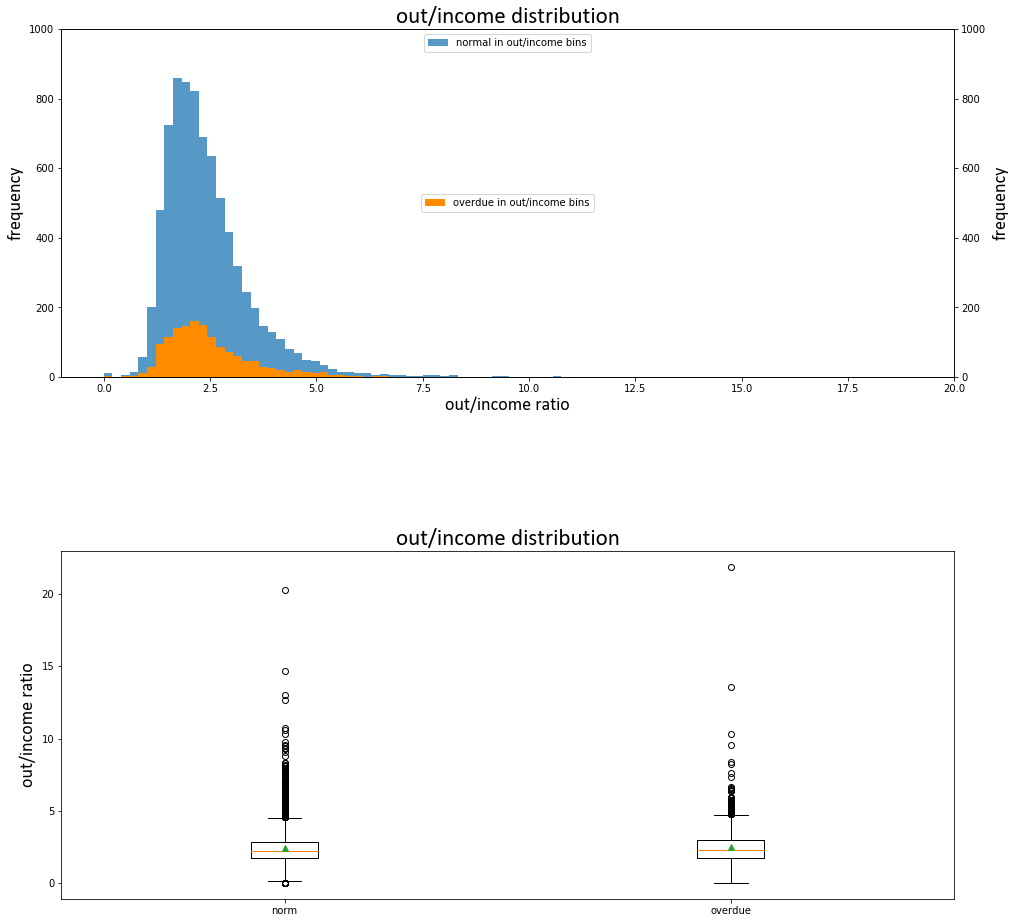

In [123]:
# bank_out/income 字段。

fig4 = plt.figure(figsize = (16,16))

ax1 = fig4.add_subplot(211)
n1, bins1, patches1 = ax1.hist(bank_detail_stats_train_Y_0["bank_out/income"], bins=100, alpha=0.75,label="normal in out/income bins")  # 做直方图
ax2 = ax1.twinx()
n2, bins2, patches2 = ax2.hist(bank_detail_stats_train_Y_1["bank_out/income"], bins=bins1, alpha=1,label="overdue in out/income bins", color="darkorange")  # 做直方图
ax1.set_title('out/income distribution',fontdict=font2 ) 
ax1.set_xlabel('out/income ratio',fontdict=font1,labelpad= 2)  
ax1.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax1.set_ylim(bottom=0 ,top =1000) 
ax1.set_xlim(left=-1, right=20)   
ax1.legend(loc=9)
ax2.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax2.set_ylim(bottom=0 ,top =1000) 
ax2.legend(loc=10)


ax3 = fig4.add_subplot(212)
ax3.boxplot(x= [bank_detail_stats_train_Y_0["bank_out/income"],bank_detail_stats_train_Y_1["bank_out/income"]],showmeans=True)  # 做箱线图
ax3.set_title('out/income distribution',fontdict=font2 ) 
ax3.set_ylabel('out/income ratio',fontdict=font1,labelpad= 6)
ax3.set_xticklabels(["norm","overdue"])


plt.subplots_adjust(wspace = 0.5, hspace =0.5)  # 调整每个子图之间的距离    
plt.show()

In [124]:
n1

array([ 11.,   1.,   6.,  13.,  56., 202., 480., 723., 858., 849., 821.,
       690., 634., 515., 418., 318., 243., 197., 145., 129., 109.,  80.,
        68.,  49.,  47.,  33.,  23.,  14.,  15.,  11.,  11.,   5.,   9.,
         6.,   5.,   2.,   4.,   5.,   7.,   2.,   5.,   1.,   0.,   1.,
         1.,   2.,   2.,   1.,   0.,   0.,   1.,   0.,   2.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         1.])

In [125]:
bins1

array([ 0.        ,  0.20299446,  0.40598891,  0.60898337,  0.81197783,
        1.01497229,  1.21796674,  1.4209612 ,  1.62395566,  1.82695012,
        2.02994457,  2.23293903,  2.43593349,  2.63892795,  2.8419224 ,
        3.04491686,  3.24791132,  3.45090578,  3.65390023,  3.85689469,
        4.05988915,  4.2628836 ,  4.46587806,  4.66887252,  4.87186698,
        5.07486143,  5.27785589,  5.48085035,  5.68384481,  5.88683926,
        6.08983372,  6.29282818,  6.49582264,  6.69881709,  6.90181155,
        7.10480601,  7.30780047,  7.51079492,  7.71378938,  7.91678384,
        8.1197783 ,  8.32277275,  8.52576721,  8.72876167,  8.93175612,
        9.13475058,  9.33774504,  9.5407395 ,  9.74373395,  9.94672841,
       10.14972287, 10.35271733, 10.55571178, 10.75870624, 10.9617007 ,
       11.16469516, 11.36768961, 11.57068407, 11.77367853, 11.97667299,
       12.17966744, 12.3826619 , 12.58565636, 12.78865081, 12.99164527,
       13.19463973, 13.39763419, 13.60062864, 13.8036231 , 14.00

&ensp;&ensp;前两幅图是训练集里有bank信息的客户中，在“bank_out/income”字段上是 正常 和 违约 两种情况的分布。（注意，直方图里并没有叠加，而是正常的分布 与 违约的分布 画在了一起）。可见，大部分用户，不论正常/违约，其“支出收入比值”都在0~6.5之间，即支出是收入的0~6.5倍。但是，有个别客户，其支出收入比到了更高的10~20倍，这些我认为太异常了，建议删去。bank_detail_stats_train_Y_0中，大于6.5的有60个，bank_detail_stats_train_Y_1中，大于6.5的有11个。所以一共有 71 个异常的userID，存储在bank_train_outincome_ratio_outlier里。


In [126]:
# tmp10是训练集里有bank信息的客户中，在“bank_out/income”字段上是 正常 的客户里“支出收入比”大于 6.5的客户。
# tmp11是训练集里有bank信息的客户中，在“bank_out/income”字段上是 违约 的客户里“支出收入比”大于 6.5的客户。
# bank_train_outincome_ratio_outlier是训练集里有bank信息的客户中，“支出收入比”大于 6.5的客户，算异常用户，应删去。

tmp10 = bank_detail_stats_train_Y_0.loc[bank_detail_stats_train_Y_0["bank_out/income"]>6.5,"bank_out/income"]
tmp11 = bank_detail_stats_train_Y_1.loc[bank_detail_stats_train_Y_1["bank_out/income"]>6.5,"bank_out/income"]
bank_train_outincome_ratio_outlier = pd.concat([tmp10,tmp11],axis=0).index
print("The number of outliers in out/income is:", len(bank_train_outincome_ratio_outlier))

The number of outliers in out/income is: 71


In [127]:
bank_train_outincome_ratio_outlier

Int64Index([   26,   165,   637,  1101,  1124,  1134,  1873,  2089,  2174,
             2330,  2531,  2674,  3340,  3524,  3540,  3706,  4375,  5037,
             5064,  5079,  5151,  5173,  5227,  5426,  5531,  6226,  6300,
             6461,  6672,  7627,  7711,  8119,  8583,  8815,  9091,  9200,
            10105, 10248, 11764, 15078, 16289, 16696, 17848, 19288, 19764,
            21983, 22205, 24290, 25801, 26868, 27654, 27665, 30195, 32095,
            40264, 48241, 49010, 52013, 53240, 55496,   792,  3422,  4263,
             6225,  6654,  6904, 24139, 31456, 33725, 37358, 43566],
           dtype='int64', name='userID')

C:\Users\shuangjun\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


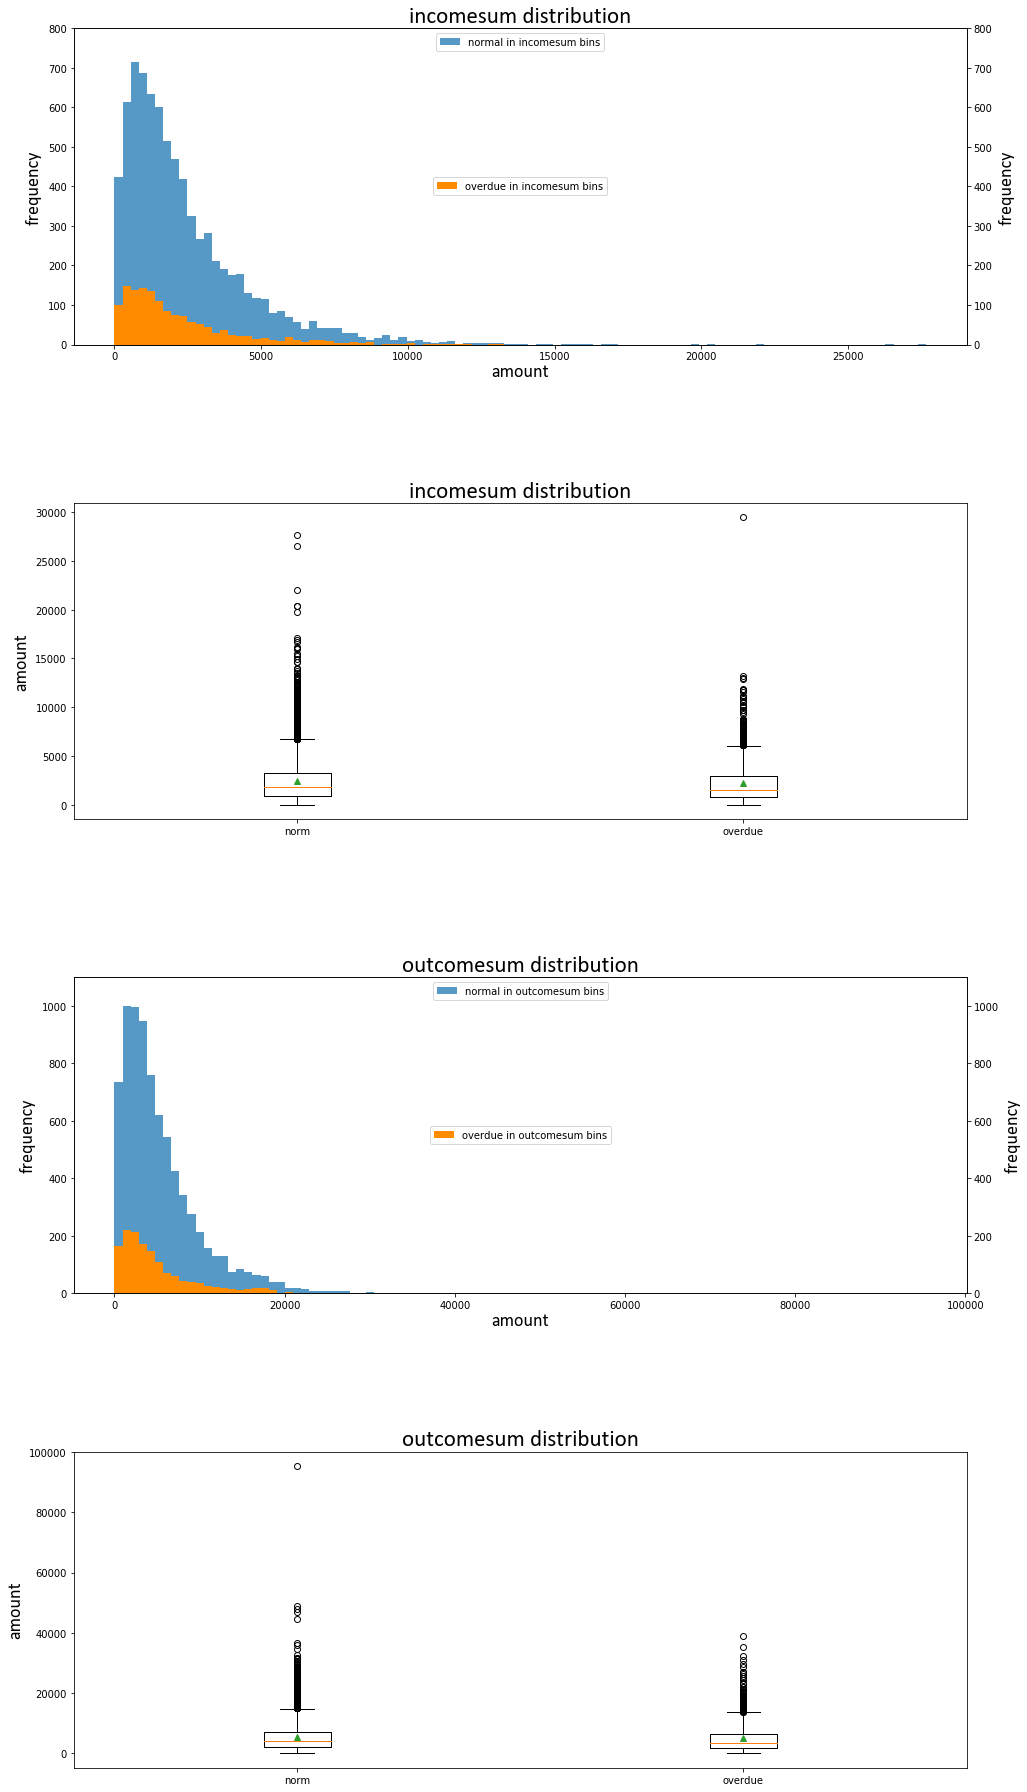

In [128]:
# bank_income_sum 和 bank_outcome_sum 字段


fig5 = plt.figure(figsize = (16,32))

ax1 = fig5.add_subplot(411)
n1, bins1, patches1 = ax1.hist(bank_detail_stats_train_Y_0["bank_income_sum"], bins=100, alpha=0.75,label="normal in incomesum bins")  # 做直方图
ax2 = ax1.twinx()
n2, bins2, patches2 = ax2.hist(bank_detail_stats_train_Y_1["bank_income_sum"], bins=bins1, alpha=1,label="overdue in incomesum bins", color="darkorange")  # 做直方图
ax1.set_title('incomesum distribution',fontdict=font2 ) 
ax1.set_xlabel('amount',fontdict=font1,labelpad= 2)  
ax1.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax1.set_ylim(bottom=0 ,top =800 ) 
#ax1.set_xlim(left=-1, right=20)   
ax1.legend(loc=9)
ax2.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax2.set_ylim(bottom=0 ,top =800 ) 
ax2.legend(loc=10)


ax3 = fig5.add_subplot(412)
ax3.boxplot(x= [bank_detail_stats_train_Y_0["bank_income_sum"],bank_detail_stats_train_Y_1["bank_income_sum"]],showmeans=True)  # 做箱线图
ax3.set_title('incomesum distribution',fontdict=font2 ) 
ax3.set_ylabel('amount',fontdict=font1,labelpad= 6)
ax3.set_xticklabels(["norm","overdue"])


ax4 = fig5.add_subplot(413)
n4, bins4, patches4 = ax4.hist(bank_detail_stats_train_Y_0["bank_outcome_sum"], bins=100, alpha=0.75,label="normal in outcomesum bins")  # 做直方图
ax5 = ax4.twinx()
n5, bins5, patches5 = ax5.hist(bank_detail_stats_train_Y_1["bank_outcome_sum"], bins=bins4, alpha=1,label="overdue in outcomesum bins", color="darkorange")  # 做直方图
ax4.set_title('outcomesum distribution',fontdict=font2 ) 
ax4.set_xlabel('amount',fontdict=font1,labelpad= 2)  
ax4.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax4.set_ylim(bottom=0 ,top =1100 ) 
#ax4.set_xlim(left=-1, right=20)   
ax4.legend(loc=9)
ax5.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax5.set_ylim(bottom=0 ,top =1100 ) 
ax5.legend(loc=10)


ax6 = fig5.add_subplot(414)
ax6.boxplot(x= [bank_detail_stats_train_Y_0["bank_outcome_sum"],bank_detail_stats_train_Y_1["bank_outcome_sum"]],showmeans=True)  # 做箱线图
ax6.set_title('outcomesum distribution',fontdict=font2 ) 
ax6.set_ylabel('amount',fontdict=font1,labelpad= 6)
ax6.set_xticklabels(["norm","overdue"])


plt.subplots_adjust(wspace = 0.5, hspace =0.5)  # 调整每个子图之间的距离   
plt.show()


&ensp;&ensp;前两幅图是训练集里有bank信息的客户中，在“bank_income_sum”字段上是 正常 和 违约 两种情况的分布。（注意，直方图里并没有叠加，而是正常的分布 与 违约的分布 画在了一起）。可见，分布有偏，大部分用户，不论正常/违约，其“收入sum”都在0~11000之间。但是，有个别客户，收入sum很高，这些我认为太异常了，建议删去。  同理，在“bank_outcome_sum”字段上，分布有偏，大部分用户，不论正常/违约，其“支出sum”都在0~40000之间。但是，有个别客户，支出sum很高，这些我认为太异常了，建议删去。  

&ensp;&ensp;bank_train_income_sum_outlier是训练集里有bank信息的客户中，收入sum异常的用户的userID，共65个。bank_train_outcome_sum_outlier是训练集里有bank信息的客户中，支出sum异常的userID，共5个。


In [129]:
bins1

array([6.84996700e+00, 2.83296666e+02, 5.59743365e+02, 8.36190064e+02,
       1.11263676e+03, 1.38908346e+03, 1.66553016e+03, 1.94197686e+03,
       2.21842356e+03, 2.49487026e+03, 2.77131696e+03, 3.04776366e+03,
       3.32421036e+03, 3.60065705e+03, 3.87710375e+03, 4.15355045e+03,
       4.42999715e+03, 4.70644385e+03, 4.98289055e+03, 5.25933725e+03,
       5.53578395e+03, 5.81223065e+03, 6.08867735e+03, 6.36512404e+03,
       6.64157074e+03, 6.91801744e+03, 7.19446414e+03, 7.47091084e+03,
       7.74735754e+03, 8.02380424e+03, 8.30025094e+03, 8.57669764e+03,
       8.85314434e+03, 9.12959103e+03, 9.40603773e+03, 9.68248443e+03,
       9.95893113e+03, 1.02353778e+04, 1.05118245e+04, 1.07882712e+04,
       1.10647179e+04, 1.13411646e+04, 1.16176113e+04, 1.18940580e+04,
       1.21705047e+04, 1.24469514e+04, 1.27233981e+04, 1.29998448e+04,
       1.32762915e+04, 1.35527382e+04, 1.38291849e+04, 1.41056316e+04,
       1.43820783e+04, 1.46585250e+04, 1.49349717e+04, 1.52114184e+04,
      

In [130]:
n1

array([425., 614., 715., 686., 633., 600., 516., 469., 418., 326., 266.,
       282., 211., 191., 175., 178., 131., 117., 114.,  79.,  84.,  70.,
        57.,  40.,  60.,  43.,  41.,  43.,  28.,  29.,  20.,  12.,  17.,
        23.,  12.,  18.,  10.,  12.,   7.,   4.,   7.,   8.,   2.,   4.,
         5.,   3.,   3.,   4.,   1.,   1.,   2.,   0.,   1.,   2.,   0.,
         2.,   1.,   2.,   1.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   1.,   0.,   2.,   0.,   0.,   0.,
         0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
         1.])

In [131]:
# tmp12是训练集里有bank信息的客户中，在“bank_income_sum”字段上大于 11000的客户。
# tmp13是训练集里有bank信息的客户中，在“bank_outcome_sum”字段上大于 40000的客户。
# bank_train_income_sum_outlier是训练集里有bank信息的客户中，收入sum异常的用户，应删去。
# bank_train_outcome_sum_outlier是训练集里有bank信息的客户中，支出sum异常的用户，应删去。

tmp12 = bank_detail_stats_train_Y.loc[bank_detail_stats_train_Y["bank_income_sum"]>11000,"bank_income_sum"]
tmp13 = bank_detail_stats_train_Y.loc[bank_detail_stats_train_Y["bank_outcome_sum"]>40000,"bank_outcome_sum"]
bank_train_income_sum_outlier = tmp12.index
bank_train_outcome_sum_outlier = tmp13.index
print("The number of outliers in income_sum is:", len(bank_train_income_sum_outlier))
print("The number of outliers in outcome_sum is:", len(bank_train_outcome_sum_outlier))

The number of outliers in income_sum is: 68
The number of outliers in outcome_sum is: 5


In [132]:
bank_train_income_sum_outlier

Int64Index([  353,   427,   664,   702,   715,   808,  1596,  1702,  2785,
             2815,  4282,  4318,  4577,  4792,  4871,  4990,  5548,  5549,
             5894,  6270,  6518,  7224,  7284,  8681, 10734, 11462, 11630,
            11945, 13122, 13182, 13614, 14537, 14587, 14712, 15198, 16743,
            16942, 16950, 17477, 17690, 17702, 17742, 17783, 20245, 20361,
            20435, 21524, 22845, 24418, 26233, 26816, 29267, 29803, 32111,
            34304, 36347, 36348, 36520, 38625, 40907, 41654, 47362, 49421,
            49473, 50140, 51270, 53725, 54913],
           dtype='int64', name='userID')

## 4.2 browse_history 整合

&ensp;&ensp;browse_behavior信息以后要整合到总表里，每个用户一条记录。而有browse_behavior信息的用户有85.37% 比较多。
1. 以browse_time与loan_time的对比，对数据进行分组。检查发现browse_time里没有值0（表示时间未知），所以，根据 放款前browse_time<=loantime 和 放款后 browse_time>loantime 对数据集进行分割。后发现，（训练集+未知数据集共约7万人），有5万6千人有放款前数据，这是可以接受的。但是只有1万5千人有放款后数据，太少了，预计使用放款后数据会产生很多缺失值。所以决定：仅仅使用放款前数据 与 不分放款前放款后的总体数据。
2. 按时间分割得到数据后，对每个用户统计其所具有的浏览子行为种类数、每种编号的浏览子行为对应的浏览行为数据的sum,max,mean,median,min.
3. 因为以上操作都是针对每个用户本身进行的，所以可以训练集和未知数据集一起做。

### 4.2.1 groupby and feature creation 
1. 统计全部时间（不论放款前后）的信息 和 放款前的信息，两表结合起来。
2. 创建了新特征，即每个用户在所有时间，对部分种类的浏览行为的浏览数据的sum,max,mean,median,min,count。以及每个用户在放款前的时间里，对部分种类的浏览行为的浏览数据的sum,max,mean,median,min,count。
3. 两表内部的缺失值用 0 填充，但两表结合后得到的 browse_history_stats 表的缺失值，留待以后算法填充。

In [133]:
# 这说明不论是训练集还是未知样本集 的 browse_behavior表里的 browse_time 列（除了缺失浏览信息的那些用户外）都不是 0 值，
# 意思也就是所有的 browse_time 都是已知的，没有“时间戳未知”的情况。

browse_history.loc[browse_history["browse_time"]==0,["userID","browse_time"]]

,userID,browse_time


In [134]:
# 先把 browse_history和 loan_time 依照 userID 融合在一起，得到 browse_history_L，L代表此表有 loantime列。
# 将 browsetime<=loantime的记录选取出来，即放款前的所有记录，browse_history_L_before ，before代表放款前。


browse_history_L = pd.merge(browse_history,loan_time, on="userID", how="left")
browse_history_L_before = browse_history_L.loc[browse_history_L['browse_time']<=browse_history_L['loan_time'],:]
browse_history_L_after = browse_history_L.loc[browse_history_L['browse_time']>browse_history_L['loan_time'],:]
tmp49 = len(browse_history_L["userID"].unique())
tmp51 = len(browse_history_L_before["userID"].unique())
tmp52 = len(browse_history_L_after["userID"].unique())
tmp53 = len(user_info["userID"])
print("user number with browse_history_L:  ",tmp49)
print("user number with browse_history_L_before:  ",tmp51)
print("user number with browse_history_L_after:  ",tmp52)
print("bill percent:",tmp49/tmp53)
print("before percent:",tmp51/tmp53)
print("after percent:",tmp52/tmp53)

# 训练集+未知数据集约 7万人，其中有 5万9千人，即85%有browse数据。有81%有放款前数据，但仅有23%有放款后数据。

user number with browse_history_L:   59327
user number with browse_history_L_before:   56091
user number with browse_history_L_after:   15990
bill percent: 0.8536873156342183
before percent: 0.8071228145909778
after percent: 0.23008849557522124


In [135]:
browse_history_L_before.head(5)

,userID,browse_time,browse_behavior,browse_num,loan_time
0,2,5893398099,143,3,5914855887
1,2,5912610799,189,1,5914855887
2,2,5912610799,44,5,5914855887
3,2,5907360322,45,1,5914855887
4,2,5907360322,118,1,5914855887


In [136]:
# 统计放款前，每个用户拥有的 browse_history条目记录数，并把它起名为 browse_before_recordcount
# 由 shape 可知，共有 56091 个用户有 放款前 browse_history 信息。此表无缺失。

gb1 = browse_history_L_before.groupby(by="userID")
browse_before_recordcount = gb1.size()
browse_before_recordcount.name = "browse_before_recordcount"
browse_before_recordcount = pd.DataFrame(browse_before_recordcount)
print("shape:  ",browse_before_recordcount.shape)
browse_before_recordcount.head()

shape:   (56091, 1)


,browse_before_recordcount
userID,
2,1305
3,342
4,364
6,15
7,1008


In [137]:
browse_before_recordcount.describe()  # 可以看到基本信息，最少的有人才只有一条信息，最多的有人有3万多条。

,browse_before_recordcount
count,56091.000000
mean,465.893994
std,708.549718
min,1.000000
25%,126.000000
50%,272.000000
75%,552.000000
max,33972.000000


In [138]:
# 统计放款前，每个用户共有几种浏览行为，并把它起名为 browse_before_kindcount
# 此 shape 仍是 56091，正常，因为共有 56091 个用户有 放款前 browse_history 信息。
# 此表无缺失。


browse_before_kindcount = gb1["browse_num"].apply(lambda x:np.size(np.unique(x)))
browse_before_kindcount.name = 'browse_before_kindcount'
browse_before_kindcount = pd.DataFrame(browse_before_kindcount)
print("shape:  ",browse_before_kindcount.shape)
browse_before_kindcount.head()

# 此处，每个用户的browse_num这组值成为lambda的x，np.unique(x)可以得到这组值的唯一化后的一组数，也就是这个用户都有哪些种
# 浏览行为。外边又有一个np.size()，则是得到唯一化后的这组数的个数，也就是每个用户有多少种浏览行为，将这个int返回，则每个用户得到
# 一个int。将此series(索引是userID,列名是 browse_behavior_kindcount)， 记为browse_behavior_kindcount。


shape:   (56091, 1)


,browse_before_kindcount
userID,
2,8
3,6
4,8
6,1
7,7


In [139]:
# 将放款前的信息依照 userID, browse_num 进行 groupby(由描述统计时对 browse_num 的分析可知，共有 11 种 浏览行为)，得 gb2.
# 统计放款前，每个用户每种浏览行为的 值的 sum, max,mean,min,std,次数size，得 gb3.
# g3经过改列名过程，得到 browse_before_behavior表 。此表共56091行，正常，但里面有很多 缺失值，因为每个用户并不是在每种浏览行为
# 上都有进行。



gb2 = browse_history_L_before.groupby(by=['userID','browse_num'])
gb3 = gb2['browse_behavior'].aggregate([np.sum,np.max,np.mean,np.median,np.min,np.size])
gb4 = gb3.unstack(level = -1)

# 代码技巧：gb3 是双重索引，但却是单列。unstack 把双重索引中的browse_num变成列，从而 gb4是单层行索引 userID。
# 这样，gb4就是，行索引为单层索引userID，列索引为双重索引，比如gb4表的第一个值是59820.0，意思是
# userID为2的用户的第1种浏览行为（browse_num为1）的 browse_behavior值的sum。

In [140]:
gb4

sum                                                           \
browse_num        1   2        3        4        5       6        7        8    
userID                                                                          
2            59820.0 NaN  11160.0  22725.0  19230.0  4710.0   6150.0  13455.0   
3            19968.0 NaN      NaN   7272.0   2694.0  1200.0   2892.0      NaN   
4            17824.0 NaN    572.0   9696.0   2188.0  1600.0   1656.0    668.0   
6                NaN NaN      NaN      NaN      NaN     NaN   1650.0      NaN   
7            53298.0 NaN      NaN  21000.0  10346.0  5740.0   7280.0   2338.0   
8            50358.0 NaN   2519.0  23331.0  12738.0  4202.0   8976.0   1837.0   
10           12590.0 NaN   2860.0   6060.0   4260.0  1000.0   1860.0   3960.0   
12           34896.0 NaN     96.0   3636.0   4440.0  2400.0   1824.0      NaN   
14            8312.0 NaN      NaN   4848.0   3008.0   800.0   1488.0      NaN   
15            8239.0 NaN      NaN   4242.0      NaN   700.0   1302.0      NaN   
16            8316.0 NaN      NaN   2727.0   1206.0  1899.0    342.0   1503.0   
17          131726.0 NaN      NaN  62888.0  12124.0  7000.0  13020.0  23380.0   
18            5380.0 NaN      NaN   3030.0      NaN   500.0    380.0      NaN   
19           86700.0 NaN      NaN  50310.0  31785.0  6000.0  11160.0   1395.0   
20           36189.0 NaN      NaN  16470.0   1584.0  1800.0   2358.0   4509.0   
21           19086.0 NaN      NaN   9090.0   1542.0  1500.0   1800.0   2004.0   
22            9312.0 NaN      NaN   3664.0   1584.0   800.0    304.0      NaN   
23           19744.0 NaN      NaN   8348.0   2400.0  2488.0   1792.0    124.0   
24            9621.0 NaN    945.0   4122.0   2925.0   450.0    342.0    324.0   
25           16044.0 NaN      NaN  10605.0      NaN  1750.0   2870.0      NaN   
28           69660.0 NaN   6435.0  31815.0  12285.0  6960.0  10590.0  12525.0   
29           12947.0 NaN   1573.0   6666.0   2343.0  1100.0   2046.0   1837.0   
30           19719.0 NaN      NaN  13635.0      NaN  2250.0   2700.0      NaN   
31           39228.0 NaN    630.0  15342.0   3750.0  2100.0   2256.0      NaN   
32            6632.0 NaN      NaN   2424.0      NaN   400.0    304.0      NaN   
33           14868.0 NaN      NaN   2121.0    308.0   700.0    532.0   1169.0   
34           22070.0 NaN      NaN   6060.0    440.0  4220.0   2960.0   3340.0   
35           10325.0 NaN      NaN   4242.0      NaN   700.0    266.0      NaN   
36           50680.0 NaN   4180.0  29730.0  18140.0  8810.0   1900.0   5010.0   
37           14368.0 NaN      NaN   7272.0   3008.0  1200.0   2672.0      NaN   
...              ...  ..      ...      ...      ...     ...      ...      ...   
69396         1140.0 NaN      NaN    606.0    376.0   100.0    296.0      NaN   
69397         2685.0 NaN      NaN    909.0    222.0   150.0    334.0    334.0   
69399        20520.0 NaN      NaN  12120.0   1072.0  1688.0   2400.0   1336.0   
69402         1825.0 NaN      NaN    909.0     44.0    50.0    224.0      NaN   
69403         6536.0 NaN      NaN   3664.0   1784.0   400.0    304.0    248.0   
69404         4842.0 NaN      NaN   2727.0      NaN   450.0    342.0      NaN   
69407         4144.0 NaN      NaN   2424.0      NaN   400.0    304.0      NaN   
69409        11970.0 NaN      NaN   8120.0   5537.0  1827.0   1302.0    609.0   
69413         2349.0 NaN      NaN    909.0      NaN     NaN      NaN      NaN   
69414        22284.0 NaN      NaN   7272.0   4806.0  4098.0   3552.0   3006.0   
69416         2990.0 NaN      NaN   1212.0      NaN   314.0    592.0    334.0   
69417        12240.0 NaN      NaN   5454.0      NaN   900.0   2664.0    558.0   
69418         4473.0 NaN      NaN   2121.0      NaN   350.0   1036.0      NaN   
69423        16713.0 NaN      NaN   6849.0   2988.0   900.0   2664.0   1503.0   
69425         7458.0 NaN      NaN      NaN      NaN     NaN      NaN      NaN   
69426         1140.0 NaN      NaN    606.0    37

In [141]:
# 改列名
# BL代表 before loan，放款前。bn 代表 browse_num，即浏览行为种类编号。 
# browse_BLbn_8_sum 表示 某用户ID在放款前时，第8种浏览行为的所有条目的 browse_behavior值的 和。

L1 = ['sum','max','mean','median','min','count']
L2 = ['1','2','3','4','5','6','7','8','9','10','11']
L = ['_'.join(['browse_BLbn',j,i]) for i in L1 for j in L2]    
gb4.columns = L  # 改列名，同时将原来的双重列索引 双改成单层列索引。
browse_before_behavior = gb4    # before代表 before loan，即放款前。
print("shape:  ",browse_before_behavior.shape)
browse_before_behavior.head()


# join函数 也可以用 'bn'+'_'+j+'_'+i 式子代替，经验证，两者结果一样


shape:   (56091, 66)


,browse_BLbn_1_sum,browse_BLbn_2_sum,browse_BLbn_3_sum,browse_BLbn_4_sum,browse_BLbn_5_sum,browse_BLbn_6_sum,browse_BLbn_7_sum,browse_BLbn_8_sum,browse_BLbn_9_sum,browse_BLbn_10_sum,...,browse_BLbn_2_count,browse_BLbn_3_count,browse_BLbn_4_count,browse_BLbn_5_count,browse_BLbn_6_count,browse_BLbn_7_count,browse_BLbn_8_count,browse_BLbn_9_count,browse_BLbn_10_count,browse_BLbn_11_count
userID,,,,,,,,,,,,,,,,,,,,,
2,59820.0,NaN,11160.0,22725.0,19230.0,4710.0,6150.0,13455.0,NaN,14250.0,...,NaN,90.0,150.0,105.0,135.0,105.0,105.0,NaN,75.0,NaN
3,19968.0,NaN,NaN,7272.0,2694.0,1200.0,2892.0,NaN,NaN,4560.0,...,NaN,NaN,48.0,30.0,24.0,42.0,NaN,NaN,24.0,NaN
4,17824.0,NaN,572.0,9696.0,2188.0,1600.0,1656.0,668.0,NaN,4560.0,...,NaN,4.0,64.0,36.0,32.0,36.0,4.0,NaN,24.0,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,1650.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN
7,53298.0,NaN,NaN,21000.0,10346.0,5740.0,7280.0,2338.0,NaN,12418.0,...,NaN,NaN,140.0,98.0,98.0,112.0,14.0,NaN,84.0,NaN


In [142]:
# 将 3 张表依 userID索引 join  起来，得到 browse_before_stats表。

tmp14 = browse_before_recordcount.join(browse_before_kindcount)
browse_before_stats = tmp14.join(browse_before_behavior)

print("shape:  ", browse_before_stats.shape)
browse_before_stats.head()

# 这里用 merge 也可以实现需求。

shape:   (56091, 68)


,browse_before_recordcount,browse_before_kindcount,browse_BLbn_1_sum,browse_BLbn_2_sum,browse_BLbn_3_sum,browse_BLbn_4_sum,browse_BLbn_5_sum,browse_BLbn_6_sum,browse_BLbn_7_sum,browse_BLbn_8_sum,...,browse_BLbn_2_count,browse_BLbn_3_count,browse_BLbn_4_count,browse_BLbn_5_count,browse_BLbn_6_count,browse_BLbn_7_count,browse_BLbn_8_count,browse_BLbn_9_count,browse_BLbn_10_count,browse_BLbn_11_count
userID,,,,,,,,,,,,,,,,,,,,,
2,1305,8,59820.0,NaN,11160.0,22725.0,19230.0,4710.0,6150.0,13455.0,...,NaN,90.0,150.0,105.0,135.0,105.0,105.0,NaN,75.0,NaN
3,342,6,19968.0,NaN,NaN,7272.0,2694.0,1200.0,2892.0,NaN,...,NaN,NaN,48.0,30.0,24.0,42.0,NaN,NaN,24.0,NaN
4,364,8,17824.0,NaN,572.0,9696.0,2188.0,1600.0,1656.0,668.0,...,NaN,4.0,64.0,36.0,32.0,36.0,4.0,NaN,24.0,NaN
6,15,1,NaN,NaN,NaN,NaN,NaN,NaN,1650.0,NaN,...,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN
7,1008,7,53298.0,NaN,NaN,21000.0,10346.0,5740.0,7280.0,2338.0,...,NaN,NaN,140.0,98.0,98.0,112.0,14.0,NaN,84.0,NaN


In [143]:
# 使用自定义函数 Calnan 计算 browse_before_stats 里各个列的缺失情况。
# 前两列 browse_before_recordcount和browse_before_kindcount无缺失，这个我们已经知道。所以缺失重点集中在 behavior部分，
# 即后 66个特征。通过计算发现，缺失超过50%的就有 30 个特征。（这个超过50%指的是 browse_before_stats表里某一列的缺失个数
# 比上这个表的总行数，也就是在具有放款前信息的用户中，这些特征的缺失比例。总共只有 56091 人有放款前信息，而训练集+未知
# 数据集共含 69495 个用户，所以如果放到 总数据集中，那缺失将是超过 50%的）。
# 所以我认为这 30 个特征还是删掉比较好。(反正是“放款前”的特征，删了也OK)

tmp15 = CF.Calnan(browse_before_stats)
tmp16 = tmp15.loc[tmp15["nanpercent"]>0.5]
tmp16.shape

(30, 3)

In [144]:
tmp15.head(5)

,column_name,nancount,nanpercent
0,browse_before_recordcount,0,0.000000
1,browse_before_kindcount,0,0.000000
2,browse_BLbn_1_sum,23,0.000410
3,browse_BLbn_2_sum,56029,0.998895
4,browse_BLbn_3_sum,46881,0.835803


In [145]:
# 可以看到，第2,3,8,9,11 种浏览行为的缺失情况最严重。而这 5 种行为恰好也是 收集到的记录最少的浏览行为。
tmp16

,column_name,nancount,nanpercent
3,browse_BLbn_2_sum,56029,0.998895
4,browse_BLbn_3_sum,46881,0.835803
9,browse_BLbn_8_sum,28073,0.500490
10,browse_BLbn_9_sum,54940,0.979480
12,browse_BLbn_11_sum,56020,0.998734
14,browse_BLbn_2_max,56029,0.998895
15,browse_BLbn_3_max,46881,0.835803
20,browse_BLbn_8_max,28073,0.500490
21,browse_BLbn_9_max,54940,0.979480
23,browse_BLbn_11_max,56020,0.998734


In [146]:
# 将缺失最多的第2,3,8,9,11 种浏览行为的相关特征删掉后，只剩下了收集到的记录较多的 6 种特征，
# browse_before_stats 表现在的列为 38 个。此时，browse_before_recordcount 和 browse_before_kindcount 列是没有缺失的。
# 缺失还是集中在 behavior 的那些特征里。但这时，可以认为这些特征收集到的记录已经比较多了，若一个用户没有某个特征，则
# 很可能是他确实没有这个浏览行为，相应的，对应的特征 的取值（不论是sum,max,mean,median,min,count）都应该是 0，也就是，用 0 填充。
# 但是，也很有可能是，确实没收集到。 
# 所以，此处 缺失值的填充有两种选择：1.用 0 填充。2.和没有 browse_history信息的用户并到一起，用算法填充。（注意，有 browse_history
# 表信息的用户，若在这些特征上缺失，则可能是他们真的没进行这种行为。但没有 browse_history表信息的用户，若在这些特征上缺失，则很可能
# 是没有收集到这些用户的浏览行为信息，而不是他们本身所有浏览行为都是0）
# 此处，我选择 第 1种方式，用 0 填充，我暂时觉得这样比较合理。
# before代表放款前，bn 代表 browse_num，即浏览行为种类编号，BL代表before loan 放款前。
# # 注意，所谓的每个用户是 训练集和未知数据集里有browse_history信息的所有用户。


# 此步得到的 browse_before_stats 的 shape为：(56091, 38)，共 38 个字段，分别为：
# browse_before_recordcount    放款前，每个用户拥有的 browse_history条目记录数
# browse_before_kindcount      放款前，每个用户共有几种浏览行为
# browse_BLbn_1_sum            放款前，每个用户的第1种浏览行为的 值的 sum .同理还有 browse_BLbn_4_sum等第4,7,5,6,10 种浏览行为的sum。共六个特征。
# browse_BLbn_1_max            放款前，每个用户的第1种浏览行为的 值的 max. 同理
# browse_BLbn_1_mean           放款前，每个用户的第1种浏览行为的 值的 mean. 同理 
# browse_BLbn_1_median         放款前，每个用户的第1种浏览行为的 值的 median. 同理
# browse_BLbn_1_min            放款前，每个用户的第1种浏览行为的 值的 min. 同理
# browse_BLbn_1_count          放款前，每个用户的第1种浏览行为的 值的 count. 同理
# 一共 2+ 6*6 = 38 个特征。
# （本表没有缺失值）。

browse_before_stats.drop(tmp16["column_name"].tolist(), axis=1, inplace = True)

browse_before_stats.fillna(0, inplace=True)  # 注意一定要 inplace。否则相当于没填充。

print("shape:  ", browse_before_stats.shape)
browse_before_stats.head()

shape:   (56091, 38)


,browse_before_recordcount,browse_before_kindcount,browse_BLbn_1_sum,browse_BLbn_4_sum,browse_BLbn_5_sum,browse_BLbn_6_sum,browse_BLbn_7_sum,browse_BLbn_10_sum,browse_BLbn_1_max,browse_BLbn_4_max,...,browse_BLbn_5_min,browse_BLbn_6_min,browse_BLbn_7_min,browse_BLbn_10_min,browse_BLbn_1_count,browse_BLbn_4_count,browse_BLbn_5_count,browse_BLbn_6_count,browse_BLbn_7_count,browse_BLbn_10_count
userID,,,,,,,,,,,,,,,,,,,,,
2,1305,8,59820.0,22725.0,19230.0,4710.0,6150.0,14250.0,189.0,164.0,...,44.0,7.0,38.0,190.0,540.0,150.0,105.0,135.0,105.0,75.0
3,342,6,19968.0,7272.0,2694.0,1200.0,2892.0,4560.0,173.0,164.0,...,35.0,50.0,38.0,190.0,174.0,48.0,30.0,24.0,42.0,24.0
4,364,8,17824.0,9696.0,2188.0,1600.0,1656.0,4560.0,173.0,164.0,...,35.0,50.0,38.0,190.0,164.0,64.0,36.0,32.0,36.0,24.0
6,15,1,0.0,0.0,0.0,0.0,1650.0,0.0,0.0,0.0,...,0.0,0.0,110.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0
7,1008,7,53298.0,21000.0,10346.0,5740.0,7280.0,12418.0,201.0,164.0,...,44.0,50.0,38.0,23.0,462.0,140.0,98.0,98.0,112.0,84.0


In [147]:
# 同理，这次总结 所有时间（放款前和放款后）的同样的字段。

# browse_history和 loan_time 依照 userID 融合在一起，得到 browse_history_L（之前已得到），L代表此表有 loantime列。
# browse_history_L 

# 统计所有时间，每个用户拥有的 browse_history条目记录数，并把它起名为 browse_all_recordcount, all 代表所有时间
# 由 shape 可知，共有 59327 个用户有 放款前 browse_history 信息。此表无缺失。
gb5 = browse_history_L.groupby(by="userID")
browse_all_recordcount = gb5.size()
browse_all_recordcount.name = "browse_all_recordcount"
browse_all_recordcount = pd.DataFrame(browse_all_recordcount)
print("shape:  ",browse_all_recordcount.shape)

# 统计所有时间，每个用户共有几种浏览行为，并把它起名为 browse_all_kindcount, all 代表所有时间
# 此 shape 仍是 593271，正常，因为共有 59327 个用户有  browse_history 信息。
# 此表无缺失。
browse_all_kindcount = gb5["browse_num"].apply(lambda x:np.size(np.unique(x)))
browse_all_kindcount.name = 'browse_all_kindcount'
browse_all_kindcount = pd.DataFrame(browse_all_kindcount)
print("shape:  ",browse_all_kindcount.shape)

# 将所有时间的信息依照 userID, browse_num 进行 groupby(由描述统计时对 browse_num 的分析可知，共有 11 种 浏览行为)，得 gb6.
# 统计所有时间，每个用户每种浏览行为的 值的 sum, max,mean,min,std,次数size，得 gb7.
# g7经过改列名过程，得到 browse_all_behavior表 。此表共59327行，正常，但里面有很多 缺失值，因为每个用户并不是在每种浏览行为
# 上都有进行。
gb6 = browse_history_L.groupby(by=['userID','browse_num'])
gb7 = gb6['browse_behavior'].aggregate([np.sum,np.max,np.mean,np.median,np.min,np.size])
gb8 = gb7.unstack(level = -1)

# 改列名
# ALL代表所有时间。bn 代表 browse_num，即浏览行为种类编号。 
# browse_ALLbn_8_sum 表示 某用户ID在所有时间，第8种浏览行为的所有条目的 browse_behavior值的 和。
L1 = ['sum','max','mean','median','min','count']
L2 = ['1','2','3','4','5','6','7','8','9','10','11']
L = ['_'.join(['browse_ALLbn',j,i]) for i in L1 for j in L2]    
gb8.columns = L  # 改列名，同时将原来的双重列索引 双改成单层列索引。
browse_all_behavior = gb8    # all代表 所有时间。
print("shape:  ",browse_all_behavior.shape)

# 将 3 张表依 userID索引 join  起来，得到 browse_all_stats表。
tmp17 = browse_all_recordcount.join(browse_all_kindcount)
browse_all_stats = tmp17.join(browse_all_behavior)
print("shape:  ", browse_all_stats.shape)

# 使用自定义函数 Calnan 计算 browse_all_stats 里各个列的缺失情况。
# 前两列 browse_all_recordcount和browse_all_kindcount无缺失，这个我们已经知道。所以缺失重点集中在 behavior部分，
# 即后 66个特征。通过计算发现，缺失超过50%的就有 24 个特征。（这个超过50%指的是 browse_all_stats表里某一列的缺失个数
# 比上这个表的总行数，也就是在具有浏览信息的用户中，这些特征的缺失比例。总共只有 59327 人有browse信息，而训练集+未知
# 数据集共含 69495 个用户，所以如果放到 总数据集中，那缺失将是超过 50%的）。
# 所以我认为这 24 个特征还是删掉比较好。
# 而且观察 tmp19 可发现，这 24个特征都是第2,3,9,11号浏览行为的相关特征，（这4个浏览行为本身收集到的记录就是所有浏览行为里最少的），
# 而且它们的缺失率 不只是超过 50%，而是基本都在 80%~100%之间，缺失率非常高，所以建议删掉。
# 另外，在整理 “放款前”的数据时，还删掉了第 8 号浏览行为的相关特征，而在此处，“所有时间”的数据里，观察 tmp18可知，第8号浏览行为
# 缺失率在49%，也是比较高的，虽然低于50%，还是建议删掉。 而 其它的第1,4,5,6,7,10号浏览行为，缺失率在0%~25%之间，可以接受，所以保留。
tmp18 = CF.Calnan(browse_all_stats)
tmp19 = tmp18.loc[tmp18["nanpercent"]>0.5]
print("shape:  ",tmp19.shape)

shape:   (59327, 1)
shape:   (59327, 1)
shape:   (59327, 66)
shape:   (59327, 68)
shape:   (24, 3)


In [148]:
tmp18

,column_name,nancount,nanpercent
0,browse_all_recordcount,0,0.000000
1,browse_all_kindcount,0,0.000000
2,browse_ALLbn_1_sum,23,0.000388
3,browse_ALLbn_2_sum,59265,0.998955
4,browse_ALLbn_3_sum,49535,0.834949
5,browse_ALLbn_4_sum,3549,0.059821
6,browse_ALLbn_5_sum,14447,0.243515
7,browse_ALLbn_6_sum,3257,0.054899
8,browse_ALLbn_7_sum,2492,0.042004
9,browse_ALLbn_8_sum,29241,0.492878


In [149]:
tmp19

,column_name,nancount,nanpercent
3,browse_ALLbn_2_sum,59265,0.998955
4,browse_ALLbn_3_sum,49535,0.834949
10,browse_ALLbn_9_sum,58168,0.980464
12,browse_ALLbn_11_sum,59255,0.998786
14,browse_ALLbn_2_max,59265,0.998955
15,browse_ALLbn_3_max,49535,0.834949
21,browse_ALLbn_9_max,58168,0.980464
23,browse_ALLbn_11_max,59255,0.998786
25,browse_ALLbn_2_mean,59265,0.998955
26,browse_ALLbn_3_mean,49535,0.834949


In [150]:
# 将缺失最多的第2,3,8,9,11 种浏览行为的相关特征删掉后，只剩下了收集到的记录较多的 6 种特征，
# browse_all_stats 表 现在的列为 38 个。此时，browse_all_recordcount 和 browse_all_kindcount 列是没有缺失的。
# 缺失还是集中在 behavior 的那些特征里。但这时，可以认为这些特征收集到的记录已经比较多了，若一个用户没有某个特征，则
# 很可能是他确实没有这个浏览行为，相应的，对应的特征 的取值（不论是sum,max,mean,median,min,count）都应该是 0，也就是，用 0 填充。
# 但是，也很有可能是，确实没收集到。 
# 所以，此处 缺失值的填充有两种选择：1.用 0 填充。2.和没有 browse_history信息的用户并到一起，用算法填充。（注意，有 browse_history
# 表信息的用户，若在这些特征上缺失，则可能是他们真的没进行这种行为。但没有 browse_history表信息的用户，若在这些特征上缺失，则很可能
# 是没有收集到这些用户的浏览行为信息，而不是他们本身所有浏览行为都是0）
# 此处，我选择 第 1种方式，用 0 填充，我暂时觉得这样比较合理。
# all代表所有时间（不分放款前后），bn 代表 browse_num，即浏览行为种类编号，ALL代表所有时间。


# 此步得到的 browse_all_stats 的 shape为：(59327, 38)，共 38 个字段，分别为：
# browse_all_recordcount        放款前，每个用户拥有的 browse_history条目记录数
# browse_all_kindcount          放款前，每个用户共有几种浏览行为
# browse_ALLbn_1_sum            放款前，每个用户的第1种浏览行为的 值的 sum .同理还有 browse_ALLbn_4_sum等第4,7,5,6,10 种浏览行为的sum。共六个特征。
# browse_ALLbn_1_max            放款前，每个用户的第1种浏览行为的 值的 max. 同理
# browse_ALLbn_1_mean           放款前，每个用户的第1种浏览行为的 值的 mean. 同理 
# browse_ALLbn_1_median         放款前，每个用户的第1种浏览行为的 值的 median. 同理
# browse_ALLbn_1_min            放款前，每个用户的第1种浏览行为的 值的 min. 同理
# browse_ALLbn_1_count          放款前，每个用户的第1种浏览行为的 值的 count. 同理

# 一共 2+ 6*6 = 38 个特征。
# （本表没有缺失值）。

tmp20 = tmp18.loc[tmp18["nanpercent"]>0.49]
browse_all_stats.drop(tmp20["column_name"].tolist(), axis=1, inplace = True)

browse_all_stats.fillna(0, inplace=True)  # 注意一定要 inplace。否则相当于没填充。

print("shape:  ", browse_all_stats.shape)
browse_all_stats.head()

shape:   (59327, 38)


,browse_all_recordcount,browse_all_kindcount,browse_ALLbn_1_sum,browse_ALLbn_4_sum,browse_ALLbn_5_sum,browse_ALLbn_6_sum,browse_ALLbn_7_sum,browse_ALLbn_10_sum,browse_ALLbn_1_max,browse_ALLbn_4_max,...,browse_ALLbn_5_min,browse_ALLbn_6_min,browse_ALLbn_7_min,browse_ALLbn_10_min,browse_ALLbn_1_count,browse_ALLbn_4_count,browse_ALLbn_5_count,browse_ALLbn_6_count,browse_ALLbn_7_count,browse_ALLbn_10_count
userID,,,,,,,,,,,,,,,,,,,,,
2,1305,8,59820.0,22725.0,19230.0,4710.0,6150.0,14250.0,189.0,164.0,...,44.0,7.0,38.0,190.0,540.0,150.0,105.0,135.0,105.0,75.0
3,342,6,19968.0,7272.0,2694.0,1200.0,2892.0,4560.0,173.0,164.0,...,35.0,50.0,38.0,190.0,174.0,48.0,30.0,24.0,42.0,24.0
4,364,8,17824.0,9696.0,2188.0,1600.0,1656.0,4560.0,173.0,164.0,...,35.0,50.0,38.0,190.0,164.0,64.0,36.0,32.0,36.0,24.0
6,15,1,0.0,0.0,0.0,0.0,1650.0,0.0,0.0,0.0,...,0.0,0.0,110.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0
7,1008,7,53298.0,21000.0,10346.0,5740.0,7280.0,12418.0,201.0,164.0,...,44.0,50.0,38.0,23.0,462.0,140.0,98.0,98.0,112.0,84.0


In [151]:
CF.Calnan(browse_before_stats)  # 现在 browse_before_stats 表无缺失值。

,column_name,nancount,nanpercent
0,browse_before_recordcount,0,0.0
1,browse_before_kindcount,0,0.0
2,browse_BLbn_1_sum,0,0.0
3,browse_BLbn_4_sum,0,0.0
4,browse_BLbn_5_sum,0,0.0
5,browse_BLbn_6_sum,0,0.0
6,browse_BLbn_7_sum,0,0.0
7,browse_BLbn_10_sum,0,0.0
8,browse_BLbn_1_max,0,0.0
9,browse_BLbn_4_max,0,0.0


In [152]:
CF.Calnan(browse_all_stats)  # 现在 browse_all_stats 表无缺失值。

,column_name,nancount,nanpercent
0,browse_all_recordcount,0,0.0
1,browse_all_kindcount,0,0.0
2,browse_ALLbn_1_sum,0,0.0
3,browse_ALLbn_4_sum,0,0.0
4,browse_ALLbn_5_sum,0,0.0
5,browse_ALLbn_6_sum,0,0.0
6,browse_ALLbn_7_sum,0,0.0
7,browse_ALLbn_10_sum,0,0.0
8,browse_ALLbn_1_max,0,0.0
9,browse_ALLbn_4_max,0,0.0


In [153]:
# 现在要把 browse_all_stats（59327行）  和 browse_before_stats（56091行） 两表 连接起来。
# 两表所含的用户数不同，有放款前浏览数据的 比 有浏览数据（无论放款前后）的少 3200 人左右。
# 有两种可能：1.大部分用户都收集到了 放款前的数据，说明 可能这 3200 人的偏偏没收集到，只收集到了放款后数据。所以，
# 不能认为这 3200 人没有放款前数据，所以可以把他们与 没有浏览信息的 用户一起，用算法填充缺失值。2.也许这3200人真的
# 没有放款前数据，应该用 0 填充。
# 我认为，3200 人相对来说还是有些多，直接用 0 填充恐怕不妥，还是用算法填充更好。


# 此步得到的 browse_history_stats 的 shape为： (59327, 77)，共 77个字段，分别为：
# userID                        训练集和未知数据集里有browse_history信息的所有用户
# browse_all_recordcount        所有时间，每个用户拥有的 browse_history条目记录数
# browse_all_kindcount          所有时间，每个用户共有几种浏览行为
# browse_ALLbn_1_sum            所有时间，每个用户的第1种浏览行为的 值的 sum .同理还有 browse_ALLbn_4_sum等第4,7,5,6,10 种浏览行为的sum。共六个特征。
# browse_ALLbn_1_max            所有时间，每个用户的第1种浏览行为的 值的 max. 同理
# browse_ALLbn_1_mean           所有时间，每个用户的第1种浏览行为的 值的 mean. 同理 
# browse_ALLbn_1_median         所有时间，每个用户的第1种浏览行为的 值的 median. 同理
# browse_ALLbn_1_min            所有时间，每个用户的第1种浏览行为的 值的 min. 同理
# browse_ALLbn_1_count          所有时间，每个用户的第1种浏览行为的 值的 count. 同理


# browse_before_recordcount    放款前，每个用户拥有的 browse_history条目记录数
# browse_before_kindcount      放款前，每个用户共有几种浏览行为
# browse_BLbn_1_sum            放款前，每个用户的第1种浏览行为的 值的 sum .同理还有 browse_BLbn_4_sum等第4,7,5,6,10 种浏览行为的sum。共六个特征。
# browse_BLbn_1_max            放款前，每个用户的第1种浏览行为的 值的 max. 同理
# browse_BLbn_1_mean           放款前，每个用户的第1种浏览行为的 值的 mean. 同理 
# browse_BLbn_1_median         放款前，每个用户的第1种浏览行为的 值的 median. 同理
# browse_BLbn_1_min            放款前，每个用户的第1种浏览行为的 值的 min. 同理
# browse_BLbn_1_count          放款前，每个用户的第1种浏览行为的 值的 count. 同理

# 一共 1+ 2+ 6*6 + 2+ 6*6 = 77 个特征。
# （本表有缺失值，且browse_all_和browse_ALLbn_字段不缺失，browse_before_和browse_BLbn_缺失，留待以后用算法填充）。


browse_history_stats = browse_all_stats.join(browse_before_stats).reset_index()
print("shape:  ", browse_history_stats.shape)
browse_history_stats.head()

shape:   (59327, 77)


,userID,browse_all_recordcount,browse_all_kindcount,browse_ALLbn_1_sum,browse_ALLbn_4_sum,browse_ALLbn_5_sum,browse_ALLbn_6_sum,browse_ALLbn_7_sum,browse_ALLbn_10_sum,browse_ALLbn_1_max,...,browse_BLbn_5_min,browse_BLbn_6_min,browse_BLbn_7_min,browse_BLbn_10_min,browse_BLbn_1_count,browse_BLbn_4_count,browse_BLbn_5_count,browse_BLbn_6_count,browse_BLbn_7_count,browse_BLbn_10_count
0,2,1305,8,59820.0,22725.0,19230.0,4710.0,6150.0,14250.0,189.0,...,44.0,7.0,38.0,190.0,540.0,150.0,105.0,135.0,105.0,75.0
1,3,342,6,19968.0,7272.0,2694.0,1200.0,2892.0,4560.0,173.0,...,35.0,50.0,38.0,190.0,174.0,48.0,30.0,24.0,42.0,24.0
2,4,364,8,17824.0,9696.0,2188.0,1600.0,1656.0,4560.0,173.0,...,35.0,50.0,38.0,190.0,164.0,64.0,36.0,32.0,36.0,24.0
3,6,15,1,0.0,0.0,0.0,0.0,1650.0,0.0,0.0,...,0.0,0.0,110.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0
4,7,1008,7,53298.0,21000.0,10346.0,5740.0,7280.0,12418.0,201.0,...,44.0,50.0,38.0,23.0,462.0,140.0,98.0,98.0,112.0,84.0


### 4.2.2 描述性统计

1. 首先对 训练集里有browse信息的用户，按违约与正常分开，看各自的 browse_all_recordcount 字段，即每个用户的浏览记录条目数。用箱线图和直方图展示，观察条目数在不同类别中的分布情况，并查看是否有异常值。
2. 对 训练集里有browse信息的用户，按违约与正常分开，看各自的第1,4,5,6,7,10号浏览行为的平均值，如 browse_ALLbn_5_mean 字段，即每个用户在第5种浏览行为上的浏览数据平均值。用箱线图和直方图展示，观察均值在不同类别中的分布情况，并查看是否有异常值。

In [154]:
# 将 browse_history_stats与overdue_train按 userID 左右链接再排序，结果用 browse_history_stats_train_Y表示。（带Y表示带违约标记列）
# browse_history_stats_train_Y 也就是训练集里有browse_history信息的那些userID的browse_history_stats，再加上 违约标记列。userID是索引且排序。

browse_history_stats_train_Y = browse_history_stats.set_index("userID").join(overdue_train, how = "inner").sort_index() # 注意，how=inner。over_train保证是“训练集”，browse_history_stats保证有浏览信息。
browse_history_stats_train_Y.head(4)

,browse_all_recordcount,browse_all_kindcount,browse_ALLbn_1_sum,browse_ALLbn_4_sum,browse_ALLbn_5_sum,browse_ALLbn_6_sum,browse_ALLbn_7_sum,browse_ALLbn_10_sum,browse_ALLbn_1_max,browse_ALLbn_4_max,...,browse_BLbn_6_min,browse_BLbn_7_min,browse_BLbn_10_min,browse_BLbn_1_count,browse_BLbn_4_count,browse_BLbn_5_count,browse_BLbn_6_count,browse_BLbn_7_count,browse_BLbn_10_count,target
userID,,,,,,,,,,,,,,,,,,,,,
2,1305,8,59820.0,22725.0,19230.0,4710.0,6150.0,14250.0,189.0,164.0,...,7.0,38.0,190.0,540.0,150.0,105.0,135.0,105.0,75.0,0
3,342,6,19968.0,7272.0,2694.0,1200.0,2892.0,4560.0,173.0,164.0,...,50.0,38.0,190.0,174.0,48.0,30.0,24.0,42.0,24.0,0
4,364,8,17824.0,9696.0,2188.0,1600.0,1656.0,4560.0,173.0,164.0,...,50.0,38.0,190.0,164.0,64.0,36.0,32.0,36.0,24.0,1
6,15,1,0.0,0.0,0.0,0.0,1650.0,0.0,0.0,0.0,...,0.0,110.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,1


In [155]:
# browse_history_stats_train_Y_0 是  browse_history_stats_train_Y里target是0的那些条目，即训练集里有browse信息的且标记为正常的人群。
# browse_history_stats_train_Y_1 是  browse_history_stats_train_Y里target是1的那些条目，即训练集里有browse信息的且标记为违约的人群。
# browse_history_stats_train_Y里，正常的用户为 41134人，违约的为 6196人。

browse_history_stats_train_Y_0 = browse_history_stats_train_Y.loc[browse_history_stats_train_Y["target"]==0,:]
browse_history_stats_train_Y_1 = browse_history_stats_train_Y.loc[browse_history_stats_train_Y["target"]==1,:]
print("The number of customers normal in browse_history_stats_train_Y is: ", browse_history_stats_train_Y_0.shape[0])
print("The number of customers overdue in browse_history_stats_train_Y is: ", browse_history_stats_train_Y_1.shape[0])

The number of customers normal in browse_history_stats_train_Y is:  41134
The number of customers overdue in browse_history_stats_train_Y is:  6196


C:\Users\shuangjun\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


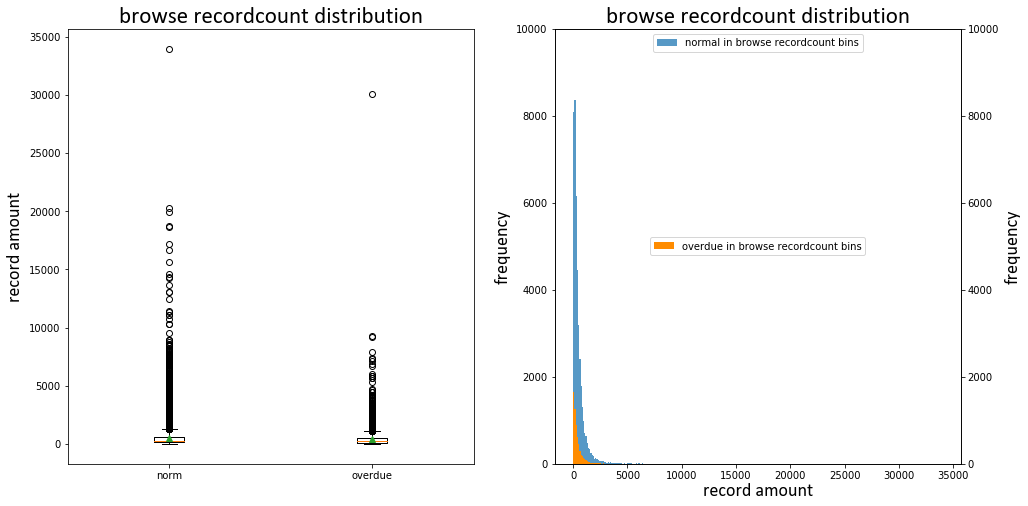

In [156]:
# browse_history_stats_train_Y 里的 browse_all_recordcount 字段（此字段无缺失值，无需处理）。
# 即对训练集里有 浏览信息的用户，分 违约 和 正常 两批进行分析。

fig7 = plt.figure(figsize = (16,8))


ax1 = fig7.add_subplot(121)
ax1.boxplot(x= [browse_history_stats_train_Y_0["browse_all_recordcount"],browse_history_stats_train_Y_1["browse_all_recordcount"]],showmeans=True)  # 做箱线图
ax1.set_title('browse recordcount distribution',fontdict=font2 ) 
ax1.set_ylabel('record amount',fontdict=font1,labelpad= 6)
ax1.set_xticklabels(["norm","overdue"])


ax2 = fig7.add_subplot(122)
n2, bins2, patches2 = ax2.hist(browse_history_stats_train_Y_0["browse_all_recordcount"], bins=300, alpha=0.75,label="normal in browse recordcount bins")  # 做直方图
ax3 = ax2.twinx()
n3, bins3, patches3 = ax3.hist(browse_history_stats_train_Y_1["browse_all_recordcount"], bins=bins2, alpha=1,label="overdue in browse recordcount bins", color="darkorange")  # 做直方图
ax2.set_title('browse recordcount distribution',fontdict=font2 ) 
ax2.set_xlabel('record amount',fontdict=font1,labelpad= 2)  
ax2.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax2.set_ylim(bottom=0 ,top =10000) 
#ax2.set_xlim(left=-1, right=20)   
ax2.legend(loc=9)
ax3.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax3.set_ylim(bottom=0 ,top =10000) 
ax3.legend(loc=10)



plt.show()

In [157]:
n2

array([8.091e+03, 8.362e+03, 6.153e+03, 4.454e+03, 3.187e+03, 2.406e+03,
       1.792e+03, 1.309e+03, 9.850e+02, 7.160e+02, 6.450e+02, 4.780e+02,
       3.620e+02, 3.490e+02, 2.400e+02, 2.000e+02, 1.900e+02, 1.150e+02,
       1.300e+02, 1.040e+02, 9.300e+01, 7.400e+01, 6.100e+01, 7.100e+01,
       5.700e+01, 4.500e+01, 4.000e+01, 2.600e+01, 3.000e+01, 2.700e+01,
       3.000e+01, 2.200e+01, 1.900e+01, 1.500e+01, 1.800e+01, 1.700e+01,
       1.300e+01, 1.000e+01, 1.400e+01, 1.000e+01, 6.000e+00, 9.000e+00,
       5.000e+00, 6.000e+00, 9.000e+00, 7.000e+00, 1.000e+01, 7.000e+00,
       4.000e+00, 3.000e+00, 6.000e+00, 8.000e+00, 2.000e+00, 8.000e+00,
       1.000e+00, 4.000e+00, 9.000e+00, 5.000e+00, 0.000e+00, 0.000e+00,
       5.000e+00, 2.000e+00, 6.000e+00, 3.000e+00, 1.000e+00, 3.000e+00,
       3.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
       2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 

In [158]:
bins2

array([1.00000000e+00, 1.14236667e+02, 2.27473333e+02, 3.40710000e+02,
       4.53946667e+02, 5.67183333e+02, 6.80420000e+02, 7.93656667e+02,
       9.06893333e+02, 1.02013000e+03, 1.13336667e+03, 1.24660333e+03,
       1.35984000e+03, 1.47307667e+03, 1.58631333e+03, 1.69955000e+03,
       1.81278667e+03, 1.92602333e+03, 2.03926000e+03, 2.15249667e+03,
       2.26573333e+03, 2.37897000e+03, 2.49220667e+03, 2.60544333e+03,
       2.71868000e+03, 2.83191667e+03, 2.94515333e+03, 3.05839000e+03,
       3.17162667e+03, 3.28486333e+03, 3.39810000e+03, 3.51133667e+03,
       3.62457333e+03, 3.73781000e+03, 3.85104667e+03, 3.96428333e+03,
       4.07752000e+03, 4.19075667e+03, 4.30399333e+03, 4.41723000e+03,
       4.53046667e+03, 4.64370333e+03, 4.75694000e+03, 4.87017667e+03,
       4.98341333e+03, 5.09665000e+03, 5.20988667e+03, 5.32312333e+03,
       5.43636000e+03, 5.54959667e+03, 5.66283333e+03, 5.77607000e+03,
       5.88930667e+03, 6.00254333e+03, 6.11578000e+03, 6.22901667e+03,
      

&ensp;&ensp; 由箱线图和直方图可见，训练集里有 浏览信息的用户里，每个用户收集到的浏览信息记录数的分布非常有偏。有个别用户的浏览信息records数特别多，我认为属于异常点，需要删去。browse_history_stats_train_Y里，以5000为分割点查找，5000以上的人有163个，6000以上103个，7000以上67个，8000以上39个。我选择 8000这个分割点，建议将8000以上的训练集用户删去。  
&ensp;&ensp; 从分布情况来说，不论违约还是正常，浏览信息条目数的分布都是有偏的。

In [159]:
tmp21 = browse_history_stats_train_Y.loc[browse_history_stats_train_Y["browse_all_recordcount"]>=8000,"browse_all_recordcount"]
browse_train_allrecordcount_outlier = tmp21.index
print("The number of outliers in all_recordcount is:", len(browse_train_allrecordcount_outlier))

The number of outliers in all_recordcount is: 39


In [160]:
browse_train_allrecordcount_outlier

Int64Index([ 2630,  3380,  3628,  6270,  8552, 10733, 11635, 12678, 13836,
            13898, 14740, 15885, 16729, 19158, 19637, 19862, 20426, 20925,
            21394, 21585, 22200, 24005, 26197, 34259, 34458, 36727, 38670,
            40865, 43952, 48659, 49036, 51854, 51855, 52064, 52985, 52989,
            53159, 54847, 54945],
           dtype='int64', name='userID')

C:\Users\shuangjun\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


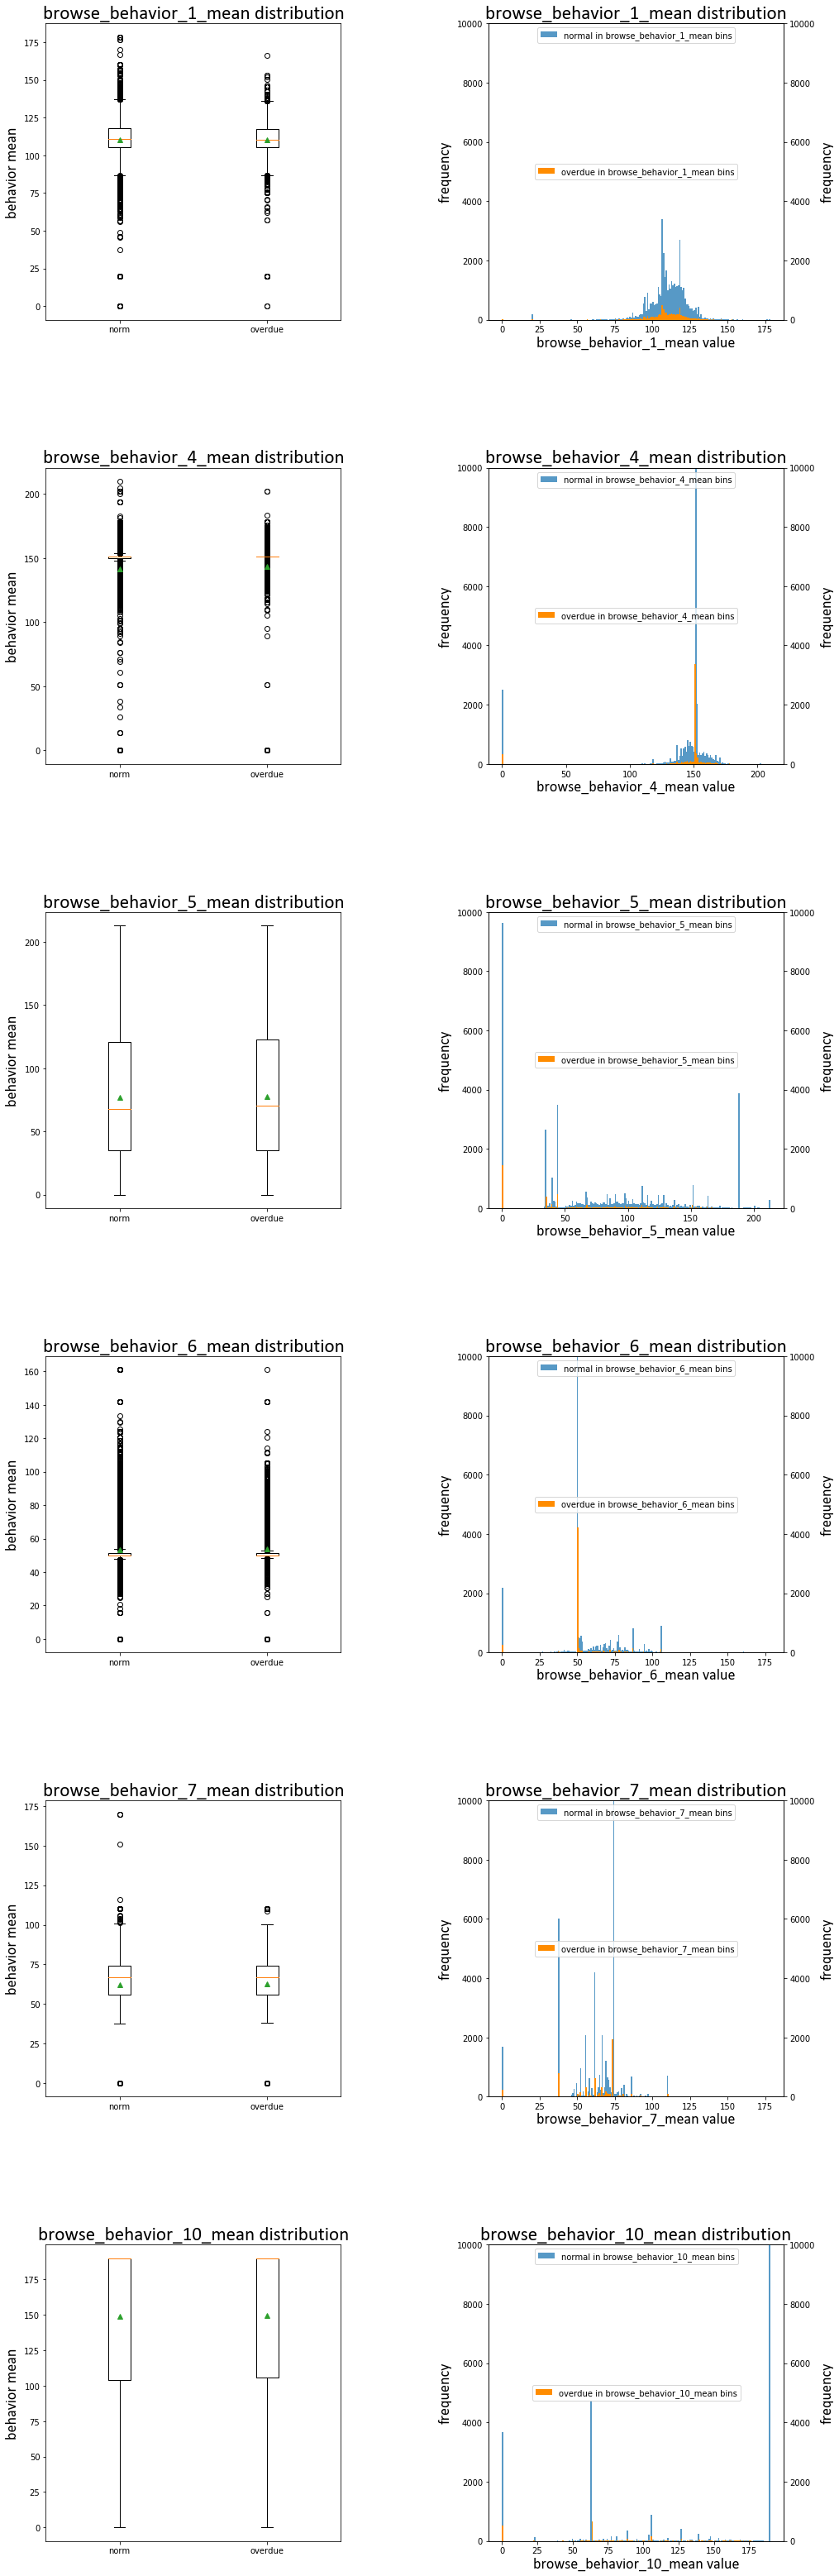

In [161]:
# browse_history_stats_train_Y 里的 browse_ALLbn_5_mean 字段（这些字段无缺失值，无需处理）。
# 即对训练集里有 浏览信息的用户，分 违约 和 正常 两批进行分析。

fig8 = plt.figure(figsize = (16,56))

# 第 1 号浏览行为

ax1 = fig8.add_subplot(621)
ax1.boxplot(x= [browse_history_stats_train_Y_0["browse_ALLbn_1_mean"],browse_history_stats_train_Y_1["browse_ALLbn_1_mean"]],showmeans=True)  # 做箱线图
ax1.set_title('browse_behavior_1_mean distribution',fontdict=font2 ) 
ax1.set_ylabel('behavior mean',fontdict=font1,labelpad= 6)
ax1.set_xticklabels(["norm","overdue"])


ax2 = fig8.add_subplot(622)
n2, bins2, patches2 = ax2.hist(browse_history_stats_train_Y_0["browse_ALLbn_1_mean"], bins=200, alpha=0.75,label="normal in browse_behavior_1_mean bins")  # 做直方图
ax3 = ax2.twinx()
n3, bins3, patches3 = ax3.hist(browse_history_stats_train_Y_1["browse_ALLbn_1_mean"], bins=bins2, alpha=1,label="overdue in browse_behavior_1_mean bins", color="darkorange")  # 做直方图
ax2.set_title('browse_behavior_1_mean distribution',fontdict=font2 ) 
ax2.set_xlabel('browse_behavior_1_mean value',fontdict=font1,labelpad= 2)  
ax2.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax2.set_ylim(bottom=0 ,top =10000) 
#ax2.set_xlim(left=-1, right=20)   
ax2.legend(loc=9)
ax3.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax3.set_ylim(bottom=0 ,top =10000) 
ax3.legend(loc=10)


# 第 4 号浏览行为

ax3 = fig8.add_subplot(623)
ax3.boxplot(x= [browse_history_stats_train_Y_0["browse_ALLbn_4_mean"],browse_history_stats_train_Y_1["browse_ALLbn_4_mean"]],showmeans=True)  # 做箱线图
ax3.set_title('browse_behavior_4_mean distribution',fontdict=font2 ) 
ax3.set_ylabel('behavior mean',fontdict=font1,labelpad= 6)
ax3.set_xticklabels(["norm","overdue"])


ax4 = fig8.add_subplot(624)
n4, bins4, patches4 = ax4.hist(browse_history_stats_train_Y_0["browse_ALLbn_4_mean"], bins=200, alpha=0.75,label="normal in browse_behavior_4_mean bins")  # 做直方图
ax5 = ax4.twinx()
n5, bins5, patches5 = ax5.hist(browse_history_stats_train_Y_1["browse_ALLbn_4_mean"], bins=bins2, alpha=1,label="overdue in browse_behavior_4_mean bins", color="darkorange")  # 做直方图
ax4.set_title('browse_behavior_4_mean distribution',fontdict=font2 ) 
ax4.set_xlabel('browse_behavior_4_mean value',fontdict=font1,labelpad= 2)  
ax4.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax4.set_ylim(bottom=0 ,top =10000) 
#ax4.set_xlim(left=-1, right=20)   
ax4.legend(loc=9)
ax5.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax5.set_ylim(bottom=0 ,top =10000) 
ax5.legend(loc=10)


# 第 5 号浏览行为

ax3 = fig8.add_subplot(625)
ax3.boxplot(x= [browse_history_stats_train_Y_0["browse_ALLbn_5_mean"],browse_history_stats_train_Y_1["browse_ALLbn_5_mean"]],showmeans=True)  # 做箱线图
ax3.set_title('browse_behavior_5_mean distribution',fontdict=font2 ) 
ax3.set_ylabel('behavior mean',fontdict=font1,labelpad= 6)
ax3.set_xticklabels(["norm","overdue"])


ax4 = fig8.add_subplot(626)
n4, bins4, patches4 = ax4.hist(browse_history_stats_train_Y_0["browse_ALLbn_5_mean"], bins=200, alpha=0.75,label="normal in browse_behavior_5_mean bins")  # 做直方图
ax5 = ax4.twinx()
n5, bins5, patches5 = ax5.hist(browse_history_stats_train_Y_1["browse_ALLbn_5_mean"], bins=bins2, alpha=1,label="overdue in browse_behavior_5_mean bins", color="darkorange")  # 做直方图
ax4.set_title('browse_behavior_5_mean distribution',fontdict=font2 ) 
ax4.set_xlabel('browse_behavior_5_mean value',fontdict=font1,labelpad= 2)  
ax4.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax4.set_ylim(bottom=0 ,top =10000) 
#ax4.set_xlim(left=-1, right=20)   
ax4.legend(loc=9)
ax5.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax5.set_ylim(bottom=0 ,top =10000) 
ax5.legend(loc=10)


# 第 6 号浏览行为

ax3 = fig8.add_subplot(627)
ax3.boxplot(x= [browse_history_stats_train_Y_0["browse_ALLbn_6_mean"],browse_history_stats_train_Y_1["browse_ALLbn_6_mean"]],showmeans=True)  # 做箱线图
ax3.set_title('browse_behavior_6_mean distribution',fontdict=font2 ) 
ax3.set_ylabel('behavior mean',fontdict=font1,labelpad= 6)
ax3.set_xticklabels(["norm","overdue"])


ax4 = fig8.add_subplot(628)
n4, bins4, patches4 = ax4.hist(browse_history_stats_train_Y_0["browse_ALLbn_6_mean"], bins=200, alpha=0.75,label="normal in browse_behavior_6_mean bins")  # 做直方图
ax5 = ax4.twinx()
n5, bins5, patches5 = ax5.hist(browse_history_stats_train_Y_1["browse_ALLbn_6_mean"], bins=bins2, alpha=1,label="overdue in browse_behavior_6_mean bins", color="darkorange")  # 做直方图
ax4.set_title('browse_behavior_6_mean distribution',fontdict=font2 ) 
ax4.set_xlabel('browse_behavior_6_mean value',fontdict=font1,labelpad= 2)  
ax4.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax4.set_ylim(bottom=0 ,top =10000) 
#ax4.set_xlim(left=-1, right=20)   
ax4.legend(loc=9)
ax5.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax5.set_ylim(bottom=0 ,top =10000) 
ax5.legend(loc=10)


# 第 7 号浏览行为

ax3 = fig8.add_subplot(629)
ax3.boxplot(x= [browse_history_stats_train_Y_0["browse_ALLbn_7_mean"],browse_history_stats_train_Y_1["browse_ALLbn_7_mean"]],showmeans=True)  # 做箱线图
ax3.set_title('browse_behavior_7_mean distribution',fontdict=font2 ) 
ax3.set_ylabel('behavior mean',fontdict=font1,labelpad= 6)
ax3.set_xticklabels(["norm","overdue"])


ax4 = fig8.add_subplot(6,2,10)
n4, bins4, patches4 = ax4.hist(browse_history_stats_train_Y_0["browse_ALLbn_7_mean"], bins=200, alpha=0.75,label="normal in browse_behavior_7_mean bins")  # 做直方图
ax5 = ax4.twinx()
n5, bins5, patches5 = ax5.hist(browse_history_stats_train_Y_1["browse_ALLbn_7_mean"], bins=bins2, alpha=1,label="overdue in browse_behavior_7_mean bins", color="darkorange")  # 做直方图
ax4.set_title('browse_behavior_7_mean distribution',fontdict=font2 ) 
ax4.set_xlabel('browse_behavior_7_mean value',fontdict=font1,labelpad= 2)  
ax4.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax4.set_ylim(bottom=0 ,top =10000) 
#ax4.set_xlim(left=-1, right=20)   
ax4.legend(loc=9)
ax5.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax5.set_ylim(bottom=0 ,top =10000) 
ax5.legend(loc=10)



# 第 10 号浏览行为

ax3 = fig8.add_subplot(6,2,11)
ax3.boxplot(x= [browse_history_stats_train_Y_0["browse_ALLbn_10_mean"],browse_history_stats_train_Y_1["browse_ALLbn_10_mean"]],showmeans=True)  # 做箱线图
ax3.set_title('browse_behavior_10_mean distribution',fontdict=font2 ) 
ax3.set_ylabel('behavior mean',fontdict=font1,labelpad= 6)
ax3.set_xticklabels(["norm","overdue"])


ax4 = fig8.add_subplot(6,2,12)
n4, bins4, patches4 = ax4.hist(browse_history_stats_train_Y_0["browse_ALLbn_10_mean"], bins=200, alpha=0.75,label="normal in browse_behavior_10_mean bins")  # 做直方图
ax5 = ax4.twinx()
n5, bins5, patches5 = ax5.hist(browse_history_stats_train_Y_1["browse_ALLbn_10_mean"], bins=bins2, alpha=1,label="overdue in browse_behavior_10_mean bins", color="darkorange")  # 做直方图
ax4.set_title('browse_behavior_10_mean distribution',fontdict=font2 ) 
ax4.set_xlabel('browse_behavior_10_mean value',fontdict=font1,labelpad= 2)  
ax4.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax4.set_ylim(bottom=0 ,top =10000) 
#ax4.set_xlim(left=-1, right=20)   
ax4.legend(loc=9)
ax5.set_ylabel('frequency',fontdict=font1,labelpad= 6)
ax5.set_ylim(bottom=0 ,top =10000) 
ax5.legend(loc=10)



plt.subplots_adjust(wspace = 0.5, hspace =0.5)  # 调整每个子图之间的距离    
plt.show()

结论：  
1. 浏览行为方面，由之前的描述统计可知，数据条目数是：1号行为>4号>7号>5号>6号>10号。从上述箱线图和直方图也可看出，1号、4号行为（勉强包括7号）不论违约还是正常，mean都比较符合正态分布。但5,6,10号行为则分布比较杂乱。在这些行为中，我用 0 填充 缺失值的缺点就能体现出来，可见 0 处的柱子非常高，尤其对 5号和10号的影响会高。 需要尝试用 中值 填充么？如果用中值填充，是不会影响太多步骤的，只需要更改 fillna(0)即可，得到的大表，该缺失的还缺失，不缺失的还不缺失。
2. 由箱线图看到，没有特别明显的异常值。（我填充的0都算比较偏的了）。可能由于数据少，所以有些的分布很杂乱。另外，由箱线图可以看到方差，4号和6号行为的方差非常小，说明其mean值非常集中，即用户在此两项行为上的浏览数据值比较集中、一致。 而 5号和10号行为的方差较大，说明用户在此两项行为上的浏览数据值比较分散。

## 4.3 bill_detail 整合

1. 有96.15%的用户有bill_detail信息，比较多。统计 bill_detail 表中，账单时间早于和晚于 loantime的条目数的比例。经统计，决定对放款前、放款后、所有时间进行计算。
2. 每个用户对应多条记录，先不考虑银行ID问题，对一个用户的所有条目，在数值字段上进行sum,max,median,mean,min统计。
3. 假设每个用户在一个银行只有一张银行卡，寻找每个银行卡的信用额度，相加得到一个用户的总信用额度。对每个用户的每张信用卡的若干字段取平均值。然后再对每个用户的各个信用卡的均值，在数值字段上进行sum,max,median,min统计。
4. 创建特征，如每个用户的bill_detail条目数、账期逾期概率、超额消费率、溢缴率，这是放款前、放款后、所有时间 三张表都有的。
5. 创建特征，每个用户的银行卡数目、每个用户的银行卡额度。这是单独的，不属于放款前、放款后、所有时间三张表。
6. 将三张表+2个独立特征 链接，成为 bill_detail_stats。

### 4.3.1 groupby and feature creation

1. 分放款前 和 所有时间（不论放款前后，时间已知未知）。
2. 对于放款前行条目，删掉 “银行ID” 这列，对每个用户ID在所有银行办理的全部银行卡 进行统计。

In [162]:
# 先把 bill_detail和 loan_time 依照 userID 融合在一起，得到 bill_detail_L，L代表此表有 loantime列。
# 将 billtime==0的记录选取出来，即时间未知的所有记录，bill_detail_L_unknown ，unknown代表时间未知。
# 将 billtime<=loantime 且 billtime!=0的记录选取出来，即放款前的所有记录，bill_detail_L_before ，before代表放款前。
# 将 billtime>loantime 的记录选取出来，即放款后的所有记录，bill_detail_L_after ，after代表放款后。

bill_detail_L = pd.merge(bill_detail,loan_time, on="userID", how="left")
bill_detail_L_unknown = bill_detail_L.loc[bill_detail_L['bill_time']==0,:]
bill_detail_L_before = bill_detail_L.loc[(bill_detail_L['bill_time']<=bill_detail_L['loan_time'])&(bill_detail_L['bill_time']!=0),:]
bill_detail_L_after = bill_detail_L.loc[bill_detail_L['bill_time']>bill_detail_L['loan_time'],:]
tmp44 = len(bill_detail_L["userID"].unique())
tmp45 = len(bill_detail_L_unknown["userID"].unique())   
tmp46 = len(bill_detail_L_before["userID"].unique())
tmp47 = len(bill_detail_L_after["userID"].unique())
tmp48 = len(user_info["userID"])
print("user number with bill_detail_L:  ",tmp44)
print("user number with bill_detail_L_unknown:  ",tmp45)
print("user number with bill_detail_L_before:  ",tmp46)
print("user number with bill_detail_L_after:  ",tmp47)
print("bill percent:",tmp44/tmp48)
print("unknown percent:",tmp45/tmp48)
print("before percent:",tmp46/tmp48)
print("after percent:",tmp47/tmp48)

user number with bill_detail_L:   66584
user number with bill_detail_L_unknown:   17498
user number with bill_detail_L_before:   54614
user number with bill_detail_L_after:   42758
bill percent: 0.9581120943952802
unknown percent: 0.2517878984099576
before percent: 0.7858694870134542
after percent: 0.615267285416217


&ensp;&ensp;可见，有bill信息的用户有6万6千人，占总用户数（训练集+未知样本集）的95%。时间未知的条目占 25%，放款前的条目 78%，放款后的条目 61%，超过一半 。所以，我认为可以分三部分：放款前分析、放款后分析、所有时间分析。

In [163]:
bill_detail_L_before.head()

,userID,bill_time,bankID,last_bill_amount,last_repay_amount,credit_limit,current_bill_balance,current_bill_minrepay,consume_num,current_bill_amount,adjust_amount,cyclic_interest,available_balance,borrow_cash,repay_status,loan_time
1,2,5904923847,4,17.389606,17.389606,19.460445,16.656269,15.366101,1,16.656269,0.0,0.0,0.0,0.0,0,5914855887
2,2,5907300387,4,16.656269,17.402921,19.460445,19.393161,17.092432,4,19.462586,0.0,0.0,0.0,0.0,0,5914855887
3,2,5908250547,16,21.580308,21.600903,0.000000,21.578907,18.590958,3,21.599530,0.0,0.0,0.0,0.0,0,5914855887
4,2,5909977167,4,19.393161,19.446400,19.460445,19.307760,17.123958,5,19.365610,0.0,0.0,0.0,0.0,0,5914855887
5,2,5910985827,16,21.578907,21.579187,0.000000,21.552968,18.557235,1,21.553256,0.0,0.0,0.0,0.0,0,5914855887


In [164]:
# 统计放款前，每个用户拥有的 bill_detail 条目记录数，并把它起名为 bill_before_recordcount
# 由 shape 可知，共有 54614 个用户有 放款前 bill_detail 信息。
# 此表无缺失。

gb9 = bill_detail_L_before.groupby(by="userID")
bill_before_recordcount = gb9.size()
bill_before_recordcount.name = "bill_before_recordcount"
bill_before_recordcount = pd.DataFrame(bill_before_recordcount)
print("shape:  ",bill_before_recordcount.shape)
bill_before_recordcount.head()

shape:   (54614, 1)


,bill_before_recordcount
userID,
2,7
4,20
6,16
7,19
9,12


In [165]:
# 对于放款前行条目，删掉 “银行ID” 这列，对每个用户ID在所有银行办理的全部银行卡 进行 groupby 统计。
# 同时还删掉了"bill_time","loan_time","repay_status"这三列。剩下的都是数值型列，值的加和有意义。
# 注意，其实比赛提供的数据集中，一行就是一个账期信息。
# pick 代表挑选特征。
# bill_detail_L_before_pick 包含了 '用户ID', '上期账单金额', '上期还款金额','信用卡额度','本期账单余额','本期账单最低还款额',
# '消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度' 这些列。 
# 注意，我本来想填上 np.std的，但是会产生缺失值。比如有某个用户，只有一行记录，且在一个字段上值为0，则对这个字段求std时就是缺失的。
# 本表无缺失。

bill_detail_L_before_pick = bill_detail_L_before.drop(["bill_time","bankID","loan_time","repay_status"],axis = 1)
gb10 = bill_detail_L_before_pick.groupby(by="userID")
bill_detail_L_before_pick_stats = gb10.aggregate([np.sum,np.max,np.median,np.mean,np.min])
print("shape:  ",bill_detail_L_before_pick_stats.shape)
bill_detail_L_before_pick_stats.head()

shape:   (54614, 55)


last_bill_amount                                              \
                    sum       amax     median       mean       amin   
userID                                                                
2             96.598251  21.580308  17.389606  13.799750   0.000000   
4            144.813292  19.483781   0.000000   7.240665   0.000000   
6            314.927082  20.681443  19.638586  19.682943  18.654047   
7            267.402239  19.861357  19.143810  14.073802   0.000000   
9            241.771564  21.330732  20.248808  20.147630  18.587637   

       last_repay_amount                                             ...   \
                     sum       amax     median       mean       amin ...    
userID                                                               ...    
2              97.419017  21.600903  17.402921  13.917002   0.000000 ...    
4             105.148045  19.483836   0.000000   5.257402   0.000000 ...    
6             270.925010  21.177840  18.997091  16.932813   0.000000 ...    
7             342.363130  21.135796  20.664428  18.019112   0.000000 ...    
9             243.389228  21.622615  20.299273  20.282436  18.907778 ...    

       available_balance                                        borrow_cash  \
                     sum       amax median      mean       amin         sum   
userID                                                                        
2               0.000000   0.000000    0.0  0.000000   0.000000   20.376736   
4              36.516325  19.662141    0.0  1.825816   0.000000  168.500217   
6              62.908887  20.464738    0.0  3.931805 -18.105068  218.464023   
7              80.907026  20.903642    0.0  4.258265   0.000000  270.987654   
9               0.000000   0.000000    0.0  0.000000   0.000000  138.242700   

                                              
             amax     median       mean amin  
userID                                        
2       20.376736   0.000000   2.910962  0.0  
4       18.767298   0.000000   8.425011  0.0  
6       20.559057  19.278123  13.654001  0.0  
7       19.460445  19.278123  14.262508  0.0  
9       20.376736  19.278123  11.520225  0.0  

[5 rows x 55 columns]

In [166]:
CF.Calnan(bill_detail_L_before_pick_stats)

,column_name,nancount,nanpercent
0,"(last_bill_amount, sum)",0,0.0
1,"(last_bill_amount, amax)",0,0.0
2,"(last_bill_amount, median)",0,0.0
3,"(last_bill_amount, mean)",0,0.0
4,"(last_bill_amount, amin)",0,0.0
5,"(last_repay_amount, sum)",0,0.0
6,"(last_repay_amount, amax)",0,0.0
7,"(last_repay_amount, median)",0,0.0
8,"(last_repay_amount, mean)",0,0.0
9,"(last_repay_amount, amin)",0,0.0


In [167]:
# 改列名
# BL代表before loan，放款前。 
# bill_BL_last_bill_amount_sum 表示 放款前某用户ID的上期账单金额列的所有条目的 值的 和。
# bill_detail_L_before_pick_stats 有 55列，分别是 （训练集+未知数据集里）有放款前bill_detail信息的用户在放款前的
# '上期账单金额', '上期还款金额','信用卡额度','本期账单余额','本期账单最低还款额','消费笔数','本期账单金额','调整金额',
# '循环利息','可用余额','预借现金额度' 的 sum, max, median, mean, min.共11*5 = 55 列。
# 本表无缺失。

L1 = ['sum','max',"median",'mean','min']
L2 = ['last_bill_amount','last_repay_amount','credit_limit','current_bill_balance','current_bill_minrepay','consume_num','current_bill_amount','adjust_amount','cyclic_interest','available_balance','borrow_cash']
L = ['_'.join(['bill_BL',i,j]) for i in L2 for j in L1]    

bill_detail_L_before_pick_stats.columns = L
print("shape:  ",bill_detail_L_before_pick_stats.shape)
bill_detail_L_before_pick_stats.head()

shape:   (54614, 55)


,bill_BL_last_bill_amount_sum,bill_BL_last_bill_amount_max,bill_BL_last_bill_amount_median,bill_BL_last_bill_amount_mean,bill_BL_last_bill_amount_min,bill_BL_last_repay_amount_sum,bill_BL_last_repay_amount_max,bill_BL_last_repay_amount_median,bill_BL_last_repay_amount_mean,bill_BL_last_repay_amount_min,...,bill_BL_available_balance_sum,bill_BL_available_balance_max,bill_BL_available_balance_median,bill_BL_available_balance_mean,bill_BL_available_balance_min,bill_BL_borrow_cash_sum,bill_BL_borrow_cash_max,bill_BL_borrow_cash_median,bill_BL_borrow_cash_mean,bill_BL_borrow_cash_min
userID,,,,,,,,,,,,,,,,,,,,,
2,96.598251,21.580308,17.389606,13.799750,0.000000,97.419017,21.600903,17.402921,13.917002,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,20.376736,20.376736,0.000000,2.910962,0.0
4,144.813292,19.483781,0.000000,7.240665,0.000000,105.148045,19.483836,0.000000,5.257402,0.000000,...,36.516325,19.662141,0.0,1.825816,0.000000,168.500217,18.767298,0.000000,8.425011,0.0
6,314.927082,20.681443,19.638586,19.682943,18.654047,270.925010,21.177840,18.997091,16.932813,0.000000,...,62.908887,20.464738,0.0,3.931805,-18.105068,218.464023,20.559057,19.278123,13.654001,0.0
7,267.402239,19.861357,19.143810,14.073802,0.000000,342.363130,21.135796,20.664428,18.019112,0.000000,...,80.907026,20.903642,0.0,4.258265,0.000000,270.987654,19.460445,19.278123,14.262508,0.0
9,241.771564,21.330732,20.248808,20.147630,18.587637,243.389228,21.622615,20.299273,20.282436,18.907778,...,0.000000,0.000000,0.0,0.000000,0.000000,138.242700,20.376736,19.278123,11.520225,0.0


In [168]:
# “repay_status”这列，是“还款状态”，因为大部分是0（正常还款），小部分是1（逾期未还）。 
# 对每个用户ID在其所有银行的所有银行卡 求 此还款状态列的 和（表示逾期次数），
# 并求此还款状态列的数量（表示收集到的所有账单次数），两者相除 表示每个用户ID在其所有银行的所有银行卡的所有收集到的账期内 
# 逾期的概率（放款前）。
# bill_BL_overdue_percent 表示 （训练集+未知数据集里）有放款前bill_detail信息的用户在放款前的 “账期逾期概率”。
# 此表无缺失。

tmp33 = bill_detail_L_before[['userID','repay_status']].groupby(by = 'userID').aggregate([np.sum, np.size])
tmp33.columns = ['tmp_sum','tmp_count'] 
tmp33 = tmp33.assign(bill_BL_overdue_percent = tmp33['tmp_sum']/tmp33['tmp_count']) # assign函数为 tmp33增加一列。
bill_BL_overdue_percent = pd.DataFrame(tmp33['bill_BL_overdue_percent'])
print("shape:  ",bill_BL_overdue_percent.shape)
bill_BL_overdue_percent.head()

shape:   (54614, 1)


,bill_BL_overdue_percent
userID,
2,0.0
4,0.0
6,0.0
7,0.0
9,0.0


In [169]:
CF.Calnan(bill_BL_overdue_percent)

,column_name,nancount,nanpercent
0,bill_BL_overdue_percent,0,0.0


In [170]:
# 可用余额 <0 表示超额消费，用每个用户放款前 可用余额<0 的次数 比上 此用户总的记录数，得到 放款前的超额消费率。
# bill_BL_excess_percent 表示（训练集+未知数据集里）有放款前bill_detail信息的用户在放款前的 超额消费率。
# 本表无缺失。

tmp35 = bill_detail_L_before[['userID','available_balance']]
tmp35["excess"] = tmp35['available_balance']<0
tmp36 = tmp35.groupby("userID").aggregate({"available_balance":np.size, "excess":np.sum})
tmp36.columns = ["num","excess_num"]
tmp36 = tmp36.assign(bill_BL_excess_percent = tmp36["excess_num"]/tmp36["num"])
bill_BL_excess_percent = pd.DataFrame(tmp36["bill_BL_excess_percent"])
print("shape:  ",bill_BL_excess_percent.shape)
bill_BL_excess_percent.head()

C:\Users\shuangjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


shape:   (54614, 1)


,bill_BL_excess_percent
userID,
2,0.0000
4,0.0000
6,0.0625
7,0.0000
9,0.0000


In [171]:
CF.Calnan(bill_BL_excess_percent)

,column_name,nancount,nanpercent
0,bill_BL_excess_percent,0,0.0


In [172]:
# 本期账单余额 <0 表示溢缴，用每个用户放款前 本期账单余额 <0  的次数 比上 此用户总的记录数，得到 放款前的溢缴率。
# bill_BL_overpay_percent 表示（训练集+未知数据集里）有放款前bill_detail信息的用户在放款前的 溢缴率。
# 本表无缺失。

tmp42 = bill_detail_L_before[['userID','current_bill_balance']]
tmp42["overpay"] = tmp42['current_bill_balance']<0
tmp43 = tmp42.groupby("userID").aggregate({"current_bill_balance":np.size, "overpay":np.sum})
tmp43.columns = ["num","overpay_num"]
tmp43 = tmp43.assign(bill_BL_overpay_percent = tmp43["overpay_num"]/tmp43["num"])
bill_BL_overpay_percent = pd.DataFrame(tmp43["bill_BL_overpay_percent"])
print("shape:  ",bill_BL_overpay_percent.shape)
bill_BL_overpay_percent.head()

C:\Users\shuangjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


shape:   (54614, 1)


,bill_BL_overpay_percent
userID,
2,0.000000
4,0.000000
6,0.062500
7,0.315789
9,0.083333


In [173]:
CF.Calnan(bill_BL_overpay_percent)

,column_name,nancount,nanpercent
0,bill_BL_overpay_percent,0,0.0


In [174]:
# 假设每个用户在每个银行有一张信用卡。每个用户的每个银行ID对应多条记录，求他们在 '上期账单金额', '上期还款金额','本期账单余额',
# '本期账单最低还款额','消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度'的平均值，
# 作为放款前，每个用户的每个银行的那张卡 平均一个账期 在这些字段上的均值。每个用户有几张卡，那在某个字段上就有几个均值。
# 然后，用 sum, max, median, min聚合函数（千万不要用 mean，会和bill_BL_XXX_mean重合）对同一个用户的几个均值进行聚合，
# 既得到 放款前，每个用户平均每个卡上，平均一个账期内，在这些字段上的 和、最大值、中值、最小值。

# bill_BL_cardM 是以 userID,bankID 为双索引，展示（训练集+未知数据集里）有放款前bill_detail信息的用户在放款前的 每个用户
# 的每个银行卡上的 某某字段的均值。字段：'上期账单金额', '上期还款金额','本期账单余额',
# '本期账单最低还款额','消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度'。
# bill_BL_cardM_stats 是以 userID为索引，展示（训练集+未知数据集里）有放款前bill_detail信息的用户在放款前的 每个用户
# 的所有银行卡上的 某字段均值 的 sum, max, median, min。字段：'上期账单金额', '上期还款金额','本期账单余额',
# '本期账单最低还款额','消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度'。
# BL代表放款前、cardM 代表每个用户的属于同一张卡的某字段的均值，bill_BL_cardM_stats 是对每个用户的几张卡的这些均值（在
# 一个字段下，此用户有几张卡，就有几个均值）的sum, max, median, min。
# 此表无缺失。


tmp39 = bill_detail_L_before[[ 'userID', 'bankID','last_bill_amount','last_repay_amount','current_bill_balance',
       'current_bill_minrepay', 'consume_num', 'current_bill_amount',
       'adjust_amount', 'cyclic_interest', 'available_balance', 'borrow_cash']]
tmp40 = tmp39.groupby(['userID', 'bankID']).aggregate(np.mean)
tmp40.columns = ['bill_BL_cardM_'+i for i in tmp40.columns]  # 改列名。BL代表放款前，cardM代表 每张卡的平均值
bill_BL_cardM = tmp40
tmp41 = bill_BL_cardM.reset_index(level=-1).drop("bankID",axis=1).groupby("userID")
bill_BL_cardM_stats = tmp41.aggregate([np.sum,np.max,np.median,np.min])

L1 = ['sum','max',"median",'min']  # 改列名
L2 = ['last_bill_amount','last_repay_amount','current_bill_balance',
       'current_bill_minrepay', 'consume_num', 'current_bill_amount',
       'adjust_amount', 'cyclic_interest', 'available_balance', 'borrow_cash']
L = ['_'.join(['bill_BL_cardM_',i,j]) for i in L2 for j in L1]    
bill_BL_cardM_stats.columns = L
print("shape:  ",bill_BL_cardM_stats.shape)
bill_BL_cardM_stats.head()

shape:   (54614, 40)


,bill_BL_cardM__last_bill_amount_sum,bill_BL_cardM__last_bill_amount_max,bill_BL_cardM__last_bill_amount_median,bill_BL_cardM__last_bill_amount_min,bill_BL_cardM__last_repay_amount_sum,bill_BL_cardM__last_repay_amount_max,bill_BL_cardM__last_repay_amount_median,bill_BL_cardM__last_repay_amount_min,bill_BL_cardM__current_bill_balance_sum,bill_BL_cardM__current_bill_balance_max,...,bill_BL_cardM__cyclic_interest_median,bill_BL_cardM__cyclic_interest_min,bill_BL_cardM__available_balance_sum,bill_BL_cardM__available_balance_max,bill_BL_cardM__available_balance_median,bill_BL_cardM__available_balance_min,bill_BL_cardM__borrow_cash_sum,bill_BL_cardM__borrow_cash_max,bill_BL_cardM__borrow_cash_median,bill_BL_cardM__borrow_cash_min
userID,,,,,,,,,,,,,,,,,,,,,
2,27.746164,14.386405,13.873082,13.359759,27.953095,14.393363,13.976548,13.559732,40.247085,21.560070,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,6.792245,6.792245,3.396123,0.0
4,18.101661,18.101661,0.000000,0.000000,13.143506,13.143506,0.000000,0.000000,55.198366,19.540666,...,0.0,0.0,4.564541,2.457768,2.106773,0.0,23.357756,18.767298,4.590458,0.0
6,59.123257,20.342580,19.469878,19.310799,50.966866,18.985339,16.090681,15.890846,51.685534,19.867388,...,0.0,0.0,12.581777,12.581777,0.000000,0.0,39.837180,20.559057,19.278123,0.0
7,42.173386,16.874108,12.649639,0.000000,65.808590,20.756443,16.105886,12.840374,16.373938,19.401172,...,0.0,0.0,20.226757,20.226757,0.000000,0.0,38.738568,19.460445,9.639061,0.0
9,60.638539,21.013929,20.231336,19.393275,61.059657,21.141414,20.292014,19.626228,47.735878,20.305336,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,39.654859,20.376736,19.278123,0.0


In [175]:
CF.Calnan(bill_BL_cardM_stats)

,column_name,nancount,nanpercent
0,bill_BL_cardM__last_bill_amount_sum,0,0.0
1,bill_BL_cardM__last_bill_amount_max,0,0.0
2,bill_BL_cardM__last_bill_amount_median,0,0.0
3,bill_BL_cardM__last_bill_amount_min,0,0.0
4,bill_BL_cardM__last_repay_amount_sum,0,0.0
5,bill_BL_cardM__last_repay_amount_max,0,0.0
6,bill_BL_cardM__last_repay_amount_median,0,0.0
7,bill_BL_cardM__last_repay_amount_min,0,0.0
8,bill_BL_cardM__current_bill_balance_sum,0,0.0
9,bill_BL_cardM__current_bill_balance_max,0,0.0


In [176]:
# 将 5 张表依 userID索引 join  起来，得到 bill_before_stats表。

# 此步得到的 bill_before_stats 的 shape为：(54614, 99)，共 99 个字段，分别为：
# 注意，所谓的每个用户是 训练集和未知数据集里有bill_detail信息的所有用户。

# bill_before_recordcount                       放款前，每个用户拥有的 bill_detail条目记录数
# bill_BL_last_XXX_sum/max/median/mean/min      放款前，每个用户的所有记录条目在某个字段上的sum/max/median/mean/min，这些字段XXX包括：
#                                                      '上期账单金额', '上期还款金额','信用卡额度','本期账单余额','本期账单最低还款额','消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度' 
# bill_BL_overdue_percent      放款前，每个用户的 “账期逾期概率”
# bill_BL_excess_percent       放款前，每个用户的 超额消费率
# bill_BL_overpay_percent      放款前，每个用户的 溢缴率
# bill_BL_cardM__XXX_sum/max/median/min         放款前，每个用户的所有银行卡上的 某字段均值 的 sum, max, median, min。
#                                               字段：'上期账单金额', '上期还款金额','本期账单余额','本期账单最低还款额','消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度'

# 一共 1 + 55 + 3 + 40 = 99 个特征。
# （本表没有缺失值）。


tmp54 = bill_before_recordcount.join(bill_detail_L_before_pick_stats)
tmp55 = tmp54.join(bill_BL_overdue_percent)
tmp56 = tmp55.join(bill_BL_excess_percent)
tmp57 = tmp56.join(bill_BL_overpay_percent)
bill_before_stats = tmp57.join(bill_BL_cardM_stats)
print("shape:  ", bill_before_stats.shape)
bill_before_stats.head()

# 这里用 merge 也可以实现需求。

shape:   (54614, 99)


,bill_before_recordcount,bill_BL_last_bill_amount_sum,bill_BL_last_bill_amount_max,bill_BL_last_bill_amount_median,bill_BL_last_bill_amount_mean,bill_BL_last_bill_amount_min,bill_BL_last_repay_amount_sum,bill_BL_last_repay_amount_max,bill_BL_last_repay_amount_median,bill_BL_last_repay_amount_mean,...,bill_BL_cardM__cyclic_interest_median,bill_BL_cardM__cyclic_interest_min,bill_BL_cardM__available_balance_sum,bill_BL_cardM__available_balance_max,bill_BL_cardM__available_balance_median,bill_BL_cardM__available_balance_min,bill_BL_cardM__borrow_cash_sum,bill_BL_cardM__borrow_cash_max,bill_BL_cardM__borrow_cash_median,bill_BL_cardM__borrow_cash_min
userID,,,,,,,,,,,,,,,,,,,,,
2,7,96.598251,21.580308,17.389606,13.799750,0.000000,97.419017,21.600903,17.402921,13.917002,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,6.792245,6.792245,3.396123,0.0
4,20,144.813292,19.483781,0.000000,7.240665,0.000000,105.148045,19.483836,0.000000,5.257402,...,0.0,0.0,4.564541,2.457768,2.106773,0.0,23.357756,18.767298,4.590458,0.0
6,16,314.927082,20.681443,19.638586,19.682943,18.654047,270.925010,21.177840,18.997091,16.932813,...,0.0,0.0,12.581777,12.581777,0.000000,0.0,39.837180,20.559057,19.278123,0.0
7,19,267.402239,19.861357,19.143810,14.073802,0.000000,342.363130,21.135796,20.664428,18.019112,...,0.0,0.0,20.226757,20.226757,0.000000,0.0,38.738568,19.460445,9.639061,0.0
9,12,241.771564,21.330732,20.248808,20.147630,18.587637,243.389228,21.622615,20.299273,20.282436,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,39.654859,20.376736,19.278123,0.0


In [177]:
CF.Calnan(bill_before_stats)["nancount"].value_counts()

0    99
Name: nancount, dtype: int64

In [178]:
bill_before_stats.columns

Index(['bill_before_recordcount', 'bill_BL_last_bill_amount_sum',
       'bill_BL_last_bill_amount_max', 'bill_BL_last_bill_amount_median',
       'bill_BL_last_bill_amount_mean', 'bill_BL_last_bill_amount_min',
       'bill_BL_last_repay_amount_sum', 'bill_BL_last_repay_amount_max',
       'bill_BL_last_repay_amount_median', 'bill_BL_last_repay_amount_mean',
       'bill_BL_last_repay_amount_min', 'bill_BL_credit_limit_sum',
       'bill_BL_credit_limit_max', 'bill_BL_credit_limit_median',
       'bill_BL_credit_limit_mean', 'bill_BL_credit_limit_min',
       'bill_BL_current_bill_balance_sum', 'bill_BL_current_bill_balance_max',
       'bill_BL_current_bill_balance_median',
       'bill_BL_current_bill_balance_mean', 'bill_BL_current_bill_balance_min',
       'bill_BL_current_bill_minrepay_sum',
       'bill_BL_current_bill_minrepay_max',
       'bill_BL_current_bill_minrepay_median',
       'bill_BL_current_bill_minrepay_mean',
       'bill_BL_current_bill_minrepay_min', 'bill_BL_co

In [179]:
# 统计放款后



# 统计放款后，每个用户拥有的 bill_detail 条目记录数，并把它起名为 bill_after_recordcount
# 由 shape 可知，共有 42758 个用户有 放款前 bill_detail 信息。
# 此表无缺失。

gb11 = bill_detail_L_after.groupby(by="userID")
bill_after_recordcount = gb11.size()
bill_after_recordcount.name = "bill_after_recordcount"
bill_after_recordcount = pd.DataFrame(bill_after_recordcount)
#print("shape:  ",bill_after_recordcount.shape)
# bill_after_recordcount.head()

# 对于放款后行条目，删掉 “银行ID” 这列，对每个用户ID在所有银行办理的全部银行卡 进行 groupby 统计。
# 同时还删掉了"bill_time","loan_time","repay_status"这三列。剩下的都是数值型列，值的加和有意义。
# 注意，其实比赛提供的数据集中，一行就是一个账期信息。
# pick 代表挑选特征。
# bill_detail_L_after_pick 包含了 '用户ID', '上期账单金额', '上期还款金额','信用卡额度','本期账单余额','本期账单最低还款额',
# '消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度' 这些列。 
# 注意，我本来想填上 np.std的，但是会产生缺失值。比如有某个用户，只有一行记录，且在一个字段上值为0，则对这个字段求std时就是缺失的。
# 本表无缺失。

bill_detail_L_after_pick = bill_detail_L_after.drop(["bill_time","bankID","loan_time","repay_status"],axis = 1)
gb12 = bill_detail_L_after_pick.groupby(by="userID")
bill_detail_L_after_pick_stats = gb12.aggregate([np.sum,np.max,np.median,np.mean,np.min])
#print("shape:  ",bill_detail_L_after_pick_stats.shape)
# bill_detail_L_after_pick_stats.head()

# 改列名
# AL 代表after loan，放款后。 
# bill_AL_last_bill_amount_sum 表示 放款后某用户ID的上期账单金额列的所有条目的 值的 和。
# bill_detail_L_after_pick_stats 有 55列，分别是 （训练集+未知数据集里）有放款后bill_detail信息的用户在放款后的
# '上期账单金额', '上期还款金额','信用卡额度','本期账单余额','本期账单最低还款额','消费笔数','本期账单金额','调整金额',
# '循环利息','可用余额','预借现金额度' 的 sum, max, median, mean, min.共11*5 = 55 列。
# 本表无缺失。

L1 = ['sum','max',"median",'mean','min']
L2 = ['last_bill_amount','last_repay_amount','credit_limit','current_bill_balance','current_bill_minrepay','consume_num','current_bill_amount','adjust_amount','cyclic_interest','available_balance','borrow_cash']
L = ['_'.join(['bill_AL',i,j]) for i in L2 for j in L1]    

bill_detail_L_after_pick_stats.columns = L
#print("shape:  ",bill_detail_L_after_pick_stats.shape)
# bill_detail_L_after_pick_stats.head()

# “repay_status”这列，是“还款状态”，因为大部分是0（正常还款），小部分是1（逾期未还）。 
# 对每个用户ID在其所有银行的所有银行卡 求 此还款状态列的 和（表示逾期次数），
# 并求此还款状态列的数量（表示收集到的所有账单次数），两者相除 表示每个用户ID在其所有银行的所有银行卡的所有收集到的账期内 
# 逾期的概率（放款后）。
# bill_AL_overdue_percent 表示 （训练集+未知数据集里）有放款后bill_detail信息的用户在放款后的 “账期逾期概率”。
# 此表无缺失。

tmp58 = bill_detail_L_after[['userID','repay_status']].groupby(by = 'userID').aggregate([np.sum, np.size])
tmp58.columns = ['tmp_sum','tmp_count'] 
tmp58 = tmp58.assign(bill_AL_overdue_percent = tmp58['tmp_sum']/tmp58['tmp_count']) # assign函数为 tmp33增加一列。
bill_AL_overdue_percent = pd.DataFrame(tmp58['bill_AL_overdue_percent'])
#print("shape:  ",bill_AL_overdue_percent.shape)
# bill_AL_overdue_percent.head()

# 可用余额 <0 表示超额消费，用每个用户放款后 可用余额<0 的次数 比上 此用户总的记录数，得到 放款后的超额消费率。
# bill_AL_excess_percent 表示（训练集+未知数据集里）有放款后bill_detail信息的用户在放款后的 超额消费率。
# 本表无缺失。

tmp59 = bill_detail_L_after[['userID','available_balance']]
tmp59["excess"] = tmp59['available_balance']<0
tmp60 = tmp59.groupby("userID").aggregate({"available_balance":np.size, "excess":np.sum})
tmp60.columns = ["num","excess_num"]
tmp60 = tmp60.assign(bill_AL_excess_percent = tmp60["excess_num"]/tmp60["num"])
bill_AL_excess_percent = pd.DataFrame(tmp60["bill_AL_excess_percent"])
#print("shape:  ",bill_AL_excess_percent.shape)
bill_AL_excess_percent.head()

# 本期账单余额 <0 表示溢缴，用每个用户放款后 本期账单余额 <0  的次数 比上 此用户总的记录数，得到 放款后的溢缴率。
# bill_AL_overpay_percent 表示（训练集+未知数据集里）有放款后bill_detail信息的用户在放款后的 溢缴率。
# 本表无缺失。

tmp61 = bill_detail_L_after[['userID','current_bill_balance']]
tmp61["overpay"] = tmp61['current_bill_balance']<0
tmp62 = tmp61.groupby("userID").aggregate({"current_bill_balance":np.size, "overpay":np.sum})
tmp62.columns = ["num","overpay_num"]
tmp62 = tmp62.assign(bill_AL_overpay_percent = tmp62["overpay_num"]/tmp62["num"])
bill_AL_overpay_percent = pd.DataFrame(tmp62["bill_AL_overpay_percent"])
#print("shape:  ",bill_AL_overpay_percent.shape)
# bill_AL_overpay_percent.head()

# 假设每个用户在每个银行有一张信用卡。每个用户的每个银行ID对应多条记录，求他们在 '上期账单金额', '上期还款金额','本期账单余额',
# '本期账单最低还款额','消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度'的平均值，
# 作为放款后，每个用户的每个银行的那张卡 平均一个账期 在这些字段上的均值。每个用户有几张卡，那在某个字段上就有几个均值。
# 然后，用 sum, max, median, min聚合函数（千万不要用 mean，会和bill_AL_XXX_mean重合）对同一个用户的几个均值进行聚合，
# 既得到 放款后，每个用户平均每个卡上，平均一个账期内，在这些字段上的 和、最大值、中值、最小值。

# bill_AL_cardM 是以 userID,bankID 为双索引，展示（训练集+未知数据集里）有放款后bill_detail信息的用户在放款后的 每个用户
# 的每个银行卡上的 某某字段的均值。字段：'上期账单金额', '上期还款金额','本期账单余额',
# '本期账单最低还款额','消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度'。
# bill_AL_cardM_stats 是以 userID为索引，展示（训练集+未知数据集里）有放款后bill_detail信息的用户在放款后的 每个用户
# 的所有银行卡上的 某字段均值 的 sum, max, median, min。字段：'上期账单金额', '上期还款金额','本期账单余额',
# '本期账单最低还款额','消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度'。
# AL代表放款后、cardM 代表每个用户的属于同一张卡的某字段的均值，bill_AL_cardM_stats 是对每个用户的几张卡的这些均值（在
# 一个字段下，此用户有几张卡，就有几个均值）的sum, max, median, min。
# 此表无缺失。


tmp63 = bill_detail_L_after[[ 'userID', 'bankID','last_bill_amount','last_repay_amount','current_bill_balance',
       'current_bill_minrepay', 'consume_num', 'current_bill_amount',
       'adjust_amount', 'cyclic_interest', 'available_balance', 'borrow_cash']]
tmp64 = tmp63.groupby(['userID', 'bankID']).aggregate(np.mean)
tmp64.columns = ['bill_AL_cardM_'+i for i in tmp64.columns]  # 改列名。AL代表放款后，cardM代表 每张卡的平均值
bill_AL_cardM = tmp64
tmp65 = bill_AL_cardM.reset_index(level=-1).drop("bankID",axis=1).groupby("userID")
bill_AL_cardM_stats = tmp65.aggregate([np.sum,np.max,np.median,np.min])

L1 = ['sum','max',"median",'min']  # 改列名
L2 = ['last_bill_amount','last_repay_amount','current_bill_balance',
       'current_bill_minrepay', 'consume_num', 'current_bill_amount',
       'adjust_amount', 'cyclic_interest', 'available_balance', 'borrow_cash']
L = ['_'.join(['bill_AL_cardM_',i,j]) for i in L2 for j in L1]    
bill_AL_cardM_stats.columns = L
#print("shape:  ",bill_AL_cardM_stats.shape)
# bill_AL_cardM_stats.head()



# 将 5 张表依 userID索引 join  起来，得到 bill_after_stats表。

# 此步得到的 bill_after_stats 的 shape为：(42758, 99)，共 99 个字段，分别为：
# 注意，所谓的每个用户是 训练集和未知数据集里有bill_detail信息的所有用户。

# bill_after_recordcount                       放款后，每个用户拥有的 bill_detail条目记录数
# bill_AL_last_XXX_sum/max/median/mean/min      放款后，每个用户的所有记录条目在某个字段上的sum/max/median/mean/min，这些字段XXX包括：
#                                                      '上期账单金额', '上期还款金额','信用卡额度','本期账单余额','本期账单最低还款额','消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度' 
# bill_AL_overdue_percent      放款后，每个用户的 “账期逾期概率”
# bill_AL_excess_percent       放款后，每个用户的 超额消费率
# bill_AL_overpay_percent      放款后，每个用户的 溢缴率
# bill_AL_cardM__XXX_sum/max/median/min         放款后，每个用户的所有银行卡上的 某字段均值 的 sum, max, median, min。
#                                               字段：'上期账单金额', '上期还款金额','本期账单余额','本期账单最低还款额','消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度'

# 一共 1 + 55 + 3 + 40 = 99 个特征。
# （本表没有缺失值）。


tmp66 = bill_after_recordcount.join(bill_detail_L_after_pick_stats)
tmp67 = tmp66.join(bill_AL_overdue_percent)
tmp68 = tmp67.join(bill_AL_excess_percent)
tmp69 = tmp68.join(bill_AL_overpay_percent)
bill_after_stats = tmp69.join(bill_AL_cardM_stats)
print("shape:  ", bill_after_stats.shape)
bill_after_stats.head()


C:\Users\shuangjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\shuangjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


shape:   (42758, 99)


,bill_after_recordcount,bill_AL_last_bill_amount_sum,bill_AL_last_bill_amount_max,bill_AL_last_bill_amount_median,bill_AL_last_bill_amount_mean,bill_AL_last_bill_amount_min,bill_AL_last_repay_amount_sum,bill_AL_last_repay_amount_max,bill_AL_last_repay_amount_median,bill_AL_last_repay_amount_mean,...,bill_AL_cardM__cyclic_interest_median,bill_AL_cardM__cyclic_interest_min,bill_AL_cardM__available_balance_sum,bill_AL_cardM__available_balance_max,bill_AL_cardM__available_balance_median,bill_AL_cardM__available_balance_min,bill_AL_cardM__borrow_cash_sum,bill_AL_cardM__borrow_cash_max,bill_AL_cardM__borrow_cash_median,bill_AL_cardM__borrow_cash_min
userID,,,,,,,,,,,,,,,,,,,,,
2,12,186.611583,21.560264,20.552983,15.550965,0.0,179.694984,21.693954,19.249254,14.974582,...,0.0,0.0,0.000000,0.000000,0.0,0.0,20.376736,20.376736,0.000000,0.000000
4,16,116.837059,19.638332,0.000000,7.302316,0.0,73.005098,18.892461,0.000000,4.562819,...,0.0,0.0,0.000000,0.000000,0.0,0.0,18.767298,18.767298,0.000000,0.000000
7,20,378.804298,21.487808,19.747997,18.940215,0.0,386.857484,21.729404,20.324660,19.342874,...,0.0,0.0,19.558163,19.558163,0.0,0.0,39.158416,19.697971,9.730222,0.000000
8,4,0.000000,0.000000,0.000000,0.000000,0.0,70.682736,17.670684,17.670684,17.670684,...,0.0,0.0,0.000000,0.000000,0.0,0.0,20.376736,20.376736,20.376736,20.376736
10,48,910.681152,20.663117,19.779739,18.972524,0.0,896.187482,20.671592,19.748127,18.670573,...,0.0,0.0,0.000000,0.000000,0.0,0.0,19.278123,19.278123,0.000000,0.000000


In [180]:
CF.Calnan(bill_after_stats)["nancount"].value_counts()

0    99
Name: nancount, dtype: int64

In [181]:
bill_after_stats.columns

Index(['bill_after_recordcount', 'bill_AL_last_bill_amount_sum',
       'bill_AL_last_bill_amount_max', 'bill_AL_last_bill_amount_median',
       'bill_AL_last_bill_amount_mean', 'bill_AL_last_bill_amount_min',
       'bill_AL_last_repay_amount_sum', 'bill_AL_last_repay_amount_max',
       'bill_AL_last_repay_amount_median', 'bill_AL_last_repay_amount_mean',
       'bill_AL_last_repay_amount_min', 'bill_AL_credit_limit_sum',
       'bill_AL_credit_limit_max', 'bill_AL_credit_limit_median',
       'bill_AL_credit_limit_mean', 'bill_AL_credit_limit_min',
       'bill_AL_current_bill_balance_sum', 'bill_AL_current_bill_balance_max',
       'bill_AL_current_bill_balance_median',
       'bill_AL_current_bill_balance_mean', 'bill_AL_current_bill_balance_min',
       'bill_AL_current_bill_minrepay_sum',
       'bill_AL_current_bill_minrepay_max',
       'bill_AL_current_bill_minrepay_median',
       'bill_AL_current_bill_minrepay_mean',
       'bill_AL_current_bill_minrepay_min', 'bill_AL_con

In [182]:
# 统计所有时间（不论放款前、放款后、时间已知未知）



# 统计所有时间，每个用户拥有的 bill_detail 条目记录数，并把它起名为 bill_all_recordcount
# 由 shape 可知，共有 66584 个用户有 所有时间 bill_detail 信息。
# 此表无缺失。

gb11 = bill_detail_L.groupby(by="userID")
bill_all_recordcount = gb11.size()
bill_all_recordcount.name = "bill_all_recordcount"
bill_all_recordcount = pd.DataFrame(bill_all_recordcount)
#print("shape:  ",bill_all_recordcount.shape)
# bill_all_recordcount.head()

# 对于所有时间行条目，删掉 “银行ID” 这列，对每个用户ID在所有银行办理的全部银行卡 进行 groupby 统计。
# 同时还删掉了"bill_time","loan_time","repay_status"这三列。剩下的都是数值型列，值的加和有意义。
# 注意，其实比赛提供的数据集中，一行就是一个账期信息。
# pick 代表挑选特征。
# bill_detail_L_all_pick 包含了 '用户ID', '上期账单金额', '上期还款金额','信用卡额度','本期账单余额','本期账单最低还款额',
# '消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度' 这些列。 
# 注意，我本来想填上 np.std的，但是会产生缺失值。比如有某个用户，只有一行记录，且在一个字段上值为0，则对这个字段求std时就是缺失的。
# 本表无缺失。

bill_detail_L_all_pick = bill_detail_L.drop(["bill_time","bankID","loan_time","repay_status"],axis = 1)
gb12 = bill_detail_L_all_pick.groupby(by="userID")
bill_detail_L_all_pick_stats = gb12.aggregate([np.sum,np.max,np.median,np.mean,np.min])
#print("shape:  ",bill_detail_L_all_pick_stats.shape)
# bill_detail_L_all_pick_stats.head()

# 改列名
# ALL 代表ALL time，所有时间。 
# bill_ALL_last_bill_amount_sum 表示 所有时间某用户ID的上期账单金额列的所有条目的 值的 和。
# bill_detail_L_all_pick_stats 有 55列，分别是 （训练集+未知数据集里）有所有时间bill_detail信息的用户在所有时间的
# '上期账单金额', '上期还款金额','信用卡额度','本期账单余额','本期账单最低还款额','消费笔数','本期账单金额','调整金额',
# '循环利息','可用余额','预借现金额度' 的 sum, max, median, mean, min.共11*5 = 55 列。
# 本表无缺失。

L1 = ['sum','max',"median",'mean','min']
L2 = ['last_bill_amount','last_repay_amount','credit_limit','current_bill_balance','current_bill_minrepay','consume_num','current_bill_amount','adjust_amount','cyclic_interest','available_balance','borrow_cash']
L = ['_'.join(['bill_ALL',i,j]) for i in L2 for j in L1]    

bill_detail_L_all_pick_stats.columns = L
#print("shape:  ",bill_detail_L_all_pick_stats.shape)
# bill_detail_L_all_pick_stats.head()

# “repay_status”这列，是“还款状态”，因为大部分是0（正常还款），小部分是1（逾期未还）。 
# 对每个用户ID在其所有银行的所有银行卡 求 此还款状态列的 和（表示逾期次数），
# 并求此还款状态列的数量（表示收集到的所有账单次数），两者相除 表示每个用户ID在其所有银行的所有银行卡的所有收集到的账期内 
# 逾期的概率（所有时间）。
# bill_ALL_overdue_percent 表示 （训练集+未知数据集里）有所有时间bill_detail信息的用户在所有时间的 “账期逾期概率”。
# 此表无缺失。

tmp58 = bill_detail_L[['userID','repay_status']].groupby(by = 'userID').aggregate([np.sum, np.size])
tmp58.columns = ['tmp_sum','tmp_count'] 
tmp58 = tmp58.assign(bill_ALL_overdue_percent = tmp58['tmp_sum']/tmp58['tmp_count']) # assign函数为 tmp33增加一列。
bill_ALL_overdue_percent = pd.DataFrame(tmp58['bill_ALL_overdue_percent'])
#print("shape:  ",bill_ALL_overdue_percent.shape)
# bill_ALL_overdue_percent.head()

# 可用余额 <0 表示超额消费，用每个用户所有时间 可用余额<0 的次数 比上 此用户总的记录数，得到 所有时间的超额消费率。
# bill_ALL_excess_percent 表示（训练集+未知数据集里）有所有时间bill_detail信息的用户在所有时间的 超额消费率。
# 本表无缺失。

tmp59 = bill_detail_L[['userID','available_balance']]
tmp59["excess"] = tmp59['available_balance']<0
tmp60 = tmp59.groupby("userID").aggregate({"available_balance":np.size, "excess":np.sum})
tmp60.columns = ["num","excess_num"]
tmp60 = tmp60.assign(bill_ALL_excess_percent = tmp60["excess_num"]/tmp60["num"])
bill_ALL_excess_percent = pd.DataFrame(tmp60["bill_ALL_excess_percent"])
#print("shape:  ",bill_ALL_excess_percent.shape)
bill_ALL_excess_percent.head()

# 本期账单余额 <0 表示溢缴，用每个用户放款后 本期账单余额 <0  的次数 比上 此用户总的记录数，得到 所有时间的溢缴率。
# bill_ALL_overpay_percent 表示（训练集+未知数据集里）有所有时间bill_detail信息的用户在所有时间的 溢缴率。
# 本表无缺失。

tmp61 = bill_detail_L[['userID','current_bill_balance']]
tmp61["overpay"] = tmp61['current_bill_balance']<0
tmp62 = tmp61.groupby("userID").aggregate({"current_bill_balance":np.size, "overpay":np.sum})
tmp62.columns = ["num","overpay_num"]
tmp62 = tmp62.assign(bill_ALL_overpay_percent = tmp62["overpay_num"]/tmp62["num"])
bill_ALL_overpay_percent = pd.DataFrame(tmp62["bill_ALL_overpay_percent"])
#print("shape:  ",bill_ALL_overpay_percent.shape)
# bill_ALL_overpay_percent.head()

# 假设每个用户在每个银行有一张信用卡。每个用户的每个银行ID对应多条记录，求他们在 '上期账单金额', '上期还款金额','本期账单余额',
# '本期账单最低还款额','消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度'的平均值，
# 作为所有时间，每个用户的每个银行的那张卡 平均一个账期 在这些字段上的均值。每个用户有几张卡，那在某个字段上就有几个均值。
# 然后，用 sum, max, median, min聚合函数（千万不要用 mean，会和bill_ALL_XXX_mean重合）对同一个用户的几个均值进行聚合，
# 既得到 所有时间，每个用户平均每个卡上，平均一个账期内，在这些字段上的 和、最大值、中值、最小值。

# bill_ALL_cardM 是以 userID,bankID 为双索引，展示（训练集+未知数据集里）有所有时间bill_detail信息的用户在所有时间的 每个用户
# 的每个银行卡上的 某某字段的均值。字段：'上期账单金额', '上期还款金额','本期账单余额',
# '本期账单最低还款额','消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度'。
# bill_ALL_cardM_stats 是以 userID为索引，展示（训练集+未知数据集里）有所有时间bill_detail信息的用户在所有时间的 每个用户
# 的所有银行卡上的 某字段均值 的 sum, max, median, min。字段：'上期账单金额', '上期还款金额','本期账单余额',
# '本期账单最低还款额','消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度'。
# ALL代表所有时间、cardM 代表每个用户的属于同一张卡的某字段的均值，bill_ALL_cardM_stats 是对每个用户的几张卡的这些均值（在
# 一个字段下，此用户有几张卡，就有几个均值）的sum, max, median, min。
# 此表无缺失。


tmp63 = bill_detail_L[[ 'userID', 'bankID','last_bill_amount','last_repay_amount','current_bill_balance',
       'current_bill_minrepay', 'consume_num', 'current_bill_amount',
       'adjust_amount', 'cyclic_interest', 'available_balance', 'borrow_cash']]
tmp64 = tmp63.groupby(['userID', 'bankID']).aggregate(np.mean)
tmp64.columns = ['bill_ALL_cardM_'+i for i in tmp64.columns]  # 改列名。ALL代表放款前，cardM代表 每张卡的平均值
bill_ALL_cardM = tmp64
tmp65 = bill_ALL_cardM.reset_index(level=-1).drop("bankID",axis=1).groupby("userID")
bill_ALL_cardM_stats = tmp65.aggregate([np.sum,np.max,np.median,np.min])

L1 = ['sum','max',"median",'min']  # 改列名
L2 = ['last_bill_amount','last_repay_amount','current_bill_balance',
       'current_bill_minrepay', 'consume_num', 'current_bill_amount',
       'adjust_amount', 'cyclic_interest', 'available_balance', 'borrow_cash']
L = ['_'.join(['bill_ALL_cardM_',i,j]) for i in L2 for j in L1]    
bill_ALL_cardM_stats.columns = L
#print("shape:  ",bill_ALL_cardM_stats.shape)
# bill_ALL_cardM_stats.head()



# 将 5 张表依 userID索引 join  起来，得到 bill_all_stats表。

# 此步得到的 bill_all_stats 的 shape为：(66584, 99)，共 99 个字段，分别为：
# 注意，所谓的每个用户是 训练集和未知数据集里有bill_detail信息的所有用户。

# bill_all_recordcount                          所有时间，每个用户拥有的 bill_detail条目记录数
# bill_ALL_last_XXX_sum/max/median/mean/min     所有时间，每个用户的所有记录条目在某个字段上的sum/max/median/mean/min，这些字段XXX包括：
#                                                      '上期账单金额', '上期还款金额','信用卡额度','本期账单余额','本期账单最低还款额','消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度' 
# bill_ALL_overdue_percent      所有时间，每个用户的 “账期逾期概率”
# bill_ALL_excess_percent       所有时间，每个用户的 超额消费率
# bill_ALL_overpay_percent      所有时间，每个用户的 溢缴率
# bill_ALL_cardM__XXX_sum/max/median/min         所有时间，每个用户的所有银行卡上的 某字段均值 的 sum, max, median, min。
#                                               字段：'上期账单金额', '上期还款金额','本期账单余额','本期账单最低还款额','消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度'

# 一共 1 + 55 + 3 + 40 = 99 个特征。
# （本表没有缺失值）。


tmp66 = bill_all_recordcount.join(bill_detail_L_all_pick_stats)
tmp67 = tmp66.join(bill_ALL_overdue_percent)
tmp68 = tmp67.join(bill_ALL_excess_percent)
tmp69 = tmp68.join(bill_ALL_overpay_percent)
bill_all_stats = tmp69.join(bill_ALL_cardM_stats)
print("shape:  ", bill_all_stats.shape)
bill_all_stats.head()

C:\Users\shuangjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\shuangjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


shape:   (66584, 99)


,bill_all_recordcount,bill_ALL_last_bill_amount_sum,bill_ALL_last_bill_amount_max,bill_ALL_last_bill_amount_median,bill_ALL_last_bill_amount_mean,bill_ALL_last_bill_amount_min,bill_ALL_last_repay_amount_sum,bill_ALL_last_repay_amount_max,bill_ALL_last_repay_amount_median,bill_ALL_last_repay_amount_mean,...,bill_ALL_cardM__cyclic_interest_median,bill_ALL_cardM__cyclic_interest_min,bill_ALL_cardM__available_balance_sum,bill_ALL_cardM__available_balance_max,bill_ALL_cardM__available_balance_median,bill_ALL_cardM__available_balance_min,bill_ALL_cardM__borrow_cash_sum,bill_ALL_cardM__borrow_cash_max,bill_ALL_cardM__borrow_cash_median,bill_ALL_cardM__borrow_cash_min
userID,,,,,,,,,,,,,,,,,,,,,
2,20,300.599440,21.580308,19.254119,15.029972,0.000000,294.503607,21.693954,18.222086,14.725180,...,0.0,0.0,0.000000,0.000000,0.00000,0.0,16.301389,16.301389,0.000000,0.000000
3,2,36.733542,18.371030,18.366771,18.366771,18.362512,37.160348,19.495329,18.580174,18.580174,...,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000
4,36,261.650351,19.638332,0.000000,7.268065,0.000000,178.153143,19.483836,0.000000,4.948698,...,0.0,0.0,2.608309,1.404439,1.20387,0.0,21.062527,18.767298,2.295229,0.000000
5,2,41.358453,20.681871,20.679226,20.679226,20.676582,37.079520,18.560684,18.539760,18.539760,...,0.0,0.0,0.000000,0.000000,0.00000,0.0,19.971271,19.971271,19.971271,19.971271
6,41,821.750504,21.198821,20.104726,20.042695,18.654047,710.899003,21.177840,18.949619,17.339000,...,0.0,0.0,6.378576,6.378576,0.00000,0.0,39.978219,20.559057,19.419162,0.000000


In [183]:
CF.Calnan(bill_all_stats)["nancount"].value_counts()

0    99
Name: nancount, dtype: int64

In [184]:
bill_all_stats.columns

Index(['bill_all_recordcount', 'bill_ALL_last_bill_amount_sum',
       'bill_ALL_last_bill_amount_max', 'bill_ALL_last_bill_amount_median',
       'bill_ALL_last_bill_amount_mean', 'bill_ALL_last_bill_amount_min',
       'bill_ALL_last_repay_amount_sum', 'bill_ALL_last_repay_amount_max',
       'bill_ALL_last_repay_amount_median', 'bill_ALL_last_repay_amount_mean',
       'bill_ALL_last_repay_amount_min', 'bill_ALL_credit_limit_sum',
       'bill_ALL_credit_limit_max', 'bill_ALL_credit_limit_median',
       'bill_ALL_credit_limit_mean', 'bill_ALL_credit_limit_min',
       'bill_ALL_current_bill_balance_sum',
       'bill_ALL_current_bill_balance_max',
       'bill_ALL_current_bill_balance_median',
       'bill_ALL_current_bill_balance_mean',
       'bill_ALL_current_bill_balance_min',
       'bill_ALL_current_bill_minrepay_sum',
       'bill_ALL_current_bill_minrepay_max',
       'bill_ALL_current_bill_minrepay_median',
       'bill_ALL_current_bill_minrepay_mean',
       'bill_ALL_cur

In [185]:
# 因为每个用户可能都办有不同银行的银行卡，所以可以计算每个用户有多少张银行卡card_count。
# 并假设一个用户在一家银行只办一张信用卡。
# 创建一列，即每个用户持有的信用卡数量（假设每个用户在每个银行只办一张信用卡），即 card_count 这个 series。
# 此列可以和之前的总结表合起来。
# bill_card_count 表示 （训练集+未知数据集里）有 bill_detail信息的用户的信用卡数量。
# 此表无缺失。

tmp34 = bill_detail_L[['userID','bankID']].drop_duplicates()
card_count = tmp34.groupby('userID').size()
card_count.name = 'bill_card_count'
bill_card_count = pd.DataFrame(card_count)
print("shape:  ",bill_card_count.shape)
bill_card_count.head()

# bill_detailL[['userID','bankID']] 可能会有一个用户在一家银行办的一张银行卡有多条账单记录的情况，所以需要
# drop_duplicate()去重。


shape:   (66584, 1)


,bill_card_count
userID,
2,3
3,1
4,3
5,1
6,3


In [186]:
CF.Calnan(bill_card_count)

,column_name,nancount,nanpercent
0,bill_card_count,0,0.0


In [187]:
# bill_detail_L表中，每个用户ID对应若干条条目，这若干条条目的银行ID不一定相同，也就是说，每个用户可能在好几个银行都办了信用卡，
# 所以这些条目是属于不同银行的信用卡的，每张信用卡可能对应多个条目。而一个用户是可以在一家银行办理多张信用卡的，所以，同一个用户，
# 同一个银行ID的行条目，可能是属于不同卡的。但是，经查证，https://zhidao.baidu.com/question/120279288.html 
# 一个用户在一家银行若办理多张银行卡，则这几张银行卡的信用额度是共享的，也就是说两张卡，一个额度2W，一个额度1W，如果1W的卡刷光，
# 另一个卡就只能刷1W，如果2W的卡刷光，1W的卡就没额度了，所以透支额度是共享的，办再多也不能增加额度，
# 所以在一家银行没有必要办多张信用卡（除非是方便家人共同使用）。所以，我觉得，可以这样处理数据：对于同一个用户ID，
# 认为他在一个银行只有一张信用卡，而同一用户同一个信用卡ID的若干条记录就当做这张信用卡的若干个账期数据（每条记录是一个账期），
# 一个用户一个银行ID对应的若干条条目，取credit_limit列的最大值作为这张信用卡的信用额度，然后，一个用户在几个银行都各有一张卡，
# 将同一用户名下的这几张卡的信用额度加起来得到信用额度和。

# bill_credit_limit_cardsum 表示 （训练集+未知数据集里）有 bill_detail信息的用户的若干张信用卡的信用额度的和
# （设一个用户可能在几个银行都开户，但每个银行只有一张卡，此值就是统计每个用户的这几张卡的信用额度的和）。
# 此表无缺失

tmp37 = bill_detail_L[['userID','bankID','credit_limit']].groupby(['userID','bankID']).aggregate(np.max) # 获得了 每个用户在每个银行的 最大信用额度。
tmp38 = tmp37.reset_index(level = -1).drop("bankID",axis=1).groupby("userID").aggregate(np.sum)
tmp38.columns = ["bill_credit_limit_cardsum"]
bill_credit_limit_cardsum = tmp38
print("shape:  ",bill_credit_limit_cardsum.shape)
bill_credit_limit_cardsum.head()

shape:   (66584, 1)


,bill_credit_limit_cardsum
userID,
2,61.523250
3,18.361833
4,59.110850
5,20.664418
6,62.615441


In [188]:
CF.Calnan(bill_credit_limit_cardsum)

,column_name,nancount,nanpercent
0,bill_credit_limit_cardsum,0,0.0


In [189]:
# 所有时间信息 bill_all_stats(66584*99)，放款前信息 bill_before_stats(54614*99)，放款后信息 bill_after_stats(42758*99),
# 信用卡数目 bill_card_count(66584*1)，用户信用卡额度和 bill_credit_limit_cardsum(66584*1) 
# 这 5 张表 结合起来。此 5 张表本身都没有缺失。

# 此步得到的 bill_detail_stats 的 shape为： (66584, 300)，共 300个字段，分别为：

# userID               拥有 bill_detail的（训练集+未知样本集）用户的ID

# 来自 bill_all_stats 的 99 列：
# bill_all_recordcount                          所有时间，每个用户拥有的 bill_detail条目记录数
# bill_ALL_last_XXX_sum/max/median/mean/min     所有时间，每个用户的所有记录条目在某个字段上的sum/max/median/mean/min，这些字段XXX包括：
#                                                      '上期账单金额', '上期还款金额','信用卡额度','本期账单余额','本期账单最低还款额','消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度' 
# bill_ALL_overdue_percent      所有时间，每个用户的 “账期逾期概率”
# bill_ALL_excess_percent       所有时间，每个用户的 超额消费率
# bill_ALL_overpay_percent      所有时间，每个用户的 溢缴率
# bill_ALL_cardM__XXX_sum/max/median/min         所有时间，每个用户的所有银行卡上的 某字段均值 的 sum, max, median, min。
#                                               字段：'上期账单金额', '上期还款金额','本期账单余额','本期账单最低还款额','消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度'

# 来自 bill_before_stats 的 99 列：
# bill_before_recordcount                       放款前，每个用户拥有的 bill_detail条目记录数
# bill_BL_last_XXX_sum/max/median/mean/min      放款前，每个用户的所有记录条目在某个字段上的sum/max/median/mean/min，这些字段XXX包括：
#                                                      '上期账单金额', '上期还款金额','信用卡额度','本期账单余额','本期账单最低还款额','消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度' 
# bill_BL_overdue_percent      放款前，每个用户的 “账期逾期概率”
# bill_BL_excess_percent       放款前，每个用户的 超额消费率
# bill_BL_overpay_percent      放款前，每个用户的 溢缴率
# bill_BL_cardM__XXX_sum/max/median/min         放款前，每个用户的所有银行卡上的 某字段均值 的 sum, max, median, min。
#                                               字段：'上期账单金额', '上期还款金额','本期账单余额','本期账单最低还款额','消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度'

# 来自 bill_after_stats 的 99 列：
# bill_after_recordcount                       放款后，每个用户拥有的 bill_detail条目记录数
# bill_AL_last_XXX_sum/max/median/mean/min      放款后，每个用户的所有记录条目在某个字段上的sum/max/median/mean/min，这些字段XXX包括：
#                                                      '上期账单金额', '上期还款金额','信用卡额度','本期账单余额','本期账单最低还款额','消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度' 
# bill_AL_overdue_percent      放款后，每个用户的 “账期逾期概率”
# bill_AL_excess_percent       放款后，每个用户的 超额消费率
# bill_AL_overpay_percent      放款后，每个用户的 溢缴率
# bill_AL_cardM__XXX_sum/max/median/min         放款后，每个用户的所有银行卡上的 某字段均值 的 sum, max, median, min。
#                                               字段：'上期账单金额', '上期还款金额','本期账单余额','本期账单最低还款额','消费笔数','本期账单金额','调整金额','循环利息','可用余额','预借现金额度'

# 来自 bill_card_count 的 1 列：
# bill_card_count              有 bill_detail信息的用户的信用卡数量

# 来自 bill_credit_limit_cardsum 的 1 列：
# bill_credit_limit_cardsum    有 bill_detail信息的用户的若干张信用卡的信用额度的和


# 缺失值问题：
# bill_detail_stats 表的 shape: (66584, 300)。里面，userID列、来自表 bill_all_stats、bill_card_count、bill_credit_limit_cardsum
# 的列都无缺失值。缺失值集中在  放款前bill_before_stats 和 放款后bill_after_stats 两表中。
# 由于缺失值较多，此处不进行填充，而在以后采用算法填充。



tmp70 = bill_all_stats.join(bill_before_stats)
tmp71 = tmp70.join(bill_after_stats)
tmp72 = tmp71.join(bill_card_count)
bill_detail_stats = tmp72.join(bill_credit_limit_cardsum).reset_index()

print("shape:  ", bill_detail_stats.shape)
bill_detail_stats.head()

shape:   (66584, 300)


,userID,bill_all_recordcount,bill_ALL_last_bill_amount_sum,bill_ALL_last_bill_amount_max,bill_ALL_last_bill_amount_median,bill_ALL_last_bill_amount_mean,bill_ALL_last_bill_amount_min,bill_ALL_last_repay_amount_sum,bill_ALL_last_repay_amount_max,bill_ALL_last_repay_amount_median,...,bill_AL_cardM__available_balance_sum,bill_AL_cardM__available_balance_max,bill_AL_cardM__available_balance_median,bill_AL_cardM__available_balance_min,bill_AL_cardM__borrow_cash_sum,bill_AL_cardM__borrow_cash_max,bill_AL_cardM__borrow_cash_median,bill_AL_cardM__borrow_cash_min,bill_card_count,bill_credit_limit_cardsum
0,2,20,300.599440,21.580308,19.254119,15.029972,0.000000,294.503607,21.693954,18.222086,...,0.0,0.0,0.0,0.0,20.376736,20.376736,0.0,0.0,3,61.523250
1,3,2,36.733542,18.371030,18.366771,18.366771,18.362512,37.160348,19.495329,18.580174,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,18.361833
2,4,36,261.650351,19.638332,0.000000,7.268065,0.000000,178.153143,19.483836,0.000000,...,0.0,0.0,0.0,0.0,18.767298,18.767298,0.0,0.0,3,59.110850
3,5,2,41.358453,20.681871,20.679226,20.679226,20.676582,37.079520,18.560684,18.539760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20.664418
4,6,41,821.750504,21.198821,20.104726,20.042695,18.654047,710.899003,21.177840,18.949619,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,62.615441


# 5. 汇总表与缺失值填充

1. user_info(69495*6)、loan_time(69495*2)、overdue(69495*2)三者均包含训练集+未知样本集，前两者无缺失，后者在未知样本的target上缺失。  bank_detail_stats(10003*8)、browse_history_stats(59327*8)、bill_detail_stats(66584*300)三者均包含训练集+未知样本集，前者无缺失、后两者都有缺失。训练集+未知样本集共 69495人，其中训练集 55596人，未知样本集 13899人。
2. 将以上六张表依userID链接到一起，起名 data_origin_1（包含训练集+未知样本集） 。
3. trainuser_without_bankbrowsebill、bank_train_outincome_ratio_outlier、bank_train_income_sum_outlier、bank_train_outcome_sum_outlier、browse_train_allrecordcount_outlier 是各个阶段找出的“训练集”里的异常点，需要删除。它们都是 userID，有的是set格式，有的是index格式，需要汇总去重（唯一化）后，从训练集中删去。注意，测试集里肯定也有异常点，但测试集不能碰。只能删掉训练集里的异常userID。
4. user_info、loan_time、overdue 三部分，user_info都是类别变量，应该onehot。loan_time只有一个连续数值变量，暂时保持不变。（后期可能要标准化），overdue不能处理。
5. bank_detail_stats部分（无缺失）：因为只有14.39%的用户有 bank 信息，太少，所以这样处理：对于 条目数、收入sum、收入count、支出sum、支出count、支出占收入比 这几个字段，都是数值型列，先用MDLP最优分箱离散化，然后把总数据集中没有 bank 信息的用户记为“缺失箱”即可。但需要注意，应该先分离出训练集，然后对训练集的这些字段进行最优分箱，然后把分箱节点应用到未知数据集上对其分箱。然后onehot（这时可以训练集和未知数据集一起）。 而 是否有工资信息 字段，是类别变量，已有工资信息记为2、没有工资记为1、总数据集中没有 bank 信息的用户记为0“缺失”即可。然后onehot（训练集和未知数据集可以一起）。
6. browse_history_stats部分（有缺失）：因为有85.37%的用户有 browse 信息，较多，所以这样处理：此部分的所有列都是数值型列（除userID外），所以缺失值用算法填充（算法填充时，用训练集得到的模型，填充训练集的缺失和未知样本集的缺失）。
7. bill_detail_stats部分（有缺失）：因为有96.15%的用户有bill信息，比较多，所以这样处理：此部分的所有列都是数值型列（除userID外），所以缺失值用算法填充（算法填充时，用训练集得到的模型，填充训练集的缺失和未知样本集的缺失）。


## 5.1 预处理

In [190]:
# 将 user_info、bank_detail_stats、browse_history_stats、bill_detail_stats、loan_time、overdue五张表 merge，
# 得到 data_origin_1.


tmp73 = pd.merge(user_info,bank_detail_stats,how="left",on="userID")
tmp74 = pd.merge(tmp73,browse_history_stats,how="left",on="userID")
tmp75 = pd.merge(tmp74,bill_detail_stats,how="left",on="userID")
tmp76 = pd.merge(tmp75,loan_time,how="left",on="userID")
data_origin_1 = pd.merge(tmp76,overdue,how="left",on="userID")
print("shape of data_origin_1: ", data_origin_1.shape)
data_origin_1.head(5)

shape of data_origin_1:  (69495, 390)


,userID,gender,career,education,marriage,residence,bank_detail_record_count,bank_income_sum,bank_income_count,bank_outcome_sum,...,bill_AL_cardM__available_balance_median,bill_AL_cardM__available_balance_min,bill_AL_cardM__borrow_cash_sum,bill_AL_cardM__borrow_cash_max,bill_AL_cardM__borrow_cash_median,bill_AL_cardM__borrow_cash_min,bill_card_count,bill_credit_limit_cardsum,loan_time,target
0,1,1,2,3,1,3,86.0,480.692762,35.0,676.025269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5914855887,0.0
1,2,1,2,3,2,1,NaN,NaN,NaN,NaN,...,0.0,0.0,20.376736,20.376736,0.0,0.0,3.0,61.523250,5914855887,0.0
2,3,1,4,4,1,4,679.0,2278.873446,172.0,4985.957607,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,18.361833,5914855887,0.0
3,4,1,4,4,3,2,291.0,1164.342384,96.0,2129.425722,...,0.0,0.0,18.767298,18.767298,0.0,0.0,3.0,59.110850,5914855887,1.0
4,5,1,2,2,3,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,20.664418,5914855887,0.0


In [191]:
# 计算 trainuser_without_bankbrowsebill、bank_train_outincome_ratio_outlier、bank_train_income_sum_outlier、
# bank_train_outcome_sum_outlier、browse_train_allrecordcount_outlier 内含的训练集异常点的userID并集，共215个异常点。
# 从 data_origin_1 中删去这些 异常点，得到 data_origin_2.

tmp77 = set(trainuser_without_bankbrowsebill)
tmp78 = set(bank_train_outincome_ratio_outlier)
tmp79 = set(bank_train_income_sum_outlier)
tmp80 = set(bank_train_outcome_sum_outlier)
tmp81 = set(browse_train_allrecordcount_outlier)
outlier_userID = tmp77|tmp78|tmp79|tmp80|tmp81
print("The number of outlier is: ", len(outlier_userID))

data_origin_2 = data_origin_1.set_index("userID").drop(list(outlier_userID))
print("shape of data_origin_2: ", data_origin_2.shape)
data_origin_2.head()

The number of outlier is:  215
shape of data_origin_2:  (69280, 389)


,gender,career,education,marriage,residence,bank_detail_record_count,bank_income_sum,bank_income_count,bank_outcome_sum,bank_outcome_count,...,bill_AL_cardM__available_balance_median,bill_AL_cardM__available_balance_min,bill_AL_cardM__borrow_cash_sum,bill_AL_cardM__borrow_cash_max,bill_AL_cardM__borrow_cash_median,bill_AL_cardM__borrow_cash_min,bill_card_count,bill_credit_limit_cardsum,loan_time,target
userID,,,,,,,,,,,,,,,,,,,,,
1,1,2,3,1,3,86.0,480.692762,35.0,676.025269,51.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5914855887,0.0
2,1,2,3,2,1,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,20.376736,20.376736,0.0,0.0,3.0,61.523250,5914855887,0.0
3,1,4,4,1,4,679.0,2278.873446,172.0,4985.957607,507.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,18.361833,5914855887,0.0
4,1,4,4,3,2,291.0,1164.342384,96.0,2129.425722,195.0,...,0.0,0.0,18.767298,18.767298,0.0,0.0,3.0,59.110850,5914855887,1.0
5,1,2,2,3,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,20.664418,5914855887,0.0


In [192]:
# 得到去掉异常点后的训练集的 userID构成的列表 userIDtrain，现在训练集共 55381 个用户。
# 得到未知样本集的 userID构成的列表 userIDtest，现在未知样本集共 13899 个用户。
# 从 data_origin_2 中提取出 训练集 data_origin_2_train，未知样本集 data_origin_2_test。


userIDtrain = list(set(overdue_train.reset_index()['userID'])-outlier_userID)  # 得到了删去异常点后的训练集的 用户ID构成的列表。用来提取 训练集。
userIDtest = list(overdue_test.reset_index()['userID'])  # 得到了未知样本集的 用户ID构成的集合。用来提取 未知样本集。
print("The number of train without outliers is: ",len(userIDtrain))
print("The number of test is: ",len(userIDtest))

data_origin_2_train = data_origin_2.loc[userIDtrain,:]
print("shape of data_origin_2_train is:",data_origin_2_train.shape )
data_origin_2_test = data_origin_2.loc[userIDtest,:]
print("shape of data_origin_2_test is:",data_origin_2_test.shape )

The number of train without outliers is:  55381
The number of test is:  13899
shape of data_origin_2_train is: (55381, 389)
shape of data_origin_2_test is: (13899, 389)


## 5.2 bank_detail 分箱处理

&ensp;&ensp;bank_detail_stats部分：对于 条目数、收入sum、收入count、支出sum、支出count、支出占收入比 这几个字段，都是数值型列，先用MDLP最优分箱离散化，然后把总数据集中没有 bank 信息的用户记为“缺失箱”即可。但需要注意，应该先分离出训练集，然后对训练集的这些字段进行最优分箱，然后把分箱节点应用到未知数据集上对其分箱。然后onehot（这时可以训练集和未知数据集一起）。 而 是否有工资信息 字段，是类别变量，已有工资信息记为2、没有工资记为1、总数据集中没有 bank 信息的用户记为0“缺失”即可。然后onehot（训练集和未知数据集可以一起）。

In [193]:
# bank_detail_stats 的 shape为：(10003, 8)，共 8个字段，分别为：
# userID                     训练集和未知数据集里有bank_detail信息的所有用户
# bank_detail_record_count   每个userID拥有的bank_detail信息的条目数。
# bank_income_sum            每个userID的 总收入。
# bank_income_count          每个userID的 收入笔数。
# bank_outcome_sum           每个userID的 总支出。
# bank_outcome_count         每个userID的 支出笔数。
# bank_salary_record         每个userID 是否有 工资信息（有工资信息的记为2，没工资信息的记为1）
# bank_out/income            每个userID的 支出占收入比


In [194]:
# c 是从 bank_detail里提取出来的要进行分箱的列名，共6个：条目数、收入sum、收入count、支出sum、支出count、支出占收入比。
# 调用自定义函数 CF.bank_detail_change，实现对这 6 个列的最优分箱和转化。（对训练集最优分箱，并对训练集进行转换。然后把训练集
# 的最优分箱的各箱值域应用到未知样本集上，对未知样本集进行转换。转换的结果是，对一个变量，第一个箱的样本的值被转化为0，第二个
# 箱的为1，第三个箱的为2....）。此函数接收了训练集data_origin_2_train和未知样本集data_origin_2_test，但只对它们的bank_detail
# 的那六列进行转换，返回转换后的bank_detail部分的训练集 和 未知样本集。
# 正则参数a=0.0015是反复试验得到的，能够把这六列的每列分成两到四箱。
# 函数运行过程中会打印出对每个列字段的最优分箱建议，包括MDLP算法的 Ps 和 binsinfo。以及 binsvalue（各箱值域）。

t0 = time.time()
c = ["bank_detail_record_count" ,"bank_income_sum", "bank_income_count" ,"bank_outcome_sum" ,"bank_outcome_count","bank_out/income" ]
bank_detail_train_changed1,bank_detail_test_changed1=CF.bank_detail_change(data_origin_2_train.reset_index(), data_origin_2_test.reset_index(), "userID", c, "target", 0.0015)
t1 = time.time()
print(t1-t0)

------- 结果为  bank_detail_record_count  -------
划分点： Ps =  [5203]
各分箱： binsinfo =  [[0, 5203, 0.6600380123872718, 0], [5204, 9136, 0.5818232376090253, 0]]
binsvalue =  [[1.0, 576.0], [576.0, 3810.0]]
------- 结果为  bank_income_sum  -------
划分点： Ps =  [2, 1000, 3974]
各分箱： binsinfo =  [[0, 2, 0.0, 0], [3, 1000, 0.7227289742146383, 0], [1001, 3974, 0.658795866551041, 0], [3975, 9136, 0.5864263486530137, 0]]
binsvalue =  [[0.0, 6.562638000000001], [6.8499669999999995, 473.98908399999976], [474.1277089999999, 1495.6673489999996], [1495.8838430000005, 10994.517722999984]]
------- 结果为  bank_income_count  -------
划分点： Ps =  [3615]
各分箱： binsinfo =  [[0, 3615, 0.6716074371572747, 0], [3616, 9136, 0.5969322933850869, 0]]
binsvalue =  [[0.0, 109.0], [109.0, 900.0]]
------- 结果为  bank_outcome_sum  -------
划分点： Ps =  [3685, 3814]
各分箱： binsinfo =  [[0, 3685, 0.6714073677899599, 0], [3686, 3814, 0.843349289138202, 0], [3815, 9136, 0.5881229453823549, 0]]
binsvalue =  [[0.0, 3189.439852000003], [3189.58034

In [195]:
print("shape of bank_detail_train_changed is : ",bank_detail_train_changed1.shape)
bank_detail_train_changed1.head()

shape of bank_detail_train_changed is :  (55381, 6)


,bank_detail_record_count,bank_income_sum,bank_income_count,bank_outcome_sum,bank_outcome_count,bank_out/income
userID,,,,,,
1,0,2,0,0,0,0
2,2,4,2,3,2,2
3,1,3,1,2,1,0
4,0,2,0,0,0,0
5,2,4,2,3,2,2


In [196]:
print("shape of bank_detail_test_changed is : ",bank_detail_test_changed1.shape)
bank_detail_test_changed1.head()

shape of bank_detail_test_changed is :  (13899, 6)


,bank_detail_record_count,bank_income_sum,bank_income_count,bank_outcome_sum,bank_outcome_count,bank_out/income
userID,,,,,,
55597,0,1,0,0,0,0
55598,2,4,2,3,2,2
55599,1,3,1,2,1,0
55600,2,4,2,3,2,2
55601,2,4,2,3,2,2


In [197]:
# 将 bank_detail_train_changed1 和 bank_detail_test_changed1 上下 concat 得到大表 bank_detail_changed1。（含训练集与未知数据集）
# 我们看到此表里的值不再是连续值，而都是0,1,2,3,4等离散值。

bank_detail_changed1 = pd.concat([bank_detail_train_changed1,bank_detail_test_changed1])
print("shape of bank_detail_changed1 is: ",bank_detail_changed1.shape)
bank_detail_changed1.head()

shape of bank_detail_changed1 is:  (69280, 6)


,bank_detail_record_count,bank_income_sum,bank_income_count,bank_outcome_sum,bank_outcome_count,bank_out/income
userID,,,,,,
1,0,2,0,0,0,0
2,2,4,2,3,2,2
3,1,3,1,2,1,0
4,0,2,0,0,0,0
5,2,4,2,3,2,2


In [198]:
CF.Calnan(bank_detail_changed1)

,column_name,nancount,nanpercent
0,bank_detail_record_count,0,0.0
1,bank_income_sum,0,0.0
2,bank_income_count,0,0.0
3,bank_outcome_sum,0,0.0
4,bank_outcome_count,0,0.0
5,bank_out/income,0,0.0


In [199]:
# 对 bank_detail 里的 是否有工资信息 字段 进行处理。
# 此字段是类别变量，已有工资信息已记为2、没有工资信息的已记为1。而总数据集中没有 bank 信息的用户现在是nan，
# 我需要将之转换为0，代表“缺失”类别。然后onehot。
# 因为此过程只以每个userID为单位进行改变，所以可以训练集和未知数据集一起进行。

tmp82 = pd.DataFrame(data_origin_2["bank_salary_record"])
tmp82.fillna(0,inplace=True)
tmp82 = tmp82.astype(np.int64)

bank_detail_changed = pd.concat([bank_detail_changed1,tmp82],axis=1)  # 将之前分箱后转化的6个列 和 此列 concat，得到7个列
print("shape of bank_detail_changed is: ", bank_detail_changed.shape)
bank_detail_changed.head()

shape of bank_detail_changed is:  (69280, 7)


,bank_detail_record_count,bank_income_sum,bank_income_count,bank_outcome_sum,bank_outcome_count,bank_out/income,bank_salary_record
userID,,,,,,,
1,0,2,0,0,0,0,1
2,2,4,2,3,2,2,0
3,1,3,1,2,1,0,1
4,0,2,0,0,0,0,1
5,2,4,2,3,2,2,0


In [200]:
CF.Calnan(bank_detail_changed)

,column_name,nancount,nanpercent
0,bank_detail_record_count,0,0.0
1,bank_income_sum,0,0.0
2,bank_income_count,0,0.0
3,bank_outcome_sum,0,0.0
4,bank_outcome_count,0,0.0
5,bank_out/income,0,0.0
6,bank_salary_record,0,0.0


In [201]:
# 将 bank_detail_changed 进行 onehot转换。得到的 bank_detail_OHE 是onehot之后的 bank_detail_changed，是ndarray格式。

enc_bank = OneHotEncoder(sparse=False)
bank_detail_OHE = enc_bank.fit_transform(bank_detail_changed)
bank_detail_OHE = bank_detail_OHE.astype(np.int64)   # 转换类型
print("shape of bank_detail_OHE is: ", bank_detail_OHE.shape)
bank_detail_OHE

shape of bank_detail_OHE is:  (69280, 24)


array([[1, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 0]], dtype=int64)

In [202]:
# 将 bank_detail_OHE转化为 dataframe 并改列名。

# bank_detail_OHE 是 对bank_detail部分的最终转化版本。其shape是 (69280, 24).
# userID 为 用户ID。
# 其列为:
# bank_detail_record_count_OHE_0/1/2   每个userID拥有的bank_detail信息的条目数。共3列。
# bank_income_sum_OHE_0/1/2/3/4        每个userID的 总收入。共5列。
# bank_income_count_OHE_0/1/2          每个userID的 收入笔数。共3列。
# bank_outcome_sum_OHE_0/1/2/3         每个userID的 总支出。共4列。
# bank_outcome_count_OHE_0/1/2         每个userID的 支出笔数。共3列。
# bank_salary_record_OHE_0/1/2         每个userID 是否有 工资信息（onehot之前，有工资信息的记为2，没工资信息的记为1,没有bank信息的为0）。共3列。
# bank_out/income_OHE_0/1/2            每个userID的 支出占收入比。共3列。
# (注意，本表无缺失。本表包含了训练集和未知样本集。本表是 onehot 后的表)

bank_index = bank_detail_changed.index
bank_columns = bank_detail_changed.columns
L = ['_'.join([i,"OHE",str(k)]) for i,j in zip(bank_columns,enc_bank.n_values_ ) for k in range(j) ]

bank_detail_OHE = pd.DataFrame(bank_detail_OHE, columns=L, index=bank_index)
print("shape of bank_detail_OHE is: ",bank_detail_OHE.shape)
bank_detail_OHE.head()

# L 为创建的列名，相当于：
# for i,j in zip(columns,enc_bank.n_values_):  # columns是未onehot时的原列名。enc_bank.n_values_是每个列onehot后得到的列数。
#     for k in range(j):
#         L.append('_'.join([i,"OHE",str(k)]))

shape of bank_detail_OHE is:  (69280, 24)


,bank_detail_record_count_OHE_0,bank_detail_record_count_OHE_1,bank_detail_record_count_OHE_2,bank_income_sum_OHE_0,bank_income_sum_OHE_1,bank_income_sum_OHE_2,bank_income_sum_OHE_3,bank_income_sum_OHE_4,bank_income_count_OHE_0,bank_income_count_OHE_1,...,bank_outcome_sum_OHE_3,bank_outcome_count_OHE_0,bank_outcome_count_OHE_1,bank_outcome_count_OHE_2,bank_out/income_OHE_0,bank_out/income_OHE_1,bank_out/income_OHE_2,bank_salary_record_OHE_0,bank_salary_record_OHE_1,bank_salary_record_OHE_2
userID,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,1,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
2,0,0,1,0,0,0,0,1,0,0,...,1,0,0,1,0,0,1,1,0,0
3,0,1,0,0,0,0,1,0,0,1,...,0,0,1,0,1,0,0,0,1,0
4,1,0,0,0,0,1,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
5,0,0,1,0,0,0,0,1,0,0,...,1,0,0,1,0,0,1,1,0,0


In [203]:
CF.Calnan(bank_detail_OHE)

,column_name,nancount,nanpercent
0,bank_detail_record_count_OHE_0,0,0.0
1,bank_detail_record_count_OHE_1,0,0.0
2,bank_detail_record_count_OHE_2,0,0.0
3,bank_income_sum_OHE_0,0,0.0
4,bank_income_sum_OHE_1,0,0.0
5,bank_income_sum_OHE_2,0,0.0
6,bank_income_sum_OHE_3,0,0.0
7,bank_income_sum_OHE_4,0,0.0
8,bank_income_count_OHE_0,0,0.0
9,bank_income_count_OHE_1,0,0.0


## 5.3 user_info

&ensp;&ensp;data_origin_2中，user_info部分无缺失，且对应的都是类别变量，应该onehot。此处做这个工作。另外，因为onehot是针对每个样本的，所以可以训练集和未知数据集一起进行。

In [204]:
data_origin_2.head()

,gender,career,education,marriage,residence,bank_detail_record_count,bank_income_sum,bank_income_count,bank_outcome_sum,bank_outcome_count,...,bill_AL_cardM__available_balance_median,bill_AL_cardM__available_balance_min,bill_AL_cardM__borrow_cash_sum,bill_AL_cardM__borrow_cash_max,bill_AL_cardM__borrow_cash_median,bill_AL_cardM__borrow_cash_min,bill_card_count,bill_credit_limit_cardsum,loan_time,target
userID,,,,,,,,,,,,,,,,,,,,,
1,1,2,3,1,3,86.0,480.692762,35.0,676.025269,51.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5914855887,0.0
2,1,2,3,2,1,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,20.376736,20.376736,0.0,0.0,3.0,61.523250,5914855887,0.0
3,1,4,4,1,4,679.0,2278.873446,172.0,4985.957607,507.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,18.361833,5914855887,0.0
4,1,4,4,3,2,291.0,1164.342384,96.0,2129.425722,195.0,...,0.0,0.0,18.767298,18.767298,0.0,0.0,3.0,59.110850,5914855887,1.0
5,1,2,2,3,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,20.664418,5914855887,0.0


In [205]:
# 把 user_info 进行 onehot转换，得到 user_info_OHE。

# user_info_OHE 是 user_info 部分的完全转化版本，其 shape 是：(69280, 24)
# user_info_OHE的列：

# gender_OHE_0/1/2         每个userID的性别。共3列。
# career_OHE_0/1/2/3/4     每个userID的职业。共5列。
# education_0/1/2/3/4      每个userID的教育。共5列。
# marriage_0/1/2/3/4/5     每个userID的婚姻。共6列。
# residence_0/1/2/3/4      每个userID的户口。共5列。
# （本表无缺失值，已 onehot，包含训练集和未知样本集）

c = ["gender","career","education","marriage","residence"]
tmp83 = data_origin_2[c]
enc_userinfo = OneHotEncoder(sparse=False)
user_info_OHE = enc_userinfo.fit_transform(tmp83)
user_info_OHE = user_info_OHE.astype(np.int64)   # 转换类型


# 改列名
userinfo_index = tmp83.index
userinfo_columns = tmp83.columns
L = ['_'.join([i,"OHE",str(k)]) for i,j in zip(userinfo_columns,enc_userinfo.n_values_ ) for k in range(j)]

user_info_OHE = pd.DataFrame(user_info_OHE, columns=L, index=userinfo_index)
print("shape of user_info_OHE is: ",user_info_OHE.shape)
user_info_OHE.head()

shape of user_info_OHE is:  (69280, 24)


,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,marriage_OHE_1,marriage_OHE_2,marriage_OHE_3,marriage_OHE_4,marriage_OHE_5,residence_OHE_0,residence_OHE_1,residence_OHE_2,residence_OHE_3,residence_OHE_4
userID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
5,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [206]:
CF.Calnan(user_info_OHE)

,column_name,nancount,nanpercent
0,gender_OHE_0,0,0.0
1,gender_OHE_1,0,0.0
2,gender_OHE_2,0,0.0
3,career_OHE_0,0,0.0
4,career_OHE_1,0,0.0
5,career_OHE_2,0,0.0
6,career_OHE_3,0,0.0
7,career_OHE_4,0,0.0
8,education_OHE_0,0,0.0
9,education_OHE_1,0,0.0


## 5.4 browse_history_stats 和 bill_detail_stats

&ensp;&ensp;browse_history_stats部分（有缺失）：因为有85.37%的用户有 browse 信息，较多，所以这样处理：此部分的所有列都是数值型列（除userID外），所以缺失值用算法填充（算法填充时，用训练集得到的模型，填充训练集的缺失和未知样本集的缺失）。  

&ensp;&ensp;bill_detail_stats部分（有缺失）：因为有96.15%的用户有bill信息，比较多，所以这样处理：此部分的所有列都是数值型列（除userID外），所以缺失值用算法填充（算法填充时，，用训练集得到的模型，填充训练集的缺失和未知样本集的缺失）。  

&ensp;&ensp;因为自定义函数RFR_fillna在填充时，需要使用完整的列做参考，所以能够依靠的只有 user_info_OHE，bank_detail_OHE，loan_time，因为现在只有他们三个是完整的。我觉得browse_history_stats 和 bill_detail_stats可以分开填充，先填充browse_history_stats，得到完整表后，就可以把browse_history_stats结合到user_info_OHE，bank_detail_OHE，loan_time上，然后一起去进行bill_detail_stats的填充。这样，bill_detail_stats在填充时，可以多依赖一部分。否则，如果browse_history_stats 和 bill_detail_stats一起填充，则它们都只能依赖user_info_OHE，bank_detail_OHE，loan_time。

In [207]:
# 从原表中得到user_info_OHE,bank_detail_OHE,loan_time这三部分，都是完全已知无缺失的，将它们合并得到df_ref1.
# 从原表中得到原来 browse_history_stats对应的 浏览信息部分，它的各个列都是数值型列且是有缺失的，待填充，为 df_withnan1.

tmp84 = data_origin_2.loc[:,"loan_time"]
df_ref1= pd.concat([user_info_OHE,bank_detail_OHE,tmp84],axis=1) 
df_withnan1 = data_origin_2.loc[:,"browse_all_recordcount":"browse_BLbn_10_count"]
print("shape of df_ref1 is:",df_ref1.shape)
print("shape of df_withnan1 is:",df_withnan1.shape)

shape of df_ref1 is: (69280, 49)
shape of df_withnan1 is: (69280, 76)


In [208]:
# 本函数用来依据没有缺失值的表填充有缺失值的表。
# 参数：
# df_ref 是完整的无任何缺失值的列构成的dataframe，以userID为行索引，可以作为算法填充缺失值的参考列。
# df_withnan 是所有有缺失值且需要用算法填充的列构成的dataframe，以userID为行索引，df_withnan必须与df_ref的行数相同！！
# userIDtrain和userIDtest分别是训练集的userID构成的list和未知样本集的userID构成的list。
# 返回值：
# 返回一个dataframe，是 df_ref和已填充的 df_withnan 左右concat之后得到的表，此表是完整的，没有缺失值。

# 基本思路见《SKlearn 缺失值处理方式》




def RFR_fillna(df_ref, df_withnan, userIDtrain, userIDtest):    # 用 随机森林回归算法填充缺失值。
    
    df_fillna = []  # 把 df_withnan中每个填充好的列收集到 df_fillna 里
    
    for i in df_withnan.columns :  # 对 df_withnan 里的每一列进行循环填充
        df = pd.concat([pd.DataFrame(df_withnan.loc[:,i]),df_ref],axis=1)  # 把待填充列 i 与 df_ref 左右连接得到 df，且列 i在最左侧
        
        df_train = df.loc[userIDtrain,:]
        df_test = df.loc[userIDtest,:]
        
        df_train_complete = df_train.loc[df_train[i].notnull(),:]
        df_train_incomplete = df_train.loc[df_train[i].isnull(),:]
        df_test_complete = df_test.loc[df_test[i].notnull(),:]
        df_test_incomplete = df_test.loc[df_test[i].isnull(),:]
        
               
        X_tr = df_train_complete.iloc[:,1:]  
        Y_tr = df_train_complete.iloc[:,0]
        X_te = pd.concat([df_train_incomplete.iloc[:,1:],df_test_incomplete.iloc[:,1:]])
        
        regr = RandomForestRegressor(n_estimators = 20,max_depth=10,random_state=0,n_jobs=-1) # 注意，一定设置random_state，以保证下一次的填充是一样的。
        regr.fit(X_tr,Y_tr)
        index = X_te.index
        tmp1=pd.DataFrame(regr.predict(X_te),index=index,columns=[i]) 
        
        # 将 df_complete的第 i 列和 tmp1 上下连接，得到 column_fillna，它是完整的填充好的第 i 列。
        column_fillna = pd.concat([pd.DataFrame(Y_tr),tmp1,pd.DataFrame(df_test_complete.loc[:,i])]).sort_index() 
        df_fillna.append(column_fillna)  # 将填充好的第 i 列添加到 df_fillna 里收集起来
        
    tmp = pd.concat(df_fillna,axis=1) # tmp是已经填充好缺失值的 df_withnan.
    return pd.concat([df_ref,tmp],axis = 1)  # 将 df_ref 和 tmp 左右结合，返回，即完整的没有缺失值的 整个表。
         

In [209]:
# 使用自定义函数 RFR_fillna，对 browse部分的缺失值进行填充（训练集+未知样本集），得到完全填充的 user_info,bank_detail,loan_time,
# browse_history左右concat构成的表 browse_complete.此表的shape为(69280, 125)，完全无缺失。

t0 = time.time()
browse_complete = RFR_fillna(df_ref1, df_withnan1, userIDtrain, userIDtest)
t1 = time.time()
print("Time: {:.3f} seconds".format(t1-t0))

# 随机森林里 n_estimators =10, max_depth=5时用时 65.7s。 max_depth=10时用时 82s
# 随机森林里 n_estimators =20, max_depth=10时用时 125s。 

Time: 134.067 seconds


In [210]:
print("shape of browse_complete is:",browse_complete.shape)
browse_complete.head()

shape of browse_complete is: (69280, 125)


,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,browse_BLbn_5_min,browse_BLbn_6_min,browse_BLbn_7_min,browse_BLbn_10_min,browse_BLbn_1_count,browse_BLbn_4_count,browse_BLbn_5_count,browse_BLbn_6_count,browse_BLbn_7_count,browse_BLbn_10_count
userID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,0,0,0,0,...,42.645163,44.020016,38.170320,148.913129,145.679365,47.431893,36.603805,32.578424,26.439743,21.435619
2,0,1,0,0,0,1,0,0,0,0,...,44.000000,7.000000,38.000000,190.000000,540.000000,150.000000,105.000000,135.000000,105.000000,75.000000
3,0,1,0,0,0,0,0,1,0,0,...,35.000000,50.000000,38.000000,190.000000,174.000000,48.000000,30.000000,24.000000,42.000000,24.000000
4,0,1,0,0,0,0,0,1,0,0,...,35.000000,50.000000,38.000000,190.000000,164.000000,64.000000,36.000000,32.000000,36.000000,24.000000
5,0,1,0,0,0,1,0,0,0,0,...,41.221668,46.914263,38.169541,153.315456,222.445126,97.153795,57.093226,41.796172,43.478430,38.161428


In [211]:
CF.Calnan(browse_complete)["nancount"].value_counts()  # 可见，全部填充完毕，没有空值。

0    125
Name: nancount, dtype: int64

In [212]:
# 现在，用完全已知无缺失的browse_complete作为 df_ref2（包含user_info_OHE,bank_detail_OHE,loan_time,browse_history这四部分）
# 从原表中得到原来 bill_detail_stats对应的 信用卡信息部分，它的各个列都是数值型列且是有缺失的，待填充，为 df_withnan2.

df_ref2= browse_complete
df_withnan2 = data_origin_2.loc[:,"bill_all_recordcount":"bill_credit_limit_cardsum"]
print("shape of df_ref2 is:",df_ref2.shape)
print("shape of df_withnan2 is:",df_withnan2.shape)

shape of df_ref2 is: (69280, 125)
shape of df_withnan2 is: (69280, 299)


In [213]:
# 使用自定义函数 RFR_fillna，对 bill部分的缺失值进行填充（训练集+未知样本集），得到完全填充的 user_info,bank_detail,loan_time,
# browse_history,bill_detail左右concat构成的表 data_complete.此表的shape为，完全无缺失。

t0 = time.time()
data_complete = RFR_fillna(df_ref2, df_withnan2, userIDtrain, userIDtest) 
t1 = time.time()
print(t1-t0)

# 随机森林里 n_estimators =20, max_depth=10时用时 58 min。

4101.832143783569


In [214]:
print("shape of data_complete is:",data_complete.shape)
data_complete.head()

shape of data_complete is: (69280, 424)


,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,bill_AL_cardM__available_balance_sum,bill_AL_cardM__available_balance_max,bill_AL_cardM__available_balance_median,bill_AL_cardM__available_balance_min,bill_AL_cardM__borrow_cash_sum,bill_AL_cardM__borrow_cash_max,bill_AL_cardM__borrow_cash_median,bill_AL_cardM__borrow_cash_min,bill_card_count,bill_credit_limit_cardsum
userID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,0,0,0,0,...,1.025837,1.025837,0.644378,0.049019,25.766646,14.131988,11.047256,5.839872,2.897174,44.916014
2,0,1,0,0,0,1,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,20.376736,20.376736,0.000000,0.000000,3.000000,61.523250
3,0,1,0,0,0,0,0,1,0,0,...,1.326071,1.326071,0.139983,0.087685,19.800723,13.605240,8.804037,4.214494,1.000000,18.361833
4,0,1,0,0,0,0,0,1,0,0,...,0.000000,0.000000,0.000000,0.000000,18.767298,18.767298,0.000000,0.000000,3.000000,59.110850
5,0,1,0,0,0,1,0,0,0,0,...,1.708773,1.708773,1.059802,0.053767,28.728905,16.445445,8.294372,3.533376,1.000000,20.664418


In [215]:
CF.Calnan(data_complete)["nancount"].value_counts()  # 可见，全部填充完毕，没有空值。

0    424
Name: nancount, dtype: int64

## 5.5 整合总表

In [216]:
# 调整一下顺序，把loan_time放在倒数第二，然后倒数第一列是添加的目标列 overdue（即target）。
# 得到的 data1 就是填充好的数据。里面除了 target的未知样本集部分是空的，其它都是无缺失的。

# data1 就是填充了缺失值的整个数据集（除target列外，其它全部填充）。（包括训练集+未知样本集）。以 userID为行索引。
# 其 shape 为：(69280, 425)
# 其中，user_info_OHE 为 24列，bank_detail_OHE 为 24列，browse_history_stats 为 76列，bill_detail_stats 为 299 列，
# loan_time 1列，target 1列。
# 其中，训练集 55381行，未知样本集 13899行。

data1 = pd.concat([data_complete.drop(["loan_time"],axis=1),pd.DataFrame(data_origin_2["loan_time"]),pd.DataFrame(data_origin_2["target"])],axis=1)
print("shape of data1 is:",data1.shape)
data1.head()

shape of data1 is: (69280, 425)


,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,bill_AL_cardM__available_balance_median,bill_AL_cardM__available_balance_min,bill_AL_cardM__borrow_cash_sum,bill_AL_cardM__borrow_cash_max,bill_AL_cardM__borrow_cash_median,bill_AL_cardM__borrow_cash_min,bill_card_count,bill_credit_limit_cardsum,loan_time,target
userID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,0,0,0,0,...,0.644378,0.049019,25.766646,14.131988,11.047256,5.839872,2.897174,44.916014,5914855887,0.0
2,0,1,0,0,0,1,0,0,0,0,...,0.000000,0.000000,20.376736,20.376736,0.000000,0.000000,3.000000,61.523250,5914855887,0.0
3,0,1,0,0,0,0,0,1,0,0,...,0.139983,0.087685,19.800723,13.605240,8.804037,4.214494,1.000000,18.361833,5914855887,0.0
4,0,1,0,0,0,0,0,1,0,0,...,0.000000,0.000000,18.767298,18.767298,0.000000,0.000000,3.000000,59.110850,5914855887,1.0
5,0,1,0,0,0,1,0,0,0,0,...,1.059802,0.053767,28.728905,16.445445,8.294372,3.533376,1.000000,20.664418,5914855887,0.0


In [217]:
CF.Calnan(data1.loc[:,"gender_OHE_0":"loan_time"])["nancount"].value_counts()  # 可见，除target外，全部填充完毕，没有空值。

0    424
Name: nancount, dtype: int64

In [218]:
CF.Calnan(pd.DataFrame(data1.loc[:,"target"]))   # target列有空值。

,column_name,nancount,nanpercent
0,target,13899,0.200621


In [219]:
# 把 已经填充过缺失值的 整个数据表（带target列）存成名为 data1 的 csv 文件，注意，这是 训练集+未知样本集。

data1.reset_index().to_csv(r'F:\RiskPre2\Data clean 1\data1.csv',index=False)

In [220]:
# 把 训练集和未知样本集的 userID 分别存储为 userIDtrain 和 userIDtest 两个文件，为日后分隔训练集和未知样本集用。

TR = pd.DataFrame(userIDtrain,columns=["userIDtrain"])
TE = pd.DataFrame(userIDtest,columns=["userIDtest"])
TR.to_csv(r'F:\RiskPre2\Data clean 1\userIDtrain.csv',index=False)
TE.to_csv(r'F:\RiskPre2\Data clean 1\userIDtest.csv',index=False)

In [221]:
TR.shape

(55381, 1)

In [222]:
d = pd.read_csv(r'F:\RiskPre2\Data clean 1\userIDtest.csv')